# Algebra of Failure Inducing Input Patterns

## What

We are trying to generate grammars that produce inputs that contain or does not specific behaviors (or complex combinations thereof) so, one can say things of the sort: I want to generate inputs with parenthesis, but discard everything with doubled parenthesis.

While boolean grammars are the formalism for such things (e.g A & B & !C), and one can trivially construct multi-level recognizers for it (parse A, parse B, not parse C), generation is much harder, and as far as I can see, no one has found a way to easily generate inputs from such expressions (other than the generate and filter approach, which is really inefficient). Further, the boolean grammars are already beyond context free grammars, and our current techniques such as annotation of probabilities, and feedback on grammar nodes will not work on them. What we do here, is to recognize that for fault pattern additions and removal, one can stick to a context-free subset, and one can guarantee the properties of the resulting grammar.

Other things we can likely do: Generate grammars that produce a given prefix or a given suffix, and combinations of those.

## Why

It is often necessary to include multiple patterns in an input to trigger a fault. For example, a certain fault may occur only if a particular element is seen in advance, or a fault induced early on may only be triggered by a later element. Similarly, one may want to specify that a particular code element is covered, as well as a particular input element be/not be present (e.g. on bugfixes). Finally, one may also want to avoid triggering bugs that are already known.

## How

We first extract the abstract syntactical patterns that correspond to given behaviors, and then generate a refinement grammar from the original grammar that follows the algebraic specifications.

The main question being asked is, how to combine and negate fault patterns.

We use `~F` for a nonterminal that is guaranteed not to contain a given fault, and `+F` for a nonterminal that is guaranteed to contain at least one instance of the given fault.

## How is it done?

We start with the concept of an _abstract pattern_ form `DDSet`.

### Abstract Pattern

An _abstract pattern_ is a parse tree of a fault inducing input such that all non-causal subtrees are marked abstract. From an _abstract pattern_ we derive its _charecteristic node_.

In essence, an abstract pattern is a parse tree with typed holes.

#### Charecteristic node

A _charecteristic node_ of an _abstract pattern_ is the smallest subtree (and the corresponding node) that completely captures the concrete _terminal_ symbols in the _abstract pattern_.

#### Linear grammar of a parse tree

A _linear grammar_ of a parse tree is a grammar such that the grammar can produce only the given parse tree. It is constructed by marking each node in the parse tree with a unique suffix, and extracting the grammar of the suffixed tree. The _linear grammar_ of the _charecteristic node_ will produce the _exact_ string that produced the fault. The start symbol of the grammar is the nonterminal of the characteristic node. The linear grammar is converted to pattern grammar by marking abstract various nodes.

#### Abstract pattern grammar

This is derived from the _linear grammar_ of the _characteristic node_ where the nonterminals in the grammar that correspond to abstract nodes are replaced by the non-suffixed general nonterminals in the original grammar. The start symbol of the abstract pattern grammar remains the same as the linear grammar of the characteristic node. The important thing to note here is that if one wishes to reproduce the given fault, the parse tree __should contain__ the nonterminals of the linear grammar.

#### Negated abstract pattern grammar

The negated abstract pattern grammar for a fault is constructed from the abstract pattern grammar of that fault by replacing the definitions one token at a time with a nonterminal guaranteed not to match the particular expansion in the pattern grammar. To this set of rules is added the definitions from the original grammar that did not match the pattern grammar. The idea is to essentially form a _conjunction_ of possible negations.


```
<X> := <A> <B>
<A> := <D>
     | a <C>
<B> := B
     | b
<C> := C
     | C
<D> := d
```
Say the pattern grammar is:
```
<X> := <A_1> <B_2>
<A_1> := a <C_3>
<B_2> := b
<C_3> := c
```

Then, the negated pattern grammar is (we define it using the symbol `^F` to avoid confusing with `+F`) --- The difference is that `+F` guarantees the full fault, while `^F` represents a partial fault.
```
<^X> := <^A_1> <B_2>
      | <A_1> <^B_2>
<A_1> := a <C_3>
       | <D*>
<^A_1> := a <^C_3>
        | A
<B_2> := b
<^B_2> := B
<C_3> := c
<^C_3> := C
```

The `<D*>` here is simply `<D>` if `<D>` cannot reach the faulty key `<X>`. If it can, then it is a negation `<D-X>`.

If a particular nonterminal cannot be negated, then the rules that use that negated nonterminal is removed, and the nonterminals that have no rules are removed recursively.

#### Grammar with the guarantee that at least one instance of the fault will always be present (G+).

We mark nonterminals that are guaranteed to contain at least a given single fault as `+F` and those nodes that are guaranteed to not contain that fault as `~F` where `<F>` is the original nonterminal.

Given a grammar that starts with 

```
<start> := <A> <B> <C>
         ...
```
    
The grammar will contain at least a single fault if that single rule is replaced by this set of rules

```
<1start> := <+A> <B> <C>
         | <A> <+B> <C>
         | <A> <B> <+C>
...
```
Similarly, if one assumes that the nonterminal `<A>` can contain faults, and it has the following rules (nonterminals indicated by `<..>`)
```
<A> := x <P> <P> x
     | x <P> x
```
then, the following definition is guaranteed to produce at least one instance of the fault in any expansion
```
<1A> := x <+P> <P> x
     | x <P> <+P> x
     | x <+P> x
```

#### Grammar with the guarantee that no instance of the fault will be present (G-)

Negation is simply negation of all nonterminals
```
<~A> := x <~P> <~P>
      | x <~P>
```

#### Grammar with the guarantee that at most one instance of the fault will be present (G*)

```
<1start> := <A> <~B> <~C>
         | <~A> <B> <~C>
         | <~A> <~B> <C>
...
```

#### Grammar with the guarantee that exactly one instance of the fault will be present

```
G_1 = G+ & G*
```

#### Base cases

There are two base cases for this recursion. The first is when the nonterminal is the charecteristic node of the fault being inserted. In this case, the definition `<+F>` is simply the start symbol of the abstract pattern grammar (and the abstract pattern grammar is merged into the grammar). Similarly with the negation terminal.

The second base case is when the nonterminal cannot produce the fault (e.g `<digit>` for producing a parenthesis). Here, the solution is simple. The nonterminal `<+F>` is defined as empty, and the rules that use that nonterminal is removed, and the nonterminals with empty rules are removed recursively as before. The negation `<~F>` is simply `<F>` because it is guaranteed not to produce a fault.

### (|) two refined grammars.

We generate grammars with the faults on boths sides. Next, we merge the grammars. Next, we remove any rule from the definition that is more refined than another rule in the same definition. A rule is more refined than another rule if 1) they both were derived from the same original rule from the original grammar (checked by looking at the stems and terminals) and 2) for any given token, the token at the same position of the other rule has a superset expansion. E.g a digit with expansion `[2, 4]` is a refinement of a digit with expansion `[1, 2, 3, 4, 5]`. (The fixpoint is computed). (This means that the disjunction of the original grammar with any fault inducing grammar will always be the original grammar.)

### (&) two refined grammars.

Conjunction of two refined grammars is simply the conjunction of both start symbols. The conjunction of two matching (same stem) nonterminals is a conjunction of their matching rules (match with the same terminals and stem of nonterminals). Conjunction of two rules is single rule with each nonterminal representing a conjunction of two corresponding nonterminals at the corresponding places from the two rules. When there are multiple matching rules, the rules produced are all pairs.

Note that one can generate an `atleast one fault grammar` (by skipping negation in the exactly one fault grammar) and an `atmost one fault grammar` (by skipping fault insertion in the exactly one fault grammar), and generate the `exactly one fault grammar` by generating a conjunction of both.

### (-) a refined grammar

Negation of arbitrary boolean expression is the most complex of all. For doing this, we use the property that when we want to negate a defintiion, say the definition has three rules from the same base rule:

```
<A> : <B 1> <C 1> <D 1>
    | <B 2> <C 2> <D 2>
    | <B3 > <C 3> <D3>
```
These are considered as `rule1 | rule2 | rule3`. So, we can transform `neg(rule1 | rule2 | rule3)` to `neg(rule1) & neg(rule2) & neg(rule3)`.

Now, negating a single rule leads to a number of rules; that is
```
neg(<B 1> <C 1> <D1>)
```
Gives
```
neg(<B 1>) <c 1> <D 1>
<B 1> neg(<c 1>) <D 1>
<B 1> <c 1> neg(<D 1>)
```
Similarly
```
neg(<B 2>) <c 2> <D 2>
<B 2> neg(<c 2>) <D 2>
<B 2> <c 2> neg(<D 2>)
```
and
```
neg(<B 3>) <c 3> <D 3>
<B 3> neg(<c 3>) <D 3>
<B 3> <c 3> neg(<D 3>)
```
We combine this set of rules from a given rule with other sets using `product &`. to get the negated rule set.
that is,
```
(neg(<B 1>) <c 1> <D 1>) & (neg(<B 2>) <c 2> <D 2>) & (neg(<B 3>) <c 3> <D 3>)
```
for the first rule,
```
(<B 1> neg(<c 1>) <D 1>) & (neg(<B 2>) <c 2> <D 2>) & (neg(<B 3>) <c 3> <D 3>)
```
for the second rule, 
```
(<B 1> <c 1> neg(<D 1>)) & (neg(<B 2>) <c 2> <D 2>) & (neg(<B 3>) <c 3> <D 3>)
```
for the third rule and so on.

The first rule will resolve to
```
<B neg(1) & neg(2) & neg(3)> <c 1&2&3> <D 1&2&3>
```
The second rule will resolve to
```
<B 1 & neg(2) & neg(3) > <c neg(1)&2&3> <D 1&2&3>
```
The third rule will resolve to
```
<B 1 & neg(2) & neg(3) > <c 1&2&3> <D neg(1)&2&3>
```
and so on.

So, why does this work? Take any parse tree for an input that parsed using the non-negated grammar before. It can be parsed by the new negated grammar, if and only if there exist a rule in the new grammar that correspond to each node that will let it parse. Now, each rule in the new grammar is explicitly negated against _atleast_ one token in the non-negated expression. Hence, there does not exist a rule that will let the old expression parse using the negated grammar.

## Limitations

The limitations are as follows:
1. Only applicable to deterministic base grammars (at least deterministic parts of the grammar). The grammar is further restricted (without losing generality) to have the start symbol correspond to a single rule such that the rule contains only a single nonterminal (and any number of terminals).
2. The fault patterns are neither sound nor complete w.r.t the failure (this is a limitation of the ddset fault pattern).
   i.e:
   The same failure may result from different patterns. Hence, negating one pattern does not mean negating that failure fully (not complete)
   The same pattern in a different context may not result in a failure (not sound)
4. Adding new fault patterns results in almost exponential increase (worst case) in the grammar rules of corresponding non terminals.
5. We assume that rules for a nonterminal are non-redundant for the base grammar (if not, it becomes nondeterministic).

The faults can from several different inputs. The idea is that the characterizing node, and abstraction removes the influences of the specific parse tree.

## Magick

We start with a few Jupyter magics that let us specify examples inline, that can be turned off if needed for faster execution. Switch TOP to False if you do not want examples to complete.

In [1]:
TOP = True #__name__ == '__main__'

In [2]:
from IPython.core.magic import  (Magics, magics_class, cell_magic, line_magic, line_cell_magic)
class B(dict):
    def __getattr__(self, name):
        return self.__getitem__(name)
@magics_class
class MyMagics(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._vars = B()
        shell.user_ns['VARS'] = self._vars

    @cell_magic
    def var(self, line, cell):
        self._vars[line.strip()] = cell.strip()
 
    @line_cell_magic
    def top(self, line, cell=None):
        if TOP:
            if cell is None:
                cell = line
            ip = get_ipython()
            res = ip.run_cell(cell)

get_ipython().register_magics(MyMagics)

In [3]:
EXCEPTION_HAPPENED = []

In [4]:
%top IP = get_ipython()

In [5]:
from IPython.core.ultratb import AutoFormattedTB
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    global EXCEPTION_HAPPENED
    EXCEPTION_HAPPENED.append(IP.last_execution_result.execution_count + 1)
    # Show the error within the notebook, don't just swallow it
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)
    # grab the traceback and make it into a list of strings
    #stb = itb.structured_traceback(etype, evalue, tb)
    #sstb = itb.stb2text(stb)

In [6]:
%top IP.set_custom_exc((Exception,), custom_exc)

In [7]:
import sys

In [8]:
%top assert sys.version_info[0:2] in ((3, 7), (3, 6))

In [9]:
%%top
import importlib.util
if importlib.util.find_spec('sympy') is None:
    !pip3 install sympy

## Fault Patterns

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

#### Definitions

##### String

A string is composed of zero or more _alphabets_.

E.g $a b c d$

##### Alphabet

An alphabet is a single unit in any derived string.

E.g $a$

##### Terminal symbol

A terminal symbol is composed of _one or more_ alphabets.

E.g. $a b$

##### Nonterminal symbol

A nonterminal symbol is an abstraction that is defined elsewhere in the grammar.
E.g. $X_{nt}$

##### Rule

A rule is composed of a sequence of terminal or nonterminal symbols.

E.g. $A^{rule} = X_{nt} \cdot Y_{t} \cdot Z_{nt}$


##### Definition

Each nonterminal symbol in the grammar corresponds to a _definition_ of that symbol. The definition consists of one or more alternative _rules_. (e.g $X_{nt} \models A^{rule} \lor B^{rule} \lor C^{rule}$).

##### Context Free Grammar

A context free grammar is composed of a set of nonterminals and their corresponding definitions.

E.g. $ G = \{\{ X_{nt} \models A^{rule} \lor B^{rule} \lor C^{rule}\} \land \{Y_{nt} \models P^{rule} \lor Q^{rule}\} \} $

Here is a simple context free grammar for Boolean expressions

In [10]:
import string

In [11]:
BEXPR_GRAMMAR = {
    '<start>': [['<bexpr>']],
    '<bexpr>': [
        ['<bop>', '(', '<bexprs>', ')'],
        ['<fault>']],
    '<bexprs>' : [['<bexpr>'],
                  ['<bexpr>', ',', '<bexprs>']],
    '<bop>' : [['and'], ['or'], ['neg']],
    '<fault>': [['<letters>'], []],
    '<letters>': [
        ['<letter>'],
        ['<letter>', '<letters>']],
    '<letter>': [[i] for i in (string.ascii_lowercase + string.ascii_uppercase + string.digits) + '_+*.-']
}

In [12]:
BEXPR_START = '<start>'

An example grammar for arithmetic expressions.

In [13]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [14]:
EXPR_START = '<start>'

We define an input from which we extract our patterns. Note that we do not use the predicate; rather we assume that we already have a few such predicates.

In [15]:
#%%top
expr_input =  '1 + ((2 * 3 / 4))'
bexpr_input = 'and(or(neg(A)),or(B))'

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [16]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The Parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [17]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_str()` function converts a derivation tree to its original string. We use a non recursive definition.

In [18]:
def tree_to_str(tree):
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            #assert children # not necessary
            to_expand = list(children) + list(to_expand)
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

In [19]:
Ts = tree_to_str

In [20]:
#%%top
expr_parser = Parser(EXPR_GRAMMAR, start_symbol=EXPR_START, canonical=True)
expr_tree = list(expr_parser.parse(expr_input))[0]

In [21]:
%top assert tree_to_str(expr_tree) == '1 + ((2 * 3 / 4))'

We can also directly check for recognition.

In [22]:
#%%top
expr_parser = Parser(EXPR_GRAMMAR, start_symbol=EXPR_START, canonical=True)

In [23]:
%top assert expr_parser.can_parse(expr_input)

In [24]:
#%%top
bexpr_parser = Parser(BEXPR_GRAMMAR, canonical=True, start_symbol=BEXPR_START)

In [25]:
%top assert bexpr_parser.can_parse(bexpr_input)

#### Display

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [26]:
from graphviz import Digraph

In [27]:
from IPython.display import display, Image

In [28]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [29]:
class DisplayTree():
    def __init__(self):
        pass

    def extract_node(self, node, id):
        symbol, children, *annotation = node
        return symbol, children, ''.join(str(a) for a in annotation)
    
    def node_attr(self, dot, nid, symbol, ann):
        dot.node(repr(nid), symbol + ' ')
        
    def edge_attr(self, dot, start_node, stop_node):
        dot.edge(repr(start_node), repr(stop_node), label=str(stop_node[1]))
        
    def graph_attr(self, dot):
        dot.attr('node', shape='plain')
        
    def display(self, derivation_tree):
        counter = 0
        def traverse_tree(dot, tree, id=(0,0)):
            (symbol, children, annotation) = self.extract_node(tree, id)
            self.node_attr(dot, id, symbol, annotation)
            if children:
                for x,child in enumerate(children):
                    nonlocal counter
                    counter += 1
                    child_id = (counter,x)
                    self.edge_attr(dot, id, child_id)
                    traverse_tree(dot, child, child_id)
        dot = Digraph(comment="Derivation Tree")
        self.graph_attr(dot)
        traverse_tree(dot, derivation_tree)
        return dot
    
    def __call__(self, dt):
        return self.display(dt)

In [30]:
display_tree = DisplayTree()

We are now ready to display the tree structure.

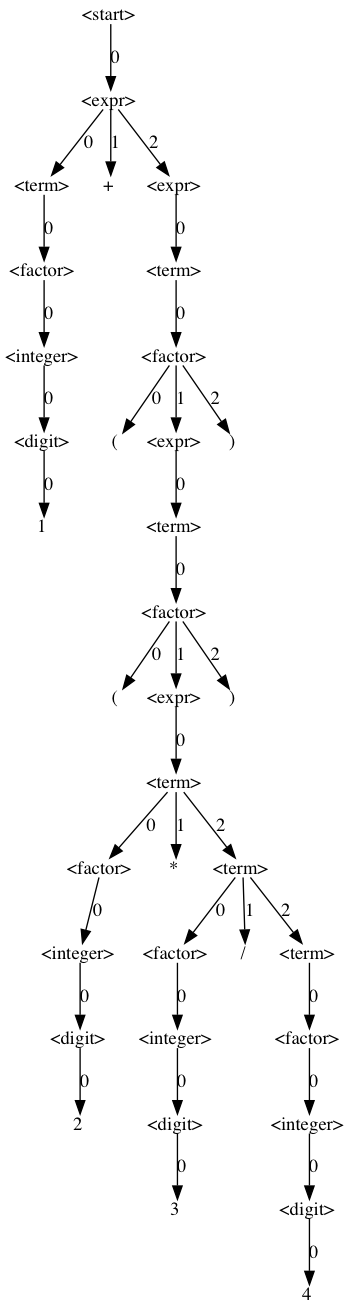

In [31]:
%top zoom(display_tree(expr_tree))

#### Latex

In [32]:
def r_to_latex(rule):
    if not rule: return '$\\epsilon$'
    return ' '.join(['%s' % t if is_nt(t) else "`%s'" % t for t in rule])

In [33]:
def d_to_latex(k, rules):
    return ('%s ::= %s' % (k, '\n\\alt '.join([r_to_latex(r) for r in rules])))

In [34]:
def g_to_latex(g):
    for k in g:
        print(d_to_latex(k, g[k]))
        print()

#### A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [35]:
import random

In [36]:
random.seed(0)

##### The interface

In [37]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

##### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [38]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def nonterminals(self, rule):
        return [t for t in rule if self.is_nt(t)]

    def iter_gen_key(self, key, max_depth):
        def get_def(t):
            if self.is_nt(t):
                return [t, None]
            else:
                return [t, []]

        cheap_grammar = {}
        for k in self.cost:
            # should we minimize it here? We simply avoid infinities
            rules = self.grammar[k]
            min_cost = min([self.cost[k][str(r)] for r in rules])
            #grammar[k] = [r for r in grammar[k] if self.cost[k][str(r)] == float('inf')]
            cheap_grammar[k] = [r for r in self.grammar[k] if self.cost[k][str(r)] == min_cost]

        root = [key, None]
        queue = [(0, root)]
        while queue:
            # get one item to expand from the queue
            (depth, item), *queue = queue
            key = item[0]
            if item[1] is not None: continue
            grammar = self.grammar if depth < max_depth else cheap_grammar
            chosen_rule = random.choice(grammar[key])
            expansion = [get_def(t) for t in chosen_rule]
            item[1] = expansion
            for t in expansion: queue.append((depth+1, t))
            #print("Fuzz: %s" % key, len(queue), file=sys.stderr)
        #print(file=sys.stderr)
        return root

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar:
            return (key, [])
        if depth > max_depth:
            #return self.gen_key_cheap_iter(key)
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return (key, self.gen_rule(random.choice(rules), depth+1, max_depth))

    def gen_rule(self, rule, depth, max_depth):
        return [self.gen_key(token, depth, max_depth) for token in rule]

    def fuzz(self, key='<start>', max_depth=10):
        self._s = self.iter_gen_key(key=key, max_depth=max_depth)
        return self.tree_to_str(self._s)
   
    def is_nt(self, name):
        return (name[0], name[-1]) == ('<', '>')
 
    def tree_to_str(self, tree):
        name, children = tree
        if not self.is_nt(name): return name
        return ''.join([tree_to_str(c) for c in children])

    def tree_to_str(self, tree):
        expanded = []
        to_expand = [tree]
        while to_expand:
            (key, children, *rest), *to_expand = to_expand
            if is_nt(key):
                #assert children # not necessary
                to_expand = children + to_expand
            else:
                assert not children
                expanded.append(key)
        return ''.join(expanded)


    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
            if len(grammar[k]):
                assert len([v for v in cost[k] if v != float('inf')]) > 0
        return cost

In [39]:
#%%top
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
bexpr_fuzzer = LimitFuzzer(BEXPR_GRAMMAR)

In [40]:
%top expr_fuzzer.fuzz(EXPR_START)

'2 * (19.541 + 7 / -4 / 5.7 * 5.0 + -0.2 * 2 * 8) / 4 - -(+3 * (1) / 1.9 / 2.3 - +0.7) / 07133 - 6 * 42.1 * (6.9 * 7) / (5 + 0) * 0 - 3 / +2 - -3 * 08 + (5 + 9.3) * 9 / 8.0 / 6.6'

In [41]:
%top bexpr_fuzzer.fuzz(BEXPR_START)

'and()'

### Library functions

Copying a grammar

In [42]:
def copy_grammar(g):
    return {k:[[t for t in r] for r in g[k]] for k in g}

Produce a sorted list of rules

In [43]:
def sort_rules(rules):
    return sorted([list(r) for r in rules])

#### Nullability

In [44]:
EPSILON=''
def get_rules(g): return [(k, e) for k, a in g.items() for e in a]
def get_terminals(g):
    return set(t for k, expr in get_rules(g) for t in expr if t not in g)
def fixpoint(f):
    def helper(*args):
        while True:
            sargs = repr(args)
            args_ = f(*args)
            if repr(args_) == sargs:
                return args
            args = args_
    return helper


@fixpoint
def nullable_(grules, e):
    for A, expression in grules:
        if all((token in e)  for token in expression): e |= {A}
    return (grules, e)

def nullable_nt(grammar):
    return nullable_(get_rules(grammar), set())[1]

def is_nullable(grammar, start):
    return start in nullable_nt(grammar)

In [45]:
%top nullable_nt({'<a>': [['a'], ['<b>']], '<b>': [[]], '<c>': [['c']]})

{'<a>', '<b>'}

#### Check for empty grammar

One can check for empty grammar by first removing all terminals and check the resulting grammar for nullability.

In [46]:
def remove_all_terminals(grammar):
    return {k:[[t for t in r if is_nt(t)] for r in grammar[k]] for k in grammar} 

In [47]:
%top _expr_grammar_tmp1 = remove_all_terminals(EXPR_GRAMMAR)

In [48]:
%top nullable_nt(_expr_grammar_tmp1)

{'<digit>', '<expr>', '<factor>', '<integer>', '<start>', '<term>'}

In [49]:
%top nullable_nt(EXPR_GRAMMAR)

set()

In [50]:
empty_g, empty_s = {'<start>': [['<expr>']], '<expr>': [['<expr>']]}, '<start>'

In [51]:
%top nullable_nt(empty_g)

set()

In [52]:
%top is_nullable(empty_g, empty_s)

False

In [53]:
%top is_nullable(EXPR_GRAMMAR, EXPR_START)

False

In [54]:
def is_cfg_empty(grammar, start):
    # first remove all terminals
    null_g = remove_all_terminals(grammar)
    # then check if start is nullable.
    return not is_nullable(null_g, start)

In [55]:
%top is_cfg_empty(EXPR_GRAMMAR, EXPR_START)

False

In [56]:
%top is_cfg_empty(empty_g, empty_s)

True

#### Show

In [57]:
def show_grammar(grammar, verbose=0):
    r = 0
    k = 0
    for key in grammar:
        k += 1
        if verbose > -1: print(key,'::=')
        for rule in grammar[key]:
            r += 1
            if verbose > 1:
                pre = r
            else:
                pre = ''
            if verbose > -1:
                print('%s|   ' % pre, ' '.join([t if is_nt(t) else repr(t) for t in rule]))
        if verbose > 0:
            print(k, r)
    print(k, r)

In [58]:
Gs = show_grammar

In [59]:
%top Gs(EXPR_GRAMMAR)

<start> ::=
|    <expr>
<expr> ::=
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
|    <term>
<term> ::=
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
|    <factor>
<factor> ::=
|    '+' <factor>
|    '-' <factor>
|    '(' <expr> ')'
|    <integer> '.' <integer>
|    <integer>
<integer> ::=
|    <digit> <integer>
|    <digit>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
6 24


#### Split token

In [60]:
def tsplit(token):
    assert token[0], token[-1] == ('<', '>')
    front, *back = token[1:-1].split(None, 1)
    return front, ' '.join(back)

#### The stem

The stem of a token is the original nonterminal it corresponds to, before refinement.

In [61]:
def stem(token):
    return tsplit(token)[0].strip()

#### Normalization

In [62]:
def normalize(key):
    return '<%s>' % stem(key)

In [63]:
def normalize_grammar(g):
    return {normalize(k):list({tuple([normalize(t) if is_nt(t) else t for t in r]) for r in g[k]}) for k in g}

#### The refinement

The refinement of a token is the part after the initial space in a token which corresponds to how the refined token came to be (based on adding/negating other faults.)

In [64]:
def refinement(token):
    return tsplit(token)[1]

In [65]:
def is_refined_key(key):
    assert is_nt(key)
    return (' ' in key)

In [66]:
def is_base_key(key):
    return not is_refined_key(key)

In [67]:
%top assert refinement('<a b>') == 'b'

In [68]:
%top assert is_refined_key('<a b>')

In [69]:
%top assert is_base_key('<a>')

In [70]:
%top assert not is_base_key('<a b>')

In [71]:
def is_refined_rule(rule):
    for k in rule:
        if is_nt(k) and is_refined_key(k): return True
    return False

#### Find Node
Finding nodes given the path

In [72]:
def find_node(node, path):
    name, children, *rest = node
    if not path:
        return node
    p, *path = path
    for i,c in enumerate(children):
        if i == p:
            return find_node(c, path)
    return None

In [73]:
%top assert find_node(expr_tree, [0,1]) == (' + ', [])

In [74]:
%top assert find_node(expr_tree, [0,2,0,0,2]) == (')', [])

In [75]:
def Ns(expr, paths):
    for path in paths:
        n = find_node(expr, path)
        print(n[0], tree_to_str(n))

In [76]:
%%top
Ns(expr_tree, [[0,2]])
Ns(expr_tree, [[0,2,0]])
Ns(expr_tree, [[0,2,0,0]])
Ns(expr_tree, [[0,2,0,0,1]])

<expr> ((2 * 3 / 4))
<term> ((2 * 3 / 4))
<factor> ((2 * 3 / 4))
<expr> (2 * 3 / 4)


#### Path to Key
Get the path to where key is defined. This is not for parse trees where the same nonterminal may be found in multiple nodes, but for trees where the key at each node is unique.

In [77]:
def path_to_key(tree, key):
    if tree is None: return None
    name, children = tree
    if key == name:
        return []
    for i,c in enumerate(children):
        p = path_to_key(c, key)
        if p is not None:
            return [i] + p
    return None

#### Rule to normalized rule

In [78]:
def rule_to_normalized_rule(rule):
    return [normalize(t) if is_nt(t) else t for t in rule]

In [79]:
def normalized_rules(rules):
    return [list(rule) for rule in {tuple(rule_to_normalized_rule(r)) for r in rules}]

In [80]:
def normalized_rule_match(r1, r2):
    return rule_to_normalized_rule(r1) == rule_to_normalized_rule(r2)

In [81]:
def rule_normalized_difference(rulesA, rulesB):
    rem_rulesA = rulesA
    for ruleB in rulesB:
        rem_rulesA = [rA for rA in rem_rulesA if not normalized_rule_match(rA, ruleB)]
    return rem_rulesA

In [82]:
def rules_normalized_match_to_rule(rulesA, rB):
    selA = [rA for rA in rulesA if normalized_rule_match(rA, rB)]
    return selA

In [83]:
%top EXPR_GRAMMAR['<factor>']

[['+', '<factor>'],
 ['-', '<factor>'],
 ['(', '<expr>', ')'],
 ['<integer>', '.', '<integer>'],
 ['<integer>']]

In [84]:
%%top
assert rule_normalized_difference(EXPR_GRAMMAR['<factor>'], [['(', '<expr F1>', ')']]) == [
    ['+', '<factor>'],
    ['-', '<factor>'],
    ['<integer>', '.', '<integer>'],
    ['<integer>']]

In [85]:
%%top
assert rule_normalized_difference(EXPR_GRAMMAR['<factor>'], [['(', '<expr>', ')'], ['<integer>']]) == [
    ['+', '<factor>'],
    ['-', '<factor>'],
    ['<integer>', '.', '<integer>']]

#### Node to normalized rule

In [86]:
def node_to_rule(node):
    name, children, *rest = node
    return [c[0] for c in children]

In [87]:
%top node_to_rule(find_node(expr_tree, [0]))

['<term>', ' + ', '<expr>']

In [88]:
%top n = find_node(expr_tree, [0,2,0, 0]); n

('<factor>',
 [('(', []),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', []),
        ('<expr>',
         [('<term>',
           [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
            (' * ', []),
            ('<term>',
             [('<factor>', [('<integer>', [('<digit>', [('3', [])])])]),
              (' / ', []),
              ('<term>',
               [('<factor>',
                 [('<integer>', [('<digit>', [('4', [])])])])])])])]),
        (')', [])])])]),
  (')', [])])

In [89]:
%top node_to_rule(n)

['(', '<expr>', ')']

In [90]:
def node_to_normalized_rule(node):
    return rule_to_normalized_rule(node_to_rule(node))

In [91]:
%top node_to_normalized_rule(n)

['(', '<expr>', ')']

In [92]:
def get_rulesets(rules):
    rulesets = {}
    for rule in rules:
        nr = tuple(rule_to_normalized_rule(rule))
        if nr not in rulesets: rulesets[nr] = []
        rulesets[nr].append(rule)
    return rulesets

#### Replace Tree

In [93]:
def replace_tree(node, path, newnode):
    if not path:
        return newnode
    name, children = node
    hd, *subpath = path
    assert hd < len(children)
    new_children = []
    for i,c in enumerate(children):
        if i == hd:
            c_ = replace_tree(c, subpath, newnode)
        else:
            c_ = c
        new_children.append(c_)
    return (name, new_children)

In [94]:
%top assert tree_to_str(find_node(expr_tree, [0,2,0,0])) == '((2 * 3 / 4))'

In [95]:
%top assert tree_to_str(replace_tree(expr_tree, [0, 2, 0, 0], ('1', []))) == '1 + 1'

#### Validate Tree

Validating a parse tree

In [96]:
def validate_tree(tree, grammar):
    def keys(arr):
        return [a[0] for a in arr]
    name, children, *rest = tree
    if not is_nt(name): return True
    
    seen = False
    for rule in grammar[name]:
        if keys(children) == rule:
            seen = True
    assert seen, name + ' needs ' + repr(grammar[name])
    for c in children:
        validate_tree(c, grammar)

In [97]:
%top validate_tree(expr_tree, EXPR_GRAMMAR)

In [98]:
%%top
try:
    validate_tree(replace_tree(expr_tree, [0, 2, 0, 0], ('1', [])), EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

<term> needs [['<factor>', ' * ', '<term>'], ['<factor>', ' / ', '<term>'], ['<factor>']]


In [99]:
%%top
rt = replace_tree(expr_tree, [0, 2, 0, 0], ('<factor>', [('<integer>', [('<digit>',[('1', [])])])]))
validate_tree(rt, EXPR_GRAMMAR)

In [100]:
%top assert tree_to_str(rt) == '1 + 1'

#### Remove empty keys

Remove keys that do not have a definition.

In [101]:
def find_empty_keys(g):
    return [k for k in g if not g[k]]

In [102]:
def remove_key(k, g):
    new_g = {}
    for k_ in g:
        if k_ == k:
            continue
        else:
            new_rules = []
            for rule in g[k_]:
                new_rule = []
                for t in rule:
                    if t == k:
                        # skip this rule
                        new_rule = None
                        break
                    else:
                        new_rule.append(t)
                if new_rule is not None:
                    new_rules.append(new_rule)
            new_g[k_] = new_rules
    return new_g

In [103]:
def remove_empty_keys(g):
    new_g = copy_grammar(g)
    removed_keys = []
    empty_keys = find_empty_keys(new_g)
    while empty_keys:
        for k in empty_keys:
            removed_keys.append(k)
            new_g = remove_key(k, new_g)
        empty_keys = find_empty_keys(new_g)
    return new_g, removed_keys

In [104]:
tmp_g_empty_ = {
    '<start>': [['<v>']],
    '<v>': [
        ['<expr>'],
        ['<digit>']
    ],
    '<expr>': [['<digit>'],
              ['x', '<empty>']],
    '<digit>': [['0']],
    '<empty>': []
}

In [105]:
%%top
tmp_g, removed_keys = remove_empty_keys(tmp_g_empty_)
Gs(tmp_g)
removed_keys

<start> ::=
|    <v>
<v> ::=
|    <expr>
|    <digit>
<expr> ::=
|    <digit>
<digit> ::=
|    '0'
4 5


['<empty>']

#### Find all nonterminals

In [106]:
def find_all_nonterminals(g):
    lst = []
    for k in g:
        for r in g[k]:
            for t in r:
                if is_nt(t):
                    lst.append(t)
    return list(sorted(set(lst)))

In [107]:
%top find_all_nonterminals(tmp_g)

['<digit>', '<expr>', '<v>']

#### Undefined keys

In [108]:
def undefined_keys(grammar):
    keys = find_all_nonterminals(grammar)
    return [k for k in keys if k not in grammar]

####  Remove unused keys

Removes unused nonterminal keys

In [109]:
def remove_unused_keys(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sort_rules(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)
    if start_symbol not in grammar:
        return {}, []

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    if len(order) != len(grammar.keys()):
        stripped = [k for k in grammar if k not in order]
        #if stripped:
        #    print("Stripping: %s" % str(stripped))
        faulty = [k for k in order if k not in grammar]
        assert not faulty
    new_g = {k: [list(r) for r in sort_rules(grammar[k])] for k in order}
    return new_g, [k for k in grammar if k not in new_g]

In [110]:
%%top
tmp_g_unused_ = copy_grammar(EXPR_GRAMMAR)
tmp_g_unused_['<unused>'] = [['1']]
Gs(tmp_g_unused_,-1)
tmp_g, removed_keys = remove_unused_keys(tmp_g_unused_, EXPR_START)
Gs(tmp_g)
removed_keys

7 25
<start> ::=
|    <expr>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
6 24


['<unused>']

#### Validate grammar

In [111]:
def validate_grammar(grammar, start_symbol, log=False):
    assert len(grammar[start_symbol]) == 1 # otherwise parser will not work
    for r in grammar[start_symbol]:
        assert len([t for t in r if is_nt(t)]) == 1 # otherwise disjunction will not work
    def strip_key(grammar, key, order):
        rules = sort_rules(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)
    if start_symbol not in grammar:
        return {}, []

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    valid = True
    if len(order) != len(grammar.keys()):
        unused = [k for k in grammar if k not in order]
        faulty = [k for k in order if k not in grammar]
        if faulty or unused:
            if log:
                print('faulty:', faulty)
                print('unused:', unused)
            return False
    for (k1,k2) in zip(sorted(order), sorted(grammar.keys())):
        if k1 != k2:
            valid = False
            if log:
                print('order:', k1, 'grammar:', k2)
        else:
            if log:
                print(k1, k2)
    for k in grammar:
        if not grammar[k]:
            return False
    return valid

In [112]:
%top assert validate_grammar(EXPR_GRAMMAR, EXPR_START, True)

<digit> <digit>
<expr> <expr>
<factor> <factor>
<integer> <integer>
<start> <start>
<term> <term>


In [113]:
tmp_g_empty_

{'<start>': [['<v>']],
 '<v>': [['<expr>'], ['<digit>']],
 '<expr>': [['<digit>'], ['x', '<empty>']],
 '<digit>': [['0']],
 '<empty>': []}

In [114]:
%top assert not validate_grammar(tmp_g_empty_, '<start>', True)

<digit> <digit>
<empty> <empty>
<expr> <expr>
<start> <start>
<v> <v>


In [115]:
%top assert not validate_grammar(tmp_g_unused_, '<start>', True)

faulty: []
unused: ['<unused>']


#### Finding reachable keys

In [116]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [117]:
%%top
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, {})
    print(key, keys)

<start> {'<term>', '<expr>', '<factor>', '<digit>', '<integer>'}
<expr> {'<term>', '<expr>', '<factor>', '<digit>', '<integer>'}
<term> {'<term>', '<expr>', '<factor>', '<digit>', '<integer>'}
<factor> {'<term>', '<expr>', '<factor>', '<digit>', '<integer>'}
<integer> {'<digit>', '<integer>'}
<digit> set()


Finding recursive keys

In [118]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [119]:
%%top
reachable_dict(EXPR_GRAMMAR)

{'<start>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<expr>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<term>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<factor>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<integer>': {'<digit>', '<integer>'},
 '<digit>': set()}

#### Simplify boolean expressions

In [120]:
import sympy

In [121]:
class LitB:
    def __init__(self, a): self.a = a
    def __str__(self): return self.a

TrueB = LitB('')
FalseB = LitB('_|_')

class OrB:
    def __init__(self, a): self.l = a
    def __str__(self): return 'or(%s)' % ','.join(sorted([str(s) for s in self.l]))
class AndB:
    def __init__(self, a): self.l = a
    def __str__(self): return 'and(%s)' % ','.join(sorted([str(s) for s in self.l]))
class NegB:
    def __init__(self, a): self.a = a
    def __str__(self): return 'neg(%s)' % str(self.a)
class B:
    def __init__(self, a): self.a = a
    def __str__(self): return str(self.a)

In [122]:

class BExpr:
    def __init__(self, s):
        if s is not None:
            self._s = s
            self._tree = self._parse(s)
            self._simple, self._sympy = self._simplify()
        else: # create
            self._s = None
            self._tree = None
            self._simple = None
            self._sympy = None
            
    def simple(self):
        if self._simple is None:
            self._simple = str(self._convert_sympy_to_bexpr(self._sympy))
        return self._simple

    def _parse(self, k):
        bexpr_parser = Parser(BEXPR_GRAMMAR, canonical=True, start_symbol=BEXPR_START)
        bparse_tree = list(bexpr_parser.parse(k))[0]
        bexpr = bparse_tree[1][0]
        return bexpr
    
    def with_key(self, k):
        s = self.simple()
        if s: return '<%s %s>' % (stem(k), s)
        return normalize(k)

    def _simplify(self):
        e0, defs = self._convert_to_sympy(self._tree)
        e1 = sympy.to_dnf(e0)
        e2 = self._convert_sympy_to_bexpr(e1)
        v = str(e2)
        my_keys = [k for k in defs]
        for k in my_keys:
            del defs[k]
        return v, e1
    
    def is_neg_sym(self):
        op = self.get_operator()
        if op != 'neg': return False
        if not isinstance(self._sympy.args[0], sympy.Symbol): return False
        return True
    
    def get_operator(self):
        if isinstance(self._sympy, sympy.And): return 'and'
        elif isinstance(self._sympy, sympy.Or): return 'or'
        elif isinstance(self._sympy, sympy.Not): return 'neg'
        else: return ''
    
    def op_fst(self):
        op = self.get_operator()
        assert op == 'neg'
        bexpr = BExpr(None)
        bexpr._sympy = self._sympy.args[0]
        return bexpr
    
    def op_fst_snd(self):
        bexpr = BExpr(None)
        bexpr._sympy = self._sympy.args[0]
        
        bexpr_rest = BExpr(None)
        op = self.get_operator()

        if op == 'and':
            bexpr_rest._sympy = sympy.And(*self._sympy.args[1:])
        elif op == 'or':
            bexpr_rest._sympy = sympy.Or(*self._sympy.args[1:])
        else:
            assert False
        return bexpr, bexpr_rest

    def negate(self):
        bexpr = BExpr(None)
        bexpr._sympy = sympy.Not(self._sympy).simplify()
        return bexpr

    def _flatten(self, bexprs):
        assert bexprs[0] == '<bexprs>'
        if len(bexprs[1]) == 1:
            return [bexprs[1][0]]
        else:
            assert len(bexprs[1]) == 3
            a = bexprs[1][0]
            comma = bexprs[1][1]
            rest = bexprs[1][2]
            return [a] + self._flatten(rest)

    def _convert_to_sympy(self, bexpr_tree, symargs=None):
        def get_op(node):
            assert node[0] == '<bop>', node[0]
            return node[1][0][0]
        if symargs is None:
            symargs = {}
        name, children = bexpr_tree
        assert name == '<bexpr>', name
        if len(children) == 1: # fault node
            name = tree_to_str(children[0])
            if not name: return None, symargs
            if name not in symargs:
                symargs[name] = sympy.symbols(name)
            return symargs[name], symargs
        else:
            operator = get_op(children[0])
            if children[2][0] == '<bexprs>':
                res = self._flatten(children[2])
            else:
                res = [children[2]]
            if operator == 'and':
                sp = [self._convert_to_sympy(a, symargs) for a in res]
                return sympy.And(*[a for a,_ in sp]), symargs

            elif operator == 'or':
                sp = [self._convert_to_sympy(a, symargs) for a in res]
                return sympy.Or(*[a for a,_ in sp]), symargs

            elif operator == 'neg':
                assert len(res) == 1
                a,_ = self._convert_to_sympy(res[0], symargs)
                return sympy.Not(a), symargs
            else:
                assert False

    def _convert_sympy_to_bexpr(self, sexpr, log=False):
        if isinstance(sexpr, sympy.Symbol):
            return B(str(sexpr))
        elif isinstance(sexpr, sympy.Not):
            return NegB(self._convert_sympy_to_bexpr(sexpr.args[0]))
        elif isinstance(sexpr, sympy.And):
            a = sexpr.args[0]
            b = sexpr.args[1]
            if isinstance(a, sympy.Not):
                if str(a.args[0]) == str(b): return FalseB # F & ~F == _|_
            elif isinstance(b, sympy.Not):
                if str(b.args[0]) == str(a): return FalseB # F & ~F == _|_
            sym_vars = sorted([self._convert_sympy_to_bexpr(a) for a in sexpr.args], key=str)
            assert sym_vars
            if FalseB in sym_vars: return FalseB # if bottom is present in and, that is the result
            if TrueB in sym_vars:
                sym_vars = [s for s in sym_vars if s != TrueB] # base def does not do anything in and.
                if not sym_vars: return TrueB
            return AndB(sym_vars)
        elif isinstance(sexpr, sympy.Or):
            a = sexpr.args[0]
            b = sexpr.args[1]
            if isinstance(a, sympy.Not):
                if str(a.args[0]) == str(b): return TrueB # F | ~F = U self._convert_sympy_to_bexpr(b)
            elif isinstance(b, sympy.Not):
                if str(b.args[0]) == str(a): return TrueB # F | ~F = U self._convert_sympy_to_bexpr(a)

            sym_vars = sorted([self._convert_sympy_to_bexpr(a) for a in sexpr.args], key=str)
            assert sym_vars
            if TrueB in sym_vars: return TrueB # if original def is present in or, that is the result
            if FalseB in sym_vars:
                sym_vars = [s for s in sym_vars if s != FalseB]
                if not sym_vars: return FalseB
            return OrB(sym_vars)
        else:
            if log: print(repr(sexpr))
            assert False

In [123]:
#%%top
bexpr_input = 'and(and(and(and(and(neg(+F2),neg(L2_2)),neg(+F2)),and(neg(+F2),neg(L2_2))),and(and(neg(+F2),neg(L2_2)),neg(+F2))),and(and(and(neg(+F2),neg(L2_2)),neg(+F2)),and(neg(+F2),neg(L2_2))))'
simplified_bexpr_input = BExpr(bexpr_input).simple()

In [124]:
%top simplified_bexpr_input

'and(neg(+F2),neg(L2_2))'

In [125]:
a, b = BExpr(bexpr_input).op_fst_snd()
a._sympy, b._sympy

(~+F2, ~L2_2)

In [126]:
def disj(k1, k2, simplify=False):
    assert is_nt(k1)
    if k1 == k2: return k1
    rk1 = refinement(k1)
    rk2 = refinement(k2)
    if not rk1: return k1
    if not rk2: return k2
    k = stem(k1)
    if rk1 == '_|_': return k2
    if rk2 == '_|_': return k1
    b = BExpr('or(%s,%s)' % (rk1, rk2))
    return b.with_key(k1)

In [127]:
def conj(k1, k2, simplify=False):
    assert is_nt(k1)
    if k1 == k2: return k1
    rk1 = refinement(k1)
    rk2 = refinement(k2)
    if not rk1: return k2
    if not rk2: return k1
    k = stem(k1)
    if rk1 == '_|_': return k1
    if rk2 == '_|_': return k2
    b = BExpr('and(%s,%s)' % (rk1, rk2))
    return b.with_key(k1)

#### Remove shadowed refined rules

##### is_A_more_refined_than_B

Compare the positions of `ruleA` and `ruleB` in `porder` of base `grammar`.
In the porder, we assume the most general ones will come first.

In [128]:
def is_A_more_refined_than_B(ruleA, ruleB, porder):
    if len(ruleA) != len(ruleB): return False
    for a_, b_ in zip(ruleA, ruleB):
        if not is_nt(a_) or not is_nt(b_):
            if a_ != b_: return False
            continue
        a = normalize(a_) 
        b = normalize(b_)
        if a != b: return False
        if a not in porder or b not in porder: return None
        pkA = path_to_key(porder[a], a_)
        pkB = path_to_key(porder[b], b_)
        if pkA is None or pkB is None: return None # we dont know.
        pA = ' '.join([str(s) for s in pkA])
        pB = ' '.join([str(s) for s in pkB])
        # more general should be included in the more specific
        if pB not in pA: return False
    return True

In [129]:
%%top
my_porder = {'<a>' : ('<a>',[('<a 1>', [('<a 2>',[('<a 3>',[])])])]),
             '<b>':  ('<b>',[('<b 1>', [('<b 2>',[('<b 3>',[])])])]),
             '<c>':  ('<c>',[('<c 1>', [('<c 2>',[('<c 3>',[])])])])}

In [130]:
%top assert not is_A_more_refined_than_B(['<a 1>', '<b 1>', '<c 1>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [131]:
%top assert is_A_more_refined_than_B(['<a 3>', '<b 3>', '<c 3>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [132]:
%top assert is_A_more_refined_than_B(['<a 2>', '<b 2>', '<c 3>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

In [133]:
%top assert not is_A_more_refined_than_B(['<a 3>', '<b 3>', '<c 1>'], ['<a 2>', '<b 2>', '<c 2>'], my_porder)

##### Get general rule

In [134]:
def get_general_rule(ruleA, rules, porder):
    unknown = 0
    for r in rules:
        v = is_A_more_refined_than_B(ruleA, r, porder)
        if v is None:
            # we dont know about this.
            unknown += 1
            continue
        elif v:
            return r, unknown
    return None, unknown

In [135]:
%%top
get_general_rule(['<a 1>', '<b 1>', '<c 1>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>', '<c 2>'],
    ['<a 3>', '<b 3>', '<c 3>'],
], my_porder)

(['<a 1>', '<b 1>', '<c 1>'], 0)

In [136]:
%%top
get_general_rule(['<a 1>', '<b 1>', '<c 3>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>'],
    ['<a 3>'],
], my_porder)

(['<a 1>', '<b 1>', '<c 1>'], 0)

In [137]:
%%top
get_general_rule(['<a 1>', '<b 2>'], [
    ['<a 1>', '<b 1>', '<c 1>'],
    ['<a 2>', '<b 2>'],
    ['<a 3>'],
], my_porder)

(None, 0)

##### Is keyA more refined than keyB

In [138]:
def is_keyA_more_refined_than_keyB(keyA, keyB, porder, grammar):
    # essential idea of comparing two keys is this:
    # One key is smaller than the other if for any given rule in the first, there exist another rule that is larger
    # than that in the second key.
    # a rule is smaller than another if all tokens in that rule is either equal (matching) or smaller than
    # the corresponding token in the other.
    
    # if normalize(keyB) == keyB: return True # normalized key is always the top (and may not exist in grammar)
    
    A_rules = grammar[keyA]
    B_rules = grammar[keyB]
   
    for A_rule in A_rules:
        v,unk = get_general_rule(A_rule, B_rules, porder)
        if v is None:
            if unk:
                return None # dont know
            return False
        # There is a more general rule than A_rule in B_rules
    return True

##### Insert into partial order

In [139]:
def insert_into_porder(my_key, porder, grammar):
    def update_tree(my_key, tree, grammar):
        if tree is None: return True, (my_key, [])
        k, children = tree
        if is_base_key(my_key):
            if not is_base_key(k):
                return True, (my_key, [tree])
            else:
                return False, tree
 
        v = is_keyA_more_refined_than_keyB(my_key, k, porder, grammar)
        if is_base_key(k): v = True
        # if v is unknown...
        if v: # we should go into the children
            if not children:
                #print('>', 0)
                return True, (k, [(my_key, [])])
            new_children = []
            updated = False
            for c in children:
                u, c_ = update_tree(my_key, c, grammar)
                if u: updated = True
                new_children.append(c_)
            #print('>', 1)
            return updated, (k, new_children)
        else:
            #v = is_keyA_more_refined_than_keyB(k, my_key, porder, grammar)
            if v:
                #this should be the parent of tree
                #print('>', 2)
                return True, (my_key, [tree])
            else:
                # add as a sibling -- but only if we have evidence.
                if v is not None:
                    #print('>', 3)
                    return True, (k, children + [(my_key, [])])
                else:
                    return False, tree
    key = normalize(my_key)
    updated, v = update_tree(my_key, porder.get(key, None), grammar)
    if updated:
        porder[key] = v
    return updated

##### Is key in partial order

In [140]:
def is_key_in_porder(key, tree):
    if tree is None: return False
    name, children = tree
    if name == key:
        return True
    for c in children:
        if is_key_in_porder(key, c):
            return True
    return False

##### Identify partial orders of nonterminals from a grammar

In theory, identifying partial orders is simple once you have the machinary for `and` and `neg`. To find if a given nonterminal `A` is more refined than `B`, do `A - B` and `B - A` and check which of these are empty. Since we do not have the machinery yet, doing it here without that.

In [141]:
def identify_partial_orders(grammar):
    porder = {}
    cont = True
    while cont:
        cont = False
        for k in grammar:
            nkey = normalize(k)
            if is_key_in_porder(k, porder.get(nkey, None)):
                continue
            updated = insert_into_porder(k, porder, grammar)
            if not updated:
                continue
            cont = True
    #for k in grammar:
    #    assert k in porder
    return porder

In [142]:
%%top
po = identify_partial_orders(EXPR_GRAMMAR); po

{'<start>': ('<start>', []),
 '<expr>': ('<expr>', []),
 '<term>': ('<term>', []),
 '<factor>': ('<factor>', []),
 '<integer>': ('<integer>', []),
 '<digit>': ('<digit>', [])}

In [143]:
def rule_is_redundant(rule, rules, porder):
    # a rule is redundant if there is another in the rules that is more general.
    grule, unknown = get_general_rule(rule, [r for r in rules if r != rule], porder)
    if grule:
        return True
    return False

In [144]:
def remove_redundant_rules(grammar, porder=None):
    if porder is None:
        porder = identify_partial_orders(grammar)
    else:
        if porder == {}:
            _porder = identify_partial_orders(grammar)
            porder.update(_porder)
        else:
            pass
        
    new_g = {}
    removed_rules = 0
    for key in grammar:
        ruleset = list({tuple(r) for r in grammar[key]})
        cont = True
        while cont:
            cont = False
            for rule in ruleset:
                if rule_is_redundant(rule, ruleset, porder):
                    ruleset = [r for r in ruleset if r != rule]
                    removed_rules += 1
                    cont = True
                else:
                    continue
            new_g[key] = ruleset
    return new_g, removed_rules

In [145]:
%%top
g, n = remove_redundant_rules(EXPR_GRAMMAR);
Gs(g)

<start> ::=
|    <expr>
<expr> ::=
|    <term>
|    <term> ' - ' <expr>
|    <term> ' + ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor> ::=
|    <integer> '.' <integer>
|    <integer>
|    '+' <factor>
|    '-' <factor>
|    '(' <expr> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '3'
|    '0'
|    '2'
|    '1'
|    '4'
|    '6'
|    '9'
|    '8'
|    '7'
|    '5'
6 24


In [146]:
def is_nulled_rule(rule):
    for t in rule:
        if not is_nt(t): continue
        if refinement(t) == '_|_':
            return True
    return False

In [147]:
def remove_nulled_rules(grammar):
    g = {}
    nulled_rules = []
    for k in grammar:
        g[k] = []
        for rule in grammar[k]:
            if is_nulled_rule(rule):
                nulled_rules.append(rule)
            else:
                g[k].append(rule)
    return g, nulled_rules

#### Grammar GC

We will redefine this later when the negation comes in.

In [148]:
def grammar_gc(grammar, start_symbol, options=(1,2, 3), log=False):
    g = grammar
    while True:
        if 1 in options:
            g0, empty_keys = remove_empty_keys(g) # keys with rules empty
        else:
            g0, empty_keys = g, []
        for k in g0:
            for rule in g0[k]:
                for t in rule: assert type(t) is str

        if 2 in options:
            g1, unused_keys = remove_unused_keys(g0, start_symbol) #keys that are not reachable from start
        else:
            g1, unused_keys = g0, []
        for k in g1:
            for rule in g1[k]:
                for t in rule: assert type(t) is str

        if 3 in options:
            g2, nulled_rules = remove_nulled_rules(g1) # rules with _|_ in them
        else:
            g2, nulled_rules = g1, []
            
        g = g2
        if log:
            print('GC: ', unused_keys, empty_keys, nulled_rules)
        if not (len(unused_keys) + len(empty_keys) + len(nulled_rules)):
            break
    # removing redundant rules is slightly dangerous. It can remove things
    # like finite limit of a recursion because the limit is more refined than
    # other rules.
    # E.g
    #  <E f> = <E f>
    #        | <E l>
    #  <E l> = 1
    # Here, <E f> is more general than <E l> precisely because <E l> exists
    # but our partial orders are not intelligent enough (todo: check)
    #if 3 in options:
    #    g2, redundant_rules = remove_redundant_rules(g)
    #else:
    # g2, redundant_rules = g, 0
        
    #if 4 in options:
    #  We need to incorporate simplify booleans
    #else:
    return g, start_symbol

#### Complete

In [149]:
def find_reachable_keys_unchecked(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar.get(key, []):
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys_unchecked(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [150]:
def reachable_dict_unchecked(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys_unchecked(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [151]:
def complete(grammar, start, log=False):
    keys = undefined_keys(grammar)
    reachable_keys = reachable_dict_unchecked(grammar)
    for key in keys:
        if key not in reachable_keys[start]: continue
        grammar = reconstruct_key(key, grammar, log)
    grammar, _ = grammar_gc(grammar, start)
    return grammar

## Inserting a fault

In [152]:
EXCEPTION_HAPPENED

[]

The output that we get from `ddset` has nodes marked. So, we define a way to mark nodes as abstract.

### Mark the abstract nodes

Given a path, we mark the node as abstract.

In [153]:
def mark_path_abstract(tree, path):
    name, children = find_node(tree, path)
    new_tree = replace_tree(tree, path, (name, children, {'abstract': True}))
    return new_tree

First, we locate a suitable node.

In [154]:
%%top
abs_path_1 = [0,2,0,0,1,0,0,1]
assert tree_to_str(find_node(expr_tree, abs_path_1)) == '2 * 3 / 4'

In [155]:
%%top
v = mark_path_abstract(expr_tree, abs_path_1); v

('<start>',
 [('<expr>',
   [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
    (' + ', []),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', []),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', []),
                ('<expr>',
                 [('<term>',
                   [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
                    (' * ', []),
                    ('<term>',
                     [('<factor>',
                       [('<integer>', [('<digit>', [('3', [])])])]),
                      (' / ', []),
                      ('<term>',
                       [('<factor>',
                         [('<integer>', [('<digit>', [('4', [])])])])])])])],
                 {'abstract': True}),
                (')', [])])])]),
          (')', [])])])])])])

Given a tree with some nodes marked abstract, go through the tree, and mark everything else as concrete. Default is to mark a node as concrete.

In [156]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

In [157]:
%%top
t = mark_concrete_r(v); t

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    (' + ', [], {'abstract': False}),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('2', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' * ', [], {'abstract': False}),
                    ('<term>',
                     [('<factor>',
                      

A way to display the abstracted tree

In [158]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

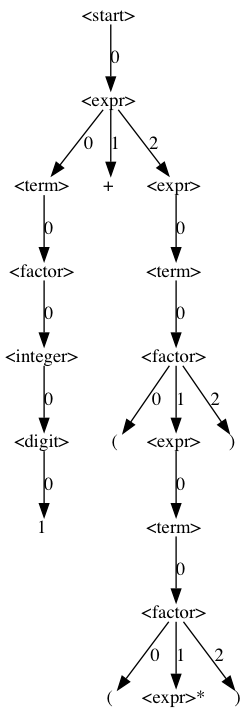

In [159]:
%%top
zoom(display_tree(till_abstract(t)))

In [160]:
def Da(t):
    return zoom(display_tree(till_abstract(t)))

In [161]:
#%%top
abs_t1_ = find_node(expr_tree, [0, 2])
tree_to_str(abs_t1_), abs_t1_[0]

('((2 * 3 / 4))', '<expr>')

In [162]:
#%%top
abs_t1 = ('<start>', [abs_t1_])

In [163]:
%top validate_tree(abs_t1, EXPR_GRAMMAR)

In [164]:
#%%top
t_abs_p1 = [0, 0, 0, 1, 0, 0, 1]
Ts(find_node(abs_t1, t_abs_p1))

'2 * 3 / 4'

We now define a function to check if a given node is abstract or not.

In [165]:
def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [166]:
def tree_to_str_a(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([tree_to_str_a(c) for c in children])

In [167]:
Ta = tree_to_str_a

In [168]:
%top tree_to_str_a(t)

'1 + ((<expr>))'

In [169]:
#%%top
abs_tree1 = mark_concrete_r(mark_path_abstract(abs_t1, t_abs_p1)); abs_tree1

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('2', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False}),
                  (' * ', [], {'abstract': False}),
                  ('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('3', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' / ', [], {'abstract': False}),
               

In [170]:
%top Ta(abs_tree1)

'((<expr>))'

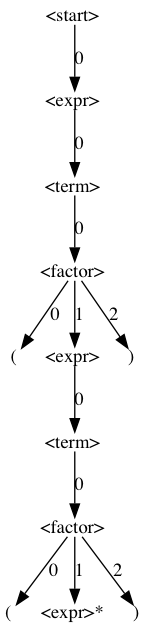

In [171]:
%top Da(abs_tree1)

In [172]:
def mark_abstract_nodes(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, path)
    return mark_concrete_r(tree)

In [173]:
%top Ta(mark_abstract_nodes(abs_t1, []))

'((2 * 3 / 4))'

### An abstract pattern from DDSET - F1

In [174]:
%top Ta(mark_abstract_nodes(abs_t1, [t_abs_p1]))

'((<expr>))'

**IMPORTANT** This is what we expect our input to be. That is, a full parse tree of a minimized string with abstractions (typed holes) indicated.

### Finding characterizing node

A characterizing node is the lowest node that completely contains the given pattern. To find a characterizing node, we use the miniaml AST, and identify the parent node that encloses all the concrete nodes.

In [175]:
SKIP_ABSTRACT_NODE = False

In [176]:
def find_charecterizing_node(tree):
    name, children, *gen = tree
    if len(children) == 1:
        return find_charecterizing_node(children[0])
    # trim out children that are empty from the beginning
    # and end
    non_empty = []
    for c in children:
        if not is_nt(c[0]):
            # have a terminal. So, the parent node is charecterizing.
            return tree
        elif is_node_abstract(c) and SKIP_ABSTRACT_NODE:
            # outer abstract node. Hence, not part of charecterizing node.
            continue
        elif tree_to_str(c):
            non_empty.append(c)
    assert non_empty, 'fault node should have at least one non-empty child'
    if len(non_empty) > 1:
        return tree
    else:
        return find_charecterizing_node(non_empty[0])

In [177]:
#%%top
abs_tree_cnode1 = find_charecterizing_node(abs_tree1); abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

As can be seen, the `<factor>` node completely contains the fault pattern.

In [178]:
%top abs_tree1[0], Ts(abs_tree1)

('<start>', '((2 * 3 / 4))')

In [179]:
%top abs_tree_cnode1[0], Ts(abs_tree_cnode1)

('<factor>', '((2 * 3 / 4))')

Now, we want to add our grammar the keys that are required to cause a failure. For that, we first extract the local grammar that reproduces the fault pattern 

### Pattern Grammar

In [180]:
%top abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

In [181]:
 def mark_faulty_name(symbol, prefix, v):
    return '<%s L%s_%s>'% (symbol[1:-1], prefix, v)

In [182]:
def mark_faulty_nodes(node, prefix, counter=None):
    if counter is None: counter = {}
    symbol, children, *abstract = node
    if is_node_abstract(node): # we dont markup further
        return node
    if symbol not in counter: counter[symbol] = 0
    counter[symbol] += 1
    v = str(counter[symbol])
    if is_nt(symbol):
        return (mark_faulty_name(symbol, prefix, v),
                [mark_faulty_nodes(c, prefix, counter) for c in children],
                *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

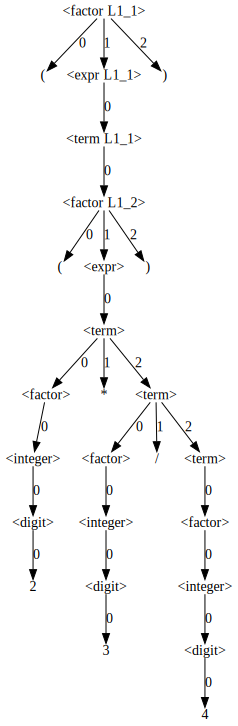

In [183]:
%top display_tree(mark_faulty_nodes(abs_tree_cnode1, '1'))

In [184]:
%top c_node1 = mark_faulty_nodes(abs_tree_cnode1, '1')

In [185]:
%top f_node1 = c_node1

In [186]:
def faulty_node_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if is_nt(n):
            faulty_node_to_grammar(c, grammar)
    grammar[name].append(tuple(tokens))
    return grammar, tree[0]

In [187]:
%%top
g, s = faulty_node_to_grammar(abs_tree_cnode1)
Gs(g)
s

<factor> ::=
|    '(' <expr> ')'
|    '(' <expr> ')'
<expr> ::=
|    <term>
<term> ::=
|    <factor>
3 4


'<factor>'

In [188]:
def faulty_node_to_pattern_grammar(tree, prefix, grammar=None):
    ltree = mark_faulty_nodes(tree, prefix)
    return faulty_node_to_grammar(ltree)

In [189]:
#%%top
lg1, ls1 = faulty_node_to_pattern_grammar(abs_tree_cnode1, '1')

In [190]:
%%top
Gs(lg1)
ls1

<factor L1_1> ::=
|    '(' <expr L1_1> ')'
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
4 4


'<factor L1_1>'

In [191]:
%top dd_tree_abs1 = abs_tree1

In [192]:
#%top
node_faulty1 = abs_tree_cnode1

### Finding insertable positions

Given a rule, and the faulty symbol, the positions in the rule where the fault can be inserted are all the non-terminals that will eventually reach the symbol of the faulty symbol. That is, if we have `<digit> + <expr>` as the expansion and the faulty symbol is `<factor*>` then, since `<digit>` can never reach `<factor>`, `0` is out, and so is `1` since it is a terminal symbol. Hence, only `<expr>` remains, which when expanded, one of the expansion paths will include a `<factor>`. Hence, here `[2]` is the answer.

In [193]:
def get_reachable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not is_nt(token): continue
        if fkey == token or fkey in reachable[token]:
            positions.append(i)
    return positions

In [194]:
reachable1 = reachable_dict(EXPR_GRAMMAR)

In [195]:
%%top
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_reachable_positions(rule, '<factor>', reachable1)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', ' + ', '<expr>'] [0, 2]
	 ['<term>', ' - ', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', ' * ', '<term>'] [0, 2]
	 ['<factor>', ' / ', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


### Insert into key definition

The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt cannot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion.

#### Proof

The proof that this works is as follows:

Any key named $<\overline{X}>$ is guaranteed to contain at least one fault. The definition of any key by construction is, $<\overline{X}> \models \overline{R_1} \lor \overline{R_2} \ldots $ where each $\overline{R_i}$ is a rule that contains at least one $<\overline{Y}>$ such as $\overline{R_i} = \{<\overline{P}> \cdot Q \cdot R\} \lor \{P \cdot <\overline{Q}> \cdot R\} \lor \{ P \cdot Q \cdot <\overline{R}> \}$.

In [196]:
from enum import Enum

In [197]:
class FKey(str, Enum):
    #negate = 'NEGATE'
    #fault = 'FAULT' # not used
    atmost = 'ATMOST'
    atleast = 'ATLEAST'
    exactly = 'EXACTLY'

In [198]:
def to_fkey_prefix(name, prefix, kind):
    #if kind == FKey.negative:
    #    return "<%s -%s>" % (name[1:-1], prefix)
    #if kind == FKey.fault: # not used
    #    return "<%s F%s>" % (name[1:-1], prefix)
    if kind == FKey.atmost:
        return "<%s *F%s>" % (name[1:-1], prefix)
    elif kind == FKey.atleast:
        return "<%s +F%s>" % (name[1:-1], prefix)
    elif kind == FKey.exactly:
        return "<%s .F%s>" % (name[1:-1], prefix)
    assert False

In [199]:
def insert_atleast_one_fault_into_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # skip this rule because we can not embed the fault here.
            continue
        else:
            # at each position, insert the fsym
            for pos in positions:
                new_rule = [to_fkey_prefix(t, prefix, FKey.atleast)
                            if pos == p else t for p,t in enumerate(rule)]
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.atleast), my_rules)

In [200]:
%%top
for key in EXPR_GRAMMAR:
    fk, rules = insert_atleast_one_fault_into_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start +F1>
     ['<expr +F1>']

<expr +F1>
     ['<term +F1>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr +F1>']
     ['<term +F1>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr +F1>']
     ['<term +F1>']

<term +F1>
     ['<factor +F1>', ' * ', '<term>']
     ['<factor>', ' * ', '<term +F1>']
     ['<factor +F1>', ' / ', '<term>']
     ['<factor>', ' / ', '<term +F1>']
     ['<factor +F1>']

<factor +F1>
     ['+', '<factor +F1>']
     ['-', '<factor +F1>']
     ['(', '<expr +F1>', ')']

<integer +F1>

<digit +F1>



In [201]:
def insert_atleast_one_fault_into_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = insert_atleast_one_fault_into_key(grammar, key, fsym, prefix_f, reachable)
        if fk not in new_grammar:
            new_grammar[fk] = []
        #if not rules:
        #    rules = grammar[key] # no applicable rules, so use the original
        new_grammar[fk].extend(rules)
    return new_grammar

### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [202]:
def atleast_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    assert key_f in grammar

    # First, get the pattern grammar
    pattern_g, pattern_s = faulty_node_to_pattern_grammar(fault_node, prefix_l)
    # the pattern grammar contains the faulty keys and their definitions.

    # Next, get the reaching grammar. This simply embeds at one guaranteed fault 
    # in each of the rules.
    reachable_keys = reachable_dict(grammar)
    # We want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach reaching_fsym
    reach_g = insert_atleast_one_fault_into_grammar(grammar, key_f, prefix_f, reachable_keys)

    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the pattern grammar should
    # be replaced with reaching_fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    reaching_fsym = to_fkey_prefix(key_f, prefix_f, FKey.atleast)

    # How do we insert the fault into the grammar? Essentially, at some point we want
    # to allow reach_g[reaching_fsym] to produce the fault. If this token is
    # nonrecursive, then it simple. We replace the definition reach_g[reaching_fsym]
    # with that of pattern_g[pattern_s] and we are done.
    pattern_rule = pattern_g[pattern_s][0] # get the pattern rule
    
    # However, if the reach_g[reaching_fsym] rules contain any tokens that can
    # reach `reaching_fsym` then it becomes more complex because we do not want
    # to miss out on these patterns. On the other hand, we also need to make sure that we do
    # not introduce the fault by matching the first expansion of the fault node.
    
    # print('WARNING: atleast_one_fault_grammar is incomplete.')
    reaching_rules = [r for r in reach_g[reaching_fsym]] # copy
    #for rule in reach_g[reaching_fsym]:
    #    if normalized_rule_match(rule, pattern_rule):
    #        # # TODO: If this was insert _only_ one fault then,
    #        # # we do not want to inadvertantly introduce the fault again. So this requires special
    #        # # handling. In effect, we want to make sure that the rule is actually a negation
    #        # # of the pattern_rule, one token at a time. This can be done only once negation comes in.
    #        
    #        # However, given that we have no restriction on the number of faults inserted,
    #        # we can merrily add this rule. The only restriction being that, the inserted rule
    #        # should not allow a non-matching parse to go forward. However, this is done by
    #        # construction since we are using reaching rules.
    #        
    #        # # note: this may not be correct. in Factor +F1, (expr L1_1) is finite, and will
    #        # # get removed by gc as being more refined than (expr +F1).
    #        reaching_rules.append(rule)
    #        pass
    #    else:
    #        # we only want to keep a rule if at least one of the tokens is reaching fault_node[0].
    #        for token in rule_to_normalized_rule(rule):
    #            if is_nt(token) and key_f in reachable_keys[token]:
    #                reaching_rules.append(rule)
    #                break
 
    combined_grammar = {**grammar, **pattern_g, **reach_g}
    combined_grammar[reaching_fsym] = reaching_rules + [pattern_rule]
   
    return combined_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.atleast)

In [203]:
def atleast_one_fault_grammar(grammar, start_symbol, fault_node, f_idx, log=False):
    cg_, cs = atleast_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log)
    cg = complete(cg_, cs) 
    return cg, cs

In [204]:
%top node_faulty1[0]

'<factor>'

The guarantee is at least one fault per input.

In [205]:
#%%top
faulty1_grammar, faulty1_start = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)

In [206]:
%%top
Gs(faulty1_grammar)
faulty1_start

<start +F1> ::=
|    <expr +F1>
<expr +F1> ::=
|    <term +F1>
|    <term +F1> ' + ' <expr>
|    <term +F1> ' - ' <expr>
|    <term> ' + ' <expr +F1>
|    <term> ' - ' <expr +F1>
<term +F1> ::=
|    <factor +F1>
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor> ' * ' <term +F1>
|    <factor> ' / ' <term +F1>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor +F1> ::=
|    '(' <expr +F1> ')'
|    '(' <expr L1_1> ')'
|    '+' <factor +F1>
|    '-' <factor +F1>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
12 41


'<start +F1>'

In [207]:
#%%top
faulty1_fuzzer = LimitFuzzer(faulty1_grammar)
faulty1_parser = Parser(faulty1_grammar, canonical=True, start_symbol=faulty1_start)

In [208]:
%%top
for i in range(10):
    s = faulty1_fuzzer.fuzz(key=faulty1_start)
    print(s)
    assert faulty1_parser.can_parse(s)
    assert '((' in s and '))' in s

4.2 * 87 * -((((7)) * 3 - 4.8) / 4 * 7 - 1 + 1 - 0.0)
+--(+7.6 * 9) / (-65 + (0.1 - 8) + (3) + 4 - 0.0) * +((0)) * +(7 / 5.1 + 8.5) / --(6.7) / -1 - +((7) / (5) * 2 * 0 + 0.4 - 4.5 / 9.7 - 9 + 3.7) / --(2.7 * 9.4 + 2 + 5.1) * 69 / 388 / -(0) * -9.7 / 6.7
6.8 * ((4.5 / 4 + 1) * --7 * -5.8 + (8.9 - 2.5) * (7)) / (-9.0 / +6) / 92 + 21.753 / ((2) - 1 + 7.3 - 6.6 + 1.7) / -(((9)) / 5.8)
++((4.4 + 1)) * 70.810849
+((8.5 * 1 + 2 + 4.5)) + 26.1365 * -86 / 1200.0614 * (4.4) * (7 + 5.6) * +7 / 5.3 / 8.6 + 4 / 0.458 * (8.1 - 0) / +9 / -7.7 - -+05.98 / (7.0 * 2.3 + 7 + 1.8) * ++1.1 * +1.3
-8 / 8.6 * 8 / (4 * 5.4 - 2.5 - 2.3 - 2) - -+710 / ++((5)) / (5 - 4.8 / 8) / +8.5 / 1.4 + (-0 / -0.9 * 1 / 2 - 5.1 / 6 + 2 / 1.6 - 9 + 4) - --(9.7) / ++6.2
-(((3.1)) / +8 * (7) / 9.2 * 0 - 61 - 9.5 * 5 * 2.9 - 5 + 0 - 4.9)
((1 / 7.4 / 5.5 - 1 + 1.7 - 2)) * 53.60 - (-21.02 + (2.8 - 2) / +2.6 - 0.5) / -++89 / 154.6633 - 04 / -85.04 / +40.26 * -(3) * (9.5) - (+7 * 8 / 5) * 1 / 15 - 0.57 * +-7 * 6 * 1 + 57 - 5 * 0 / 

A few parses

In [209]:
%top assert faulty1_parser.can_parse('((2))')

In [210]:
%top assert faulty1_parser.can_parse('((1 + 1))')

In [211]:
%top assert not faulty1_parser.can_parse('1 + 2')

In [212]:
%top assert faulty1_parser.can_parse('1 + ((3))')

## Removing a fault (only demonstration)

**Note** This part is only for demonstration, and is not a performant solution. For actual negation, use the *self negation* described later.

In [213]:
EXCEPTION_HAPPENED

[]

### Negated pattern grammar 

Given a pattern grammar and the correspoinding grammar, we produce a negated pattern grammar for it.

In [214]:
def negate_prefix(prefix):
    assert prefix
    assert ' ' not in prefix
    return BExpr(prefix).negate().simple()

In [215]:
def refine_base_key(k, prefix):
    assert is_nt(k)
    assert is_base_key(k)
    return '<%s %s>' % (stem(k), prefix)

In [216]:
%top assert refine_base_key('<key>',negate_prefix('F1')) == '<key neg(F1)>'

In [217]:
def negate_key(k):
    assert is_nt(k)
    assert refinement(k)
    return '<%s %s>' % (stem(k), negate_prefix(refinement(k)))

In [218]:
%top assert negate_key('<key F1>') == '<key neg(F1)>'

In [219]:
%top assert negate_key('<key neg(F1)>')  == '<key F1>'

In [220]:
def negate_key_at(rule, at):
    new_rule = []
    for i,key in enumerate(rule):
        if i == at:
            new_rule.append(negate_key(key))
        else:
            new_rule.append(key)
    return new_rule

In [221]:
def negate_a_base_rule_wrt_fault_in_pattern_grammar(base_rule, fault_key, reachable_keys, log=False):
    assert reachable_keys is not None
    assert not [k for k in base_rule if is_nt(k) and is_refined_key(k)]
    # when we want to negate a base rule, we only produce a single negated rule with
    # _all_ reachable points negated. This is because if any of these points allow reach
    # of the fault, then fault can be present.
    refinements = []
    negated_rule = []
    for i, token in enumerate(base_rule):
        if not is_nt(token):
            negated_rule.append(token)
        elif normalize(fault_key) in reachable_keys[token]:
            t = refine_base_key(token, negate_prefix(refinement(fault_key)))
            refinements.append(t)
            negated_rule.append(t)
        else:
            negated_rule.append(token)
    return negated_rule, refinements

In [222]:
%%top
nrule, refs = negate_a_base_rule_wrt_fault_in_pattern_grammar(
    ['(', '<expr>',')'], '<factor F1>', reachable_dict(EXPR_GRAMMAR))
assert nrule == ['(', '<expr neg(F1)>', ')']
assert refs == ['<expr neg(F1)>']

In [223]:
%%top
nrule, refs = negate_a_base_rule_wrt_fault_in_pattern_grammar(
    ['<term>', '+', '<expr>'], '<factor F1>', reachable_dict(EXPR_GRAMMAR))
assert nrule == ['<term neg(F1)>', '+', '<expr neg(F1)>']

In [224]:
%%top
nrule, refs = negate_a_base_rule_wrt_fault_in_pattern_grammar(
    ['<integer>', '.', '<integer>'], '<factor F1>', reachable_dict(EXPR_GRAMMAR))
assert nrule == ['<integer>', '.', '<integer>']

How to negate a refined rule? The easiest part is terminals. They come as they are. Next, the refined keys. They get negated. Now, for unrefined keys. In a linear grammar, there should not be any. However, what we have are not strictly linear. There are abstractions involved.

These can generate the _original_ charecteristic key. So, they need to be negated based on that.

The difference between `negate_a_refined_rule` and `negate_a_refined_rule_in_pattern_grammar` is that we know the fault_key (the charecteristic fault). So, we can check reachability.

In [225]:
def negate_a_refined_rule_in_pattern_grammar(refined_rule, fault_key, reachable_keys, log=False):
    assert reachable_keys is not None
    # TODO: check whether the rule is unrefined, and return early?
    
    # first, preprocess the rule
    prefix = refinement(fault_key)
    refinements = []
    skip = []
    # First, we refine our rule. Essentially, here, we negate any base keys that can reach the
    # fault. These are essentially the holes in our patterns.
    rerefined_rule = []
    for i, t in enumerate(refined_rule):
        if not is_nt(t):
            t_ = t
        elif not is_base_key(t):
            t_ = t
        # is faulty key reachable from the base key? If so, then we need to negate the
        # base key.
        elif normalize(fault_key) in reachable_keys[t]:
            t_ = refine_base_key(t, negate_prefix(prefix))
            # The idea is to explode the expression that we want to evaluate to DNF, and
            # check whether any of the negated fault keys exist in their own negated reachability grammars.
            refinements.append(t_)
            # At this point, this is no longer a base key. So make sure to record the position.
            skip.append(i)
        else:
            t_ = t
        rerefined_rule.append(t_)

    # Now, we come to any refinements that are part of the pattern grammar. We want to produce multiple
    # rules -- as many as there are negatable tokens in the rule. Each rule will have a single position
    # negated from the refined_rule (and all base keys already negated).
    negated_rules = []
    found = False
    for i, t in enumerate(rerefined_rule):
        if not is_nt(t): continue
        if is_base_key(t): continue # note: the base key definition has changed.
        if i in skip: continue # Holes. We already negatd these.
        negated_rules.append(negate_key_at(rerefined_rule, i))
        found = True

    # if there are no refinements found, then there is nothing to negate it against.
    # which means that the match will happen if we add the rule as is. We want to prevent the
    # match. So, 
    # if not found: <- NO
    #    negated_rules.append(rerefined_rule)
    
    # e.g. '<factor L1_2>': [('(', '<expr>', ')')
    # the trouble with unrefined (i.e no refined key to negate) is that negating it is empty.
    if not found: 
        assert not [k for k in refined_rule if is_nt(k) and is_refined_key(k)]
    else:
        assert [k for k in refined_rule if is_nt(k) and is_refined_key(k)]
    return negated_rules, refinements

In [226]:
%%top
assert negate_a_refined_rule_in_pattern_grammar(
    ['(', '<expr F1>', ')'], '<factor F1>', reachable_dict(EXPR_GRAMMAR)) == (
    [['(', '<expr neg(F1)>', ')']], [])

In [227]:
%%top
assert negate_a_refined_rule_in_pattern_grammar(
    ['(', '<expr>', '+', '<expr L1>', ')'], '<factor F1>', reachable_dict(EXPR_GRAMMAR)) == (
    [['(', '<expr neg(F1)>', '+', '<expr neg(L1)>', ')']],
    ['<expr neg(F1)>'])

How do we negate a definition (a list of rules)? Essentially, any rule in the base grammar that is not part of the list should also be added (taking care to negate all the base keys).

Next, for a refined rule, we generate multiple rules from such, with one position at a time being negated to produce a new rule.

In [228]:
def negate_definition_in_pattern_grammar(fault_key, refined_rules, base_rules, reachable_keys, log=False):
    assert reachable_keys
    refinements = []
    # the harder part. First, we find the rules in base_rules which
    # do not match the pattern in any of the refined_rules.
    # each of these rules could in principle, induce the fault again
    # except for terminals and nonreachables. So, we need to negate them.

    negated_rules_base = []
    non_matching_base_rules = rule_normalized_difference(base_rules, refined_rules)
    if log: print('> for fkey', fault_key, len(non_matching_base_rules))
    for rule in non_matching_base_rules:
        negated_rule, refs = negate_a_base_rule_wrt_fault_in_pattern_grammar(rule, fault_key, reachable_keys, log)
        negated_rules_base.append(negated_rule)
        refinements.extend(refs)
        if log: print('>  ', negated_rule)
            
    # the simple part. Given the set of fules, we take one rule at a time,
    # and genrate the negated ruleset from that.
    negated_rules_refined = []
    if log: print('> for fkey refined:', fault_key, len(refined_rules))
    for ruleR in refined_rules:
        neg_rules, refs = negate_a_refined_rule_in_pattern_grammar(ruleR, fault_key, reachable_keys, log)
        negated_rules_refined.extend(neg_rules)
        refinements.extend(refs)
        
    return negated_rules_refined + negated_rules_base, refinements

In [229]:
%top faulty1_grammar['<expr +F1>']

[['<term +F1>'],
 ['<term +F1>', ' + ', '<expr>'],
 ['<term +F1>', ' - ', '<expr>'],
 ['<term>', ' + ', '<expr +F1>'],
 ['<term>', ' - ', '<expr +F1>']]

In [230]:
%%top
negate_definition_in_pattern_grammar('<factor +F1>', faulty1_grammar['<expr +F1>'],
                                       EXPR_GRAMMAR['<expr>'], reachable_dict(EXPR_GRAMMAR))

([['<term neg(+F1)>'],
  ['<term neg(+F1)>', ' + ', '<expr neg(+F1)>'],
  ['<term neg(+F1)>', ' - ', '<expr neg(+F1)>'],
  ['<term neg(+F1)>', ' + ', '<expr neg(+F1)>'],
  ['<term neg(+F1)>', ' - ', '<expr neg(+F1)>']],
 ['<expr neg(+F1)>', '<expr neg(+F1)>', '<term neg(+F1)>', '<term neg(+F1)>'])

Negating a linear grammar is fairly simple. Take a definition at a time, and negate it.

In [231]:
def negated_pattern_grammar(pattern_grammar, pattern_start, fault_key, base_grammar, log=False):
    assert normalize(fault_key) == normalize(pattern_start)
    reachable_keys = reachable_dict(base_grammar)
    negated_grammar = {}
    refinements = []
    for l_key in pattern_grammar:
        l_rule = pattern_grammar[l_key][0]
        nl_key = negate_key(l_key)
        if log: print(l_key, '->', nl_key, ':', l_rule)
        # find all rules that do not match, and add to negated_grammar,
        # taking care to make sure reachabiity of keys.
        normal_l_key = normalize(l_key)
        base_rules = base_grammar[normal_l_key]
        refined_rules = pattern_grammar[l_key]
        
        negated_rules, refs = negate_definition_in_pattern_grammar(fault_key, refined_rules, base_rules,
                                                                reachable_keys, log)
        # TODO does negated_rules require `and` of similar rules? (see self negation)
        # The problem is that, for pattern grammar, there is only a single rule.

        negated_grammar[nl_key] = negated_rules
        refinements.extend(refs)
    # these are all negations in the original grammar. They will come later.
    return negated_grammar, negate_key(pattern_start), refinements

In [232]:
%%top
for k in lg1:
    k1 = normalize(k)
    print(k1)
    for rule in EXPR_GRAMMAR[k1]:
        print('  ', rule)

<factor>
   ['+', '<factor>']
   ['-', '<factor>']
   ['(', '<expr>', ')']
   ['<integer>', '.', '<integer>']
   ['<integer>']
<expr>
   ['<term>', ' + ', '<expr>']
   ['<term>', ' - ', '<expr>']
   ['<term>']
<term>
   ['<factor>', ' * ', '<term>']
   ['<factor>', ' / ', '<term>']
   ['<factor>']
<factor>
   ['+', '<factor>']
   ['-', '<factor>']
   ['(', '<expr>', ')']
   ['<integer>', '.', '<integer>']
   ['<integer>']


In [233]:
%top Gs(lg1)

<factor L1_1> ::=
|    '(' <expr L1_1> ')'
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
4 4


In [234]:
#%%top
nlg1, nls1, refs = negated_pattern_grammar(lg1, ls1, '<factor F1>', EXPR_GRAMMAR)

In [235]:
%%top
Gs(nlg1)
for r in refs:
    print('>', r)
nls1

<factor neg(L1_1)> ::=
|    '(' <expr neg(L1_1)> ')'
|    '+' <factor neg(F1)>
|    '-' <factor neg(F1)>
|    <integer> '.' <integer>
|    <integer>
<expr neg(L1_1)> ::=
|    <term neg(L1_1)>
|    <term neg(F1)> ' + ' <expr neg(F1)>
|    <term neg(F1)> ' - ' <expr neg(F1)>
<term neg(L1_1)> ::=
|    <factor neg(L1_2)>
|    <factor neg(F1)> ' * ' <term neg(F1)>
|    <factor neg(F1)> ' / ' <term neg(F1)>
<factor neg(L1_2)> ::=
|    '+' <factor neg(F1)>
|    '-' <factor neg(F1)>
|    <integer> '.' <integer>
|    <integer>
4 15
> <factor neg(F1)>
> <factor neg(F1)>
> <term neg(F1)>
> <expr neg(F1)>
> <term neg(F1)>
> <expr neg(F1)>
> <factor neg(F1)>
> <term neg(F1)>
> <factor neg(F1)>
> <term neg(F1)>
> <factor neg(F1)>
> <factor neg(F1)>
> <expr neg(F1)>


'<factor neg(L1_1)>'

### Remove from key

We need to define the `remove_from_key` first. The idea is that the fault does not occur in any of the reachable nonterminals.

In [236]:
def remove_all_instances_of_fault_from_key(grammar, key, fsym, prefix, reachable):
    ref = refinement(to_fkey_prefix(fsym, prefix, FKey.atleast))
    nref = negate_prefix(ref)
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # add this rule as is because we cannot embed the fault here.
            my_rules.append(rule)
        else:
            # at each position, insert the fsym
            new_rule = []
            for pos, token in enumerate(rule):
                if pos in positions:
                    t = refine_base_key(rule[pos], nref)
                else:
                    t = token
                new_rule.append(t)
            my_rules.append(new_rule)
    return (refine_base_key(key, nref), my_rules)

In [237]:
%%top
for key in EXPR_GRAMMAR:
    fk, rules = remove_all_instances_of_fault_from_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start neg(+F1)>
     ['<expr neg(+F1)>']

<expr neg(+F1)>
     ['<term neg(+F1)>', ' + ', '<expr neg(+F1)>']
     ['<term neg(+F1)>', ' - ', '<expr neg(+F1)>']
     ['<term neg(+F1)>']

<term neg(+F1)>
     ['<factor neg(+F1)>', ' * ', '<term neg(+F1)>']
     ['<factor neg(+F1)>', ' / ', '<term neg(+F1)>']
     ['<factor neg(+F1)>']

<factor neg(+F1)>
     ['+', '<factor neg(+F1)>']
     ['-', '<factor neg(+F1)>']
     ['(', '<expr neg(+F1)>', ')']
     ['<integer>', '.', '<integer>']
     ['<integer>']

<integer neg(+F1)>
     ['<digit>', '<integer>']
     ['<digit>']

<digit neg(+F1)>
     ['0']
     ['1']
     ['2']
     ['3']
     ['4']
     ['5']
     ['6']
     ['7']
     ['8']
     ['9']



### Remove from grammar

In [238]:
def remove_all_instances_of_fault_from_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = remove_all_instances_of_fault_from_key(grammar, key, fsym, prefix_f, reachable)
        #if not rules: continue # no applicable rules
        assert rules # there will be rules here because negation will not remove any rule.
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

### Get the final grammar

The final steps are as follows:

* Add the fault node, and the child nodes to the grammar.
* Generate the faulty key definitions. This is done per key in the original grammar.
* Finally, connect the faulty key and fault node.

In [239]:
def no_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    assert key_f in grammar
    # First, get the pattern grammar

    fsym = to_fkey_prefix(key_f, prefix_f, FKey.atleast)
    noreaching_fsym = negate_key(fsym)

    pattern_g, pattern_s = faulty_node_to_pattern_grammar(fault_node, prefix_l)
    npattern_g, npattern_s, refs = negated_pattern_grammar(pattern_g, pattern_s, fsym, grammar, log)
    reachable_keys = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    noreach_g = remove_all_instances_of_fault_from_grammar(grammar, key_f, prefix_f, reachable_keys)
    for key in refs: assert key in noreach_g

    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the pattern grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    
    combined_grammar = {**grammar, **npattern_g, **noreach_g}
    new_rules = npattern_g[npattern_s] # get the negated pattern rule
    
    combined_grammar[noreaching_fsym] = new_rules
    start_key =  refine_base_key(start_symbol, negate_prefix(refinement(fsym)))
    return combined_grammar, start_key

In [240]:
def no_fault_grammar(grammar, start_symbol, fault_node, f_idx, log=False):
    cg_, cs = no_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log)
    cg = complete(cg_, cs)
    return cg, cs

In [241]:
#%%top
nfaulty1_grammar, nfaulty1_start = no_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)

In [242]:
%%top
Gs(nfaulty1_grammar)
nfaulty1_start

<start neg(+F1)> ::=
|    <expr neg(+F1)>
<expr neg(+F1)> ::=
|    <term neg(+F1)>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<term neg(+F1)> ::=
|    <factor neg(+F1)>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor neg(+F1)> ::=
|    '(' <expr neg(L1_1)> ')'
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<expr neg(L1_1)> ::=
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
|    <term neg(L1_1)>
<integer> ::=
|    <digit>
|    <digit> <integer>
<term neg(L1_1)> ::=
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
|    <factor neg(L1_2)>
<factor neg(L1_2)> ::=
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
9 34


'<start neg(+F1)>'

In [243]:
#%%top
nfaulty1_fuzzer = LimitFuzzer(nfaulty1_grammar)
nfaulty1_parser = Parser(nfaulty1_grammar, canonical=True, start_symbol=nfaulty1_start)

In [244]:
%%top
for i in range(10):
    s = nfaulty1_fuzzer.fuzz(key=nfaulty1_start)
    print(s)
    assert nfaulty1_parser.can_parse(s)
    assert not faulty1_parser.can_parse(s)

+5
+-382 / -2 * (++1 + 6.8 - 2.1 - 3.6 - 4) * +-6
-8.4 / +8 / +4865.2 / +(1.9 / 3 - 6 - 2) * 37 * -4 / +2 * 0 * 5.2 + ++-+4.0 + 96935.59595
2.8 - (-2 / +(3.8) * (0.8) / 2.1 / 5 + 7 / +2) / 1 * -1 * +83.34 - --(0 * 8.0 + 3.9) / -5.24 / --7 * (1) / 1.5 / 5 / 7.1 + 630 / 346.0 / -(8.1) * 8.6 / 9.7 * 9
--(-7) * 2 - 049393 * -5.9 * +652 / 32.4 * 4.89 / 5 * 8.7
865.1 * (+(8.9 + 6) - --6 / 3) + +19.1 * --49.9 + 094 / -33.201 * (4 + 0.4) / +4.5 / (1) / 4.7 * 8.9 + 3 * (8.0 / 6.3 + 7 - 1) * +8
3 / ((5 / 9 - 7.5 - 2.7) / (9) / 3.2 + (6.4 - 8) + 0.7 / 7 * 1 - 4.2 / 2) / (98.45 - 5.1)
-5
+(2.10 / +-4.1 * (4.8)) * (-+-2.7) / (+5.9 * 8 / 0.6 / 1.6) / -(4 / 4.3) * 9.6 / 9.2 / +9 / 9 * 7.7
5 / (--9 / 2 * -7 - (1.0 - 8.4) / 8) * (-1 / -9.7 / 4 / 3 - (1.1) * 6.0)


In [245]:
%top assert not nfaulty1_parser.can_parse('((2))')

In [246]:
%top assert not nfaulty1_parser.can_parse('((1 + 1))')

In [247]:
%top assert nfaulty1_parser.parse('1 + 2')

In [248]:
%top assert not nfaulty1_parser.can_parse('1 + ((3))')

## At most one fault

### Get the final grammar

In [249]:
EXCEPTION_HAPPENED

[]

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

### Remove except one from key

In [250]:
def remove_all_faults_except_one_from_key(grammar, key, fsym, prefix, reachable):
    ref = refinement(to_fkey_prefix(fsym, prefix, FKey.atleast)) # negation should be atleast
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # add this rule as is because we can not embed the fault here.
            my_rules.append(rule)
        else:
            # skip pos for each rule
            for pos in positions:
                new_rule = [to_fkey_prefix(t, prefix, FKey.atmost)
                            if pos == p else  # at p position, there _may be_ a fault, but not in other places
                            (refine_base_key(t, negate_prefix(ref))
                             if is_nt(t) else t)
                            # change to FKey.exactly to make it exactly
                            for p,t in enumerate(rule)]
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.atmost), my_rules)

In [251]:
%top node_faulty1[0]

'<factor>'

In [252]:
%%top
for key in EXPR_GRAMMAR:
    fk, rules = remove_all_faults_except_one_from_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start *F1>
     ['<expr *F1>']

<expr *F1>
     ['<term *F1>', ' + ', '<expr neg(+F1)>']
     ['<term neg(+F1)>', ' + ', '<expr *F1>']
     ['<term *F1>', ' - ', '<expr neg(+F1)>']
     ['<term neg(+F1)>', ' - ', '<expr *F1>']
     ['<term *F1>']

<term *F1>
     ['<factor *F1>', ' * ', '<term neg(+F1)>']
     ['<factor neg(+F1)>', ' * ', '<term *F1>']
     ['<factor *F1>', ' / ', '<term neg(+F1)>']
     ['<factor neg(+F1)>', ' / ', '<term *F1>']
     ['<factor *F1>']

<factor *F1>
     ['+', '<factor *F1>']
     ['-', '<factor *F1>']
     ['(', '<expr *F1>', ')']
     ['<integer>', '.', '<integer>']
     ['<integer>']

<integer *F1>
     ['<digit>', '<integer>']
     ['<digit>']

<digit *F1>
     ['0']
     ['1']
     ['2']
     ['3']
     ['4']
     ['5']
     ['6']
     ['7']
     ['8']
     ['9']



In [253]:
#%%top
nfaulty1_grammar, nfaulty1_start = no_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)

### Remove except one from grammar

In [254]:
%%top
Gs(nfaulty1_grammar)
nfaulty1_start

<start neg(+F1)> ::=
|    <expr neg(+F1)>
<expr neg(+F1)> ::=
|    <term neg(+F1)>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<term neg(+F1)> ::=
|    <factor neg(+F1)>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor neg(+F1)> ::=
|    '(' <expr neg(L1_1)> ')'
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<expr neg(L1_1)> ::=
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
|    <term neg(L1_1)>
<integer> ::=
|    <digit>
|    <digit> <integer>
<term neg(L1_1)> ::=
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
|    <factor neg(L1_2)>
<factor neg(L1_2)> ::=
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
9 34


'<start neg(+F1)>'

In [255]:
#%%top
nfaulty1_fuzzer = LimitFuzzer(nfaulty1_grammar)
nfaulty1_parser = Parser(nfaulty1_grammar, canonical=True, start_symbol=nfaulty1_start)

In [256]:
%%top
for i in range(10):
    s = nfaulty1_fuzzer.fuzz(key=nfaulty1_start)
    print(s)
    assert nfaulty1_parser.can_parse(s)
    assert not faulty1_parser.can_parse(s)

(6 + (7.8 / 2 + 6) / 29 * 3.1 / 0.1 + 01.78 - 8.6 / 5 * 6 - 6 * 6.9 - 9 - 5.0) - 065 / +(5 - 6 / 8 + 5.4 - 6.7)
+9 + (460 + 6.02 / -1) * 6 / (7 + 9 + 6) - (+-3.1 / +7) * 1701.489
2 * 26.85 / 8.5
(-6 * 837 / +(8) / -9.0 / 4 - +-1 / -(1) * 6 - (7.8) * -4.2 / 6.4 - -8 / 6.5) + --+(8) - (+-6 * (4.0) * 7.1 * 4.6) / +-67 - +-(0 + 0.7) + +--4
3597 * 249.4 / +2 - 5.8 * 2.1 - 59 / 4.1 / 161 * --5.3 * 5.5 - 7 + 56.0 / -4 / 7 + (7.5 - 1) - +8 / 9.9
-(1.66 - (9 - 0)) * (12 / 1 - 33 - 3 / 3 - 9.8 / 4.3) / --7.4 * +-(8 - 7.8) * (8 / 7 + 2.1)
-+(+7 + 9 * 1.6 / 5 + 8 / 6 + 2.4 - 9) * 1.0 + ((8.5 - 9.2) + 97 / +1.3 * 1.3 - 7.1 / 7.3 - 0 + 6.0 + 0.7) * (2 + 6.0 * 5.9 - 4 / 6.6 + 1.1 + 4.3) / -(3 * 3.5) - -470 * 8.560 * +-(8.0) / 5 + -(5.3 / 2 - 2.9) / 1.1 * 6 / +2 * 4.3 / 9
(++0.91 * 4.8 * -+6.3 * 5.0 / 6.9 * 4)
2.6 / ((0.6 * 8 + 7 - 3) - 75 - 5.4 + 6.3 - 0.9 - 8) * 6.4
(0834.1212 * 68 + (3.5 / 2 + 7 - 7.6) / -(7)) + ++38 / 336.1 * --4 / 4 - 5.4


A few parses

In [257]:
%top assert not nfaulty1_parser.can_parse('((2))')

In [258]:
%top assert not nfaulty1_parser.can_parse('((1 + 1))')

In [259]:
%top assert nfaulty1_parser.parse('1 + 2')

In [260]:
%top assert not nfaulty1_parser.can_parse('1 + ((3))')

At this point, we can produce exactly one fault grammars and at most one fault grammars.

In [261]:
def remove_all_faults_except_one_from_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = remove_all_faults_except_one_from_key(grammar, key, fsym, prefix_f, reachable)
        assert rules # there will be rules because negation is involved.
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

In [262]:
def negate_abstracts(pattern_g, reachable_keys, fsym):
    # The idea is to negate any reachable abstract keys in the rules.
    nk = normalize(fsym)
    new_g = {}
    for k in pattern_g:
        new_rules = []
        for rule in pattern_g[k]:
            new_rule = []
            for t in rule:
                if not is_nt(t):
                    new_rule.append(t)
                else:
                    if is_refined_key(t):
                        new_rule.append(t)
                    else:
                        if nk in reachable_keys[t]:
                            new_rule.append(refine_base_key(t, negate_prefix(refinement(fsym))))
                        else:
                            new_rule.append(t)
            new_rules.append(new_rule)
        new_g[k] = new_rules
    return new_g

### Get the final grammar

In [263]:
def atmost_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    assert key_f in grammar
    # First, get the pattern grammar
    reachable_keys = reachable_dict(grammar)

    fsym = to_fkey_prefix(key_f, prefix_f, FKey.atmost)
    atleast_fsym = to_fkey_prefix(key_f, prefix_f, FKey.atleast)
    noreaching_fsym = negate_key(atleast_fsym)
    
    pattern_g, pattern_s  = faulty_node_to_pattern_grammar(fault_node, prefix_l)
    npattern_g, npattern_s, refs = negated_pattern_grammar(pattern_g, pattern_s, atleast_fsym, grammar, log)
    pattern_g = negate_abstracts(pattern_g, reachable_keys, fsym)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    atmost_g = remove_all_faults_except_one_from_grammar(grammar, key_f, prefix_f, reachable_keys)

    noreach_g = remove_all_instances_of_fault_from_grammar(grammar, key_f, prefix_f, reachable_keys)
    negation_connect = npattern_g[npattern_s] # get the negated pattern rule
    noreach_g[noreaching_fsym] = negation_connect

    for key in refs: assert key in noreach_g, key
    
    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    pattern_rule = pattern_g[pattern_s][0]
    
    combined_grammar = {**grammar, **pattern_g, **npattern_g, **atmost_g, **noreach_g}
    # new_rules = pattern_g[pattern_s] # get the pattern rule
    new_rules = [r for r in combined_grammar[fsym]
                 if not normalized_rule_match(r, pattern_rule)] + pattern_g[pattern_s]
   
    # combined_grammar[fsym].extend(new_rules)
    #combined_grammar[fsym] = new_rules
    return combined_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.atmost)

In [264]:
def atmost_one_fault_grammar(grammar, start_symbol, fault_node, f_idx, log=False):
    cg_, cs = atmost_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log)
    cg = complete(cg_, cs)
    return cg, cs

In [265]:
#%%top
nfaultya1_grammar, nfaultya1_start = atmost_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)

In [266]:
%%top
Gs(nfaultya1_grammar)
nfaultya1_start

<start *F1> ::=
|    <expr *F1>
<expr *F1> ::=
|    <term *F1>
|    <term *F1> ' + ' <expr neg(+F1)>
|    <term *F1> ' - ' <expr neg(+F1)>
|    <term neg(+F1)> ' + ' <expr *F1>
|    <term neg(+F1)> ' - ' <expr *F1>
<term *F1> ::=
|    <factor *F1>
|    <factor *F1> ' * ' <term neg(+F1)>
|    <factor *F1> ' / ' <term neg(+F1)>
|    <factor neg(+F1)> ' * ' <term *F1>
|    <factor neg(+F1)> ' / ' <term *F1>
<expr neg(+F1)> ::=
|    <term neg(+F1)>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<term neg(+F1)> ::=
|    <factor neg(+F1)>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor *F1> ::=
|    '(' <expr *F1> ')'
|    '+' <factor *F1>
|    '-' <factor *F1>
|    <integer>
|    <integer> '.' <integer>
<factor neg(+F1)> ::=
|    '(' <expr neg(L1_1)> ')'
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<di

'<start *F1>'

In [267]:
#%%top
nfaultya1_fuzzer = LimitFuzzer(nfaultya1_grammar)
nfaultya1_parser = Parser(nfaultya1_grammar, canonical=True, start_symbol=nfaultya1_start)

In [268]:
%%top
for i in range(10):
    s = nfaultya1_fuzzer.fuzz(key=nfaultya1_start)
    print(s)
    for t in nfaultya1_parser.parse(s):
        assert tree_to_str(t) == s

+(-+9 * 38.35 / 8.3 / 8 * 5.1 + (6.5) * 6.9 - -8.4 * 7.7 / 0.1) - 6207.4 + 0.2 * 3
+(-01.78 / +-2 + +0.8 / -2 / 8.2 + -6 * 6.0 - 5 * 2.9 + 2.8 - 4) - (240.985 / (5.9) * -5.1) / (+3 + (7.4) / 5.1 * 5 + 3) * 4 * +-+5 / --9 * +4.2 * 3 - +0069 * 57 / --2 * 8 * -8
---+6.9 * +-++61 + --+(4.0 * 8.3 - 4 - 2.4) * -96.6 * 0 + 796
4.9 - +672.46 * +309 / 62.4481 + 6 * (-8 * 9) / 0.4 / -2.0 - 25.5 / ++(1.0) * 92.56 * -8 / 1.1 / 2.0
(-3.7 / +02 * 06 / +1 + (3 * 2 - 5 - 0.2) / ++3.6 / 7.6) * ((7 + 8 - 0.8) + +8 * -8.5 - 7 / 6.1 * 3.1 + 1 * 4.2 - 9.3) * 1 * 0.7 * -9 * 09.9 * +0 / 6 / 3 + -+-(3.0 * 2 + 0.0 - 6.5) - +-913.0 + 34.5 - ++8 - -+5 * 4 + +6.6 * 0.4 * 4 - 9 / 8.0 + 6.7 + 1
719.28 * ((1 * 3 - 7 - 4.0) * -+2.6 / -8.0 * 5.6 / 8) * 46.92 * +(4.2 / 8 + 0.3 - 8) / 0 / +(5)
+--8 + +(-6 / -8.6 / 8 * 4.8) / (++2.0 / 9.9 / 8 / 4) * (+1.6 + 5.2 / 6.9 + 0 - 7) * -+1.9 * (1.7 + 8) * 7 * 2.4
-91 / --6.5 + 2 * -411.06 * --(2 - 3.8) / ++0.4 / 9
9 * (-(0 - 4) * 1.1) / (+6.8 * 0.9 - -5 * 1 / 6 + 4.4 - 3)
+-(+5.

A few parses

In [269]:
%top assert nfaultya1_parser.can_parse('((2))')

In [270]:
%top assert nfaultya1_parser.can_parse('((1 + 1))')

In [271]:
%top assert nfaultya1_parser.can_parse('1 + 2')

In [272]:
%top assert nfaultya1_parser.can_parse('1 + ((3))')

In [273]:
%top assert not nfaultya1_parser.can_parse('((1)) + ((3))')

In [274]:
%top assert not nfaultya1_parser.can_parse('((1 + 3)) + (1) - ((2))')

In [275]:
%top assert nfaultya1_parser.can_parse('((1 + 3)) + (1) - (2 + (2))')

## Exactly one fault grammar (provisional)

In [276]:
EXCEPTION_HAPPENED

[]

### Keep exactly one at key

In [277]:
def keep_exactly_one_fault_at_key(grammar, key, fsym, prefix, reachable):
    # negation should be atleast
    ref = refinement(to_fkey_prefix(fsym, prefix, FKey.atleast))
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, fsym, reachable)
        if not positions:
            # add this rule as is because we can not embed the fault here.
            # my_rules.append(rule)
            continue
        else:
            # skip pos for each rule
            for pos in positions:
                new_rule = [to_fkey_prefix(t, prefix, FKey.exactly)
                            if pos == p else
                            # at p there _may be_ a fault, but not in other places
                            (refine_base_key(t, negate_prefix(ref))
                             if is_nt(t) else t)
                            # change to FKey.exactly to make it exactly
                            for p,t in enumerate(rule)]
                my_rules.append(new_rule)
    return (to_fkey_prefix(key, prefix, FKey.exactly), my_rules)

In [278]:
%%top
for key in EXPR_GRAMMAR:
    fk, rules = keep_exactly_one_fault_at_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start .F1>
     ['<expr .F1>']

<expr .F1>
     ['<term .F1>', ' + ', '<expr neg(+F1)>']
     ['<term neg(+F1)>', ' + ', '<expr .F1>']
     ['<term .F1>', ' - ', '<expr neg(+F1)>']
     ['<term neg(+F1)>', ' - ', '<expr .F1>']
     ['<term .F1>']

<term .F1>
     ['<factor .F1>', ' * ', '<term neg(+F1)>']
     ['<factor neg(+F1)>', ' * ', '<term .F1>']
     ['<factor .F1>', ' / ', '<term neg(+F1)>']
     ['<factor neg(+F1)>', ' / ', '<term .F1>']
     ['<factor .F1>']

<factor .F1>
     ['+', '<factor .F1>']
     ['-', '<factor .F1>']
     ['(', '<expr .F1>', ')']

<integer .F1>

<digit .F1>



### Keep exactly one at grammar

In [279]:
def keep_exactly_one_fault_at_grammar(grammar, fsym, prefix_f, reachable):
    new_grammar = {}
    for key in grammar:
        fk, rules = keep_exactly_one_fault_at_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar: new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return new_grammar

### Get final grammar

In [280]:
def exactly_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    assert key_f in grammar
    # First, get the pattern grammar

    fsym = to_fkey_prefix(key_f, prefix_f, FKey.exactly)
    atleast_fsym = to_fkey_prefix(key_f, prefix_f, FKey.atleast)
    noreaching_fsym = negate_key(atleast_fsym)
    
    pattern_g, pattern_s  = faulty_node_to_pattern_grammar(fault_node, prefix_l)
    npattern_g, npattern_s, refs  = negated_pattern_grammar(pattern_g, pattern_s, atleast_fsym, grammar, log)
    reachable_keys = reachable_dict(grammar)
    pattern_g = negate_abstracts(pattern_g, reachable_keys, atleast_fsym)

    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    exactly_g = keep_exactly_one_fault_at_grammar(grammar, key_f, prefix_f, reachable_keys)
    
    noreach_g = remove_all_instances_of_fault_from_grammar(grammar, key_f, prefix_f, reachable_keys)
    negation_connect = npattern_g[npattern_s] # get the negated pattern rule
    noreach_g[noreaching_fsym] = negation_connect
    
    for key in refs: assert key in noreach_g, key
    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    pattern_rule = pattern_g[pattern_s][0]

    combined_grammar = {**grammar, **pattern_g, **npattern_g, **exactly_g, **noreach_g}
    new_rules = [r for r in combined_grammar[fsym]
                 if not normalized_rule_match(r, pattern_rule)] + pattern_g[pattern_s]
    # note that htis is provisional. We are ignoring the negated pattern rules
    combined_grammar[fsym] = new_rules
    return combined_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.exactly)

In [281]:
def exactly_one_fault_grammar(grammar, start_symbol, fault_node, f_idx, log=False):
    cg_, cs = exactly_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log)
    cg = complete(cg_, cs)
    return cg, cs

In [282]:
#%%top
efaultya1_grammar, efaultya1_start = exactly_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, node_faulty1, 1)

In [283]:
%%top
Gs(efaultya1_grammar)
efaultya1_start

<start .F1> ::=
|    <expr .F1>
<expr .F1> ::=
|    <term .F1>
|    <term .F1> ' + ' <expr neg(+F1)>
|    <term .F1> ' - ' <expr neg(+F1)>
|    <term neg(+F1)> ' + ' <expr .F1>
|    <term neg(+F1)> ' - ' <expr .F1>
<term .F1> ::=
|    <factor .F1>
|    <factor .F1> ' * ' <term neg(+F1)>
|    <factor .F1> ' / ' <term neg(+F1)>
|    <factor neg(+F1)> ' * ' <term .F1>
|    <factor neg(+F1)> ' / ' <term .F1>
<expr neg(+F1)> ::=
|    <term neg(+F1)>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<term neg(+F1)> ::=
|    <factor neg(+F1)>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor .F1> ::=
|    '(' <expr L1_1> ')'
|    '+' <factor .F1>
|    '-' <factor .F1>
<factor neg(+F1)> ::=
|    '(' <expr neg(L1_1)> ')'
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <

'<start .F1>'

In [284]:
#%%top
efaultya1_fuzzer = LimitFuzzer(efaultya1_grammar)
efaultya1_parser = Parser(efaultya1_grammar, canonical=True, start_symbol=efaultya1_start)

In [285]:
%top assert efaultya1_parser.can_parse('((2))')

In [286]:
%top assert efaultya1_parser.can_parse('((1 + 1))')

In [287]:
%top assert not efaultya1_parser.can_parse('1 + 2')

In [288]:
%top assert efaultya1_parser.can_parse('1 + ((3))')

In [289]:
%top assert not efaultya1_parser.can_parse('((1)) + ((3))')

In [290]:
%top assert not efaultya1_parser.can_parse('((1 + 3)) + (1) - ((2))')

In [291]:
%top assert efaultya1_parser.can_parse('((1 + 3)) + (1) - (2 + (2))')

In [292]:
%%top
for i in range(10):
    s = efaultya1_fuzzer.fuzz(key=efaultya1_start)
    print(s)
    assert efaultya1_parser.can_parse(s)

-((9.5 + 6)) - 0 + 39 + (-2) * (6 * 4 - 0.3) - 77 * (7 + 5.0) - 6.39 * 1 + 4 / 5.6 * 1
42 + (-2.91 + (8 - 1.8) - +0.9) - -4265 + -((4)) + ++-8.9 * 77.06 * 8 / 6.3 * 8.6
----((5.1)) - 83.44 / 5 + -+++-4 / 39 / +0 / +(5.6)
374.6 * +3.778 * -(-9.2 / 9 * 8.4 + 1.0 * 0.6 + 5.3 + 4.6) - +((5.0 + 4) / (3.2) - 1 * 6.6 / 3 - 3.4 * 5) / 9797.8 - -((1.3)) / (-7.6 - 5.9 - 4.3 + 3) / (9 / 7.7 + 7 + 4.4) * +(0) / 5.3 / 4 / 1 - 2 / -19 / (5.9 + 1.2) * 6.0
(((0) - 7 / 9 - 5 + 9.0)) * +27 - +6.5 / 80 * 6.9381
((2 / 6 - 8.1 / 3 + 4 - 1.1)) * -(-9.2 / 7 / 4 / 4 + 9 / 5 * 6.7)
----+((7.8)) * 17.0 + 10 * -006.1848 / 546 - +-147.1 * 9804.7 / 5.297 + (4.3 + 3) * (9.0 + 1.6) * -+7 * -9.0 * 6 / 6.5 - 294.5 * -+0 + --9.4 - +2 / 1 / 3.3 - 5 / 2.9
8 - --(-4.5 + 9 + 0 + 6.4) / 257 / 37 / ((0)) - -(0 / 4.6 / 0 + 7 * 1.8 + 1.4 - 7)
+((4.9 + 3 - 9)) / --3.0210 - 36.2 + 5247.417
++(7 * -1 - 1.2 / 6) / ((6.3 * 8.6) / +1.3 + (7) * -0.8 + +1.0 * 6.5 * 9 + 3.5 * 9) / (32 / (9) / 0 / 9.4 + 2 / 4.4 / 9.9) / -+0 - ((6.9 / 1.

## Reconstruct

In [293]:
EXCEPTION_HAPPENED

[]

What the reconstruction does is to take any left over keys, and try to produce them based on what is available within the grammar.

In [294]:
def remove_unused(grammar, start_symbol, log=False):
    def strip_key(grammar, key, order):
        rules = sort_rules(grammar.get(key, []))
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)
    if start_symbol not in grammar:
        return {}, []

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    if len(order) != len(grammar.keys()):
        stripped = [k for k in grammar if k not in order]
        faulty = [k for k in order if k not in grammar]
        if log: print('undefined:', faulty)
    new_g = {k: [list(r) for r in sort_rules(grammar[k])] for k in order if k in grammar}
    return new_g, {k:grammar[k] for k in grammar if k not in new_g}, faulty

In [295]:
def reconstruct_neg_fault(grammar, key, bexpr):
    f_key = bexpr.with_key(key)
    nf_key = negate_key(f_key)
    assert nf_key in grammar, (nf_key, f_key in grammar, nf_key in grammar)
    base_grammar, base_start = normalize_grammar(grammar), normalize(key)
    g1_, s1, r1 = reconstruct_rules_from_bexpr(key, bexpr.negate(), grammar)
    g1, saved_keys, undef_keys  = remove_unused(g1_, s1)
    g, s, r = negate_grammar_(g1, s1, base_grammar, base_start)
    g[f_key] = g[s]
    assert s in g, s
    g = {**grammar, **g1, **g, **saved_keys}
    return g, f_key, undefined_keys(g)

In [296]:
def reconstruct_neg_neg_bexpr(grammar, key, bexpr):
    g = copy_grammar(grammar)
    nn_key = bexpr.with_key(key)
    assert nn_key not in grammar
    n_key = negate_key(nn_key)
    assert n_key in grammar
    base_grammar, base_start = normalize_grammar(grammar), normalize(key)
    rules, refs = negate_definition(grammar[n_key], base_grammar[base_start], False)
    g[nn_key] = rules
    return g, nn_key, undefined_keys(g)

In [297]:
def reconstruct_neg_bexpr(grammar, key, bexpr):
    fst = bexpr.op_fst()
    base_grammar, base_start = normalize_grammar(grammar), normalize(key)
    g1_, s1, r1 = reconstruct_rules_from_bexpr(key, fst, grammar)
    g1, saved_keys, undef_keys  = remove_unused(g1_, s1)
    g, s, r = negate_grammar_(g1, s1, base_grammar, base_start)
    assert s in g, s
    g = {**grammar, **g1, **g, **saved_keys}
    return g, s, undefined_keys(g)

In [298]:
def reconstruct_and_bexpr(grammar, key, bexpr):
    fst, snd = bexpr.op_fst_snd()
    f_key = bexpr.with_key(key)
    g1_, s1, r1 = reconstruct_rules_from_bexpr(key, fst, grammar)
    if fst == snd: # or of same keys is same
        print(f_key)
        g = {**grammar, **g1_}
        g[f_key] = g[s1]
        return g, f_key, undefined_keys(g)
    g1, saved_keys1, undef_keys1  = remove_unused(g1_, s1)
    g2_, s2, r2 = reconstruct_rules_from_bexpr(key, snd, grammar)
    g2, saved_keys2, undef_keys2  = remove_unused(g2_, s2)
    g, s, r = and_grammars_(g1, s1, g2, s2)
    assert s in g
    g = {**grammar, **g1, **g2, **g, **saved_keys1, **saved_keys2}
    if s != f_key:
        g[f_key] = g[s]
    assert f_key in g, f_key
    return g, s, undefined_keys(g)

In [299]:
def reconstruct_or_bexpr(grammar, key, bexpr):
    fst, snd = bexpr.op_fst_snd()
    f_key = bexpr.with_key(key)
    g1_, s1, r1 = reconstruct_rules_from_bexpr(key, fst, grammar)
    assert fst.with_key(key) in g1_
    if fst == snd: # and of same keys is same
        g = {**grammar, **g1_}
        g[f_key] = g[s1]
        return g, f_key, undefined_keys(g)
    g1, saved_keys1, undef_keys1  = remove_unused(g1_, s1)
    g2_, s2, r2 = reconstruct_rules_from_bexpr(key, snd, grammar)
    assert snd.with_key(key) in g2_
    g2, saved_keys2, undef_keys2  = remove_unused(g2_, s2)
    g, s, r = or_grammars_(g1, s1, g2, s2)
    assert s in g
    g = {**grammar, **g1, **g2, **g, **saved_keys1, **saved_keys2}
    assert f_key in g, (f_key, s)
    return g, s, undefined_keys(g)

In [300]:
def reconstruct_rules_from_bexpr(key, bexpr, grammar):
    f_key = bexpr.with_key(key)
    if f_key in grammar:
        return grammar, f_key, []
    else:
        new_grammar = grammar
        operator = bexpr.get_operator()
        if operator == 'and':
            return reconstruct_and_bexpr(grammar, key, bexpr)
        elif operator == 'or':
            return reconstruct_or_bexpr(grammar, key, bexpr)
        elif operator == 'neg':
            return reconstruct_neg_bexpr(grammar, key, bexpr)
        elif operator == '':
            return reconstruct_neg_fault(grammar, key, bexpr)
        else:
            assert False

In [301]:
def reconstruct_key(refined_key, grammar, log=False):
    keys = [refined_key]
    defined = set()
    while keys:
        if log: print(len(keys))
        key_to_reconstruct, *keys = keys
        if log: print('reconstructing:', key_to_reconstruct)
        if key_to_reconstruct in defined:
            raise Exception('Key found:', key_to_reconstruct)
        defined.add(key_to_reconstruct)
        bexpr = BExpr(refinement(key_to_reconstruct))
        nrek = normalize(key_to_reconstruct)
        if bexpr.simple():
            nkey = bexpr.with_key(key_to_reconstruct)
            if log: print('simplified_to:', nkey)
            grammar, s, refs = reconstruct_rules_from_bexpr(nrek, bexpr, grammar)
        else:
            nkey = nrek # base key
        assert nkey in grammar
        grammar[key_to_reconstruct] = grammar[nkey]
        keys = undefined_keys(grammar)
    return grammar

## Conjunction 

In [302]:
EXCEPTION_HAPPENED

[]

For conjunction (F1 and F2 present in the input), the idea is to simply collect all the rules that obey both patterns.


The idea is simply using the distributive law. A definition is simply R1 `or` R2 `or` R3. Now, when you want to `and` two defintions, you have `and(A1 or B1 or C1, A2 or B2 or C2)` where `A1` etc are rules, and you want the `or` out again.

So, this becomes `(A1 AND A2) OR (A1 AND B2) OR (A1 AND C2) OR (A2 AND B1) OR (A2 AND C1) OR (B1 AND B2) OR (B1 AND C2) OR (B2 AND C1) OR (C1 AND C2)` which is essentially that many rules.

To construct a new rule `A1 and A2`, you simply pair each symbol in the rule up, and do `and` between them.

In [303]:
import itertools as I

In [304]:
def conjoin_ruleset(rulesetA, rulesetB):
    rules = []
    refinements = []
    for ruleA,ruleB in I.product(rulesetA, rulesetB):
        AandB_rule = []
        for t1,t2 in zip(ruleA, ruleB):
            if not is_nt(t1):
                AandB_rule.append(t1)
            elif is_base_key(t1) and is_base_key(t2):
                AandB_rule.append(t1)
            else:
                k = conj(t1, t2, simplify=True)
                refinements.append(k)
                AandB_rule.append(k)
        rules.append(AandB_rule)
    return rules, refinements

In [305]:
def and_rules(rulesA, rulesB):
    AandB_rules = []
    refinements = []
    # key is the rule pattern
    rulesetsA = get_rulesets(rulesA)
    rulesetsB = get_rulesets(rulesB)
    # drop any rules that are not there in both.
    keys = set(rulesetsA.keys()) & set(rulesetsB.keys())
    for k in keys:
        new_rules, refs = conjoin_ruleset(rulesetsA[k], rulesetsB[k])
        refinements.extend(refs)
        AandB_rules.extend(new_rules)
    return AandB_rules, refinements

In [306]:
def and_grammars_(g1, s1, g2, s2):
    g1_keys = g1.keys()
    g2_keys = g2.keys()
    g = {**g1, **g2}
    refinements = []
    # now get the matching keys for each pair.
    for k1,k2 in I.product(g1_keys, g2_keys):
        # define and(k1, k2)
        if normalize(k1) != normalize(k2): continue
        # find matching rules
        and_key = conj(k1, k2)
        g[and_key], refs = and_rules(g1[k1], g2[k2])
        refinements.extend(refs)
    #for k in refinements: assert k in g
    return g, conj(s1, s2), refinements

In [307]:
def and_grammars(g1, s1, g2, s2):
    g_, s, ref = and_grammars_(g1, s1, g2, s2)
    g = complete(g_, s)
    assert conj(s1, s2) == s
    assert s in g
    return g, s

In [308]:
#%%top
expr2_input = '0 + 0'
expr2_tree = list(expr_parser.parse(expr2_input))[0]

In [309]:
#%%top
abs_path_2_a = [0,0]
abs_path_2_b = [0,2,0]

In [310]:
%top Ns(expr2_tree, [abs_path_2_a, abs_path_2_b])

<term> 0
<term> 0


In [311]:
#%%top
Ft2 = mark_abstract_nodes(expr2_tree, [abs_path_2_a, abs_path_2_b])

In [312]:
%top Ta(Ft2)

'<term> + <term>'

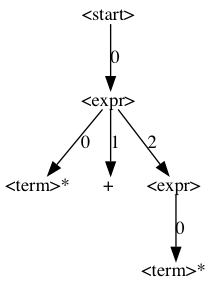

In [313]:
%top Da(Ft2)

In [314]:
# %%top
Fp2 = find_charecterizing_node(Ft2)
faulty2_grammar, faulty2_start  = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, Fp2, '2')

In [315]:
%top Gs(faulty2_grammar)

<start +F2> ::=
|    <expr +F2>
<expr +F2> ::=
|    <term +F2>
|    <term +F2> ' + ' <expr>
|    <term +F2> ' - ' <expr>
|    <term> ' + ' <expr +F2>
|    <term> ' + ' <expr L2_2>
|    <term> ' - ' <expr +F2>
<term +F2> ::=
|    <factor +F2>
|    <factor +F2> ' * ' <term>
|    <factor +F2> ' / ' <term>
|    <factor> ' * ' <term +F2>
|    <factor> ' / ' <term +F2>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr L2_2> ::=
|    <term>
<factor +F2> ::=
|    '(' <expr +F2> ')'
|    '+' <factor +F2>
|    '-' <factor +F2>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
10 39


In [316]:
#%%top
faulty2_fuzzer = LimitFuzzer(faulty2_grammar)
faulty2_parser = Parser(faulty2_grammar, canonical=True, start_symbol=faulty2_start)

In [317]:
#%%top
and1_grammar, and1_start = and_grammars(faulty1_grammar, faulty1_start, faulty2_grammar, faulty2_start)

In [318]:
%%top
Gs(and1_grammar)
and1_start

<start and(+F1,+F2)> ::=
|    <expr and(+F1,+F2)>
<expr and(+F1,+F2)> ::=
|    <term +F1> ' + ' <expr +F2>
|    <term +F1> ' + ' <expr L2_2>
|    <term +F1> ' - ' <expr +F2>
|    <term +F2> ' + ' <expr +F1>
|    <term +F2> ' - ' <expr +F1>
|    <term and(+F1,+F2)>
|    <term and(+F1,+F2)> ' + ' <expr>
|    <term and(+F1,+F2)> ' - ' <expr>
|    <term> ' + ' <expr and(+F1,+F2)>
|    <term> ' + ' <expr and(+F1,L2_2)>
|    <term> ' - ' <expr and(+F1,+F2)>
<term +F1> ::=
|    <factor +F1>
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor> ' * ' <term +F1>
|    <factor> ' / ' <term +F1>
<expr +F2> ::=
|    <term +F2>
|    <term +F2> ' + ' <expr>
|    <term +F2> ' - ' <expr>
|    <term> ' + ' <expr +F2>
|    <term> ' + ' <expr L2_2>
|    <term> ' - ' <expr +F2>
<expr L2_2> ::=
|    <term>
<term +F2> ::=
|    <factor +F2>
|    <factor +F2> ' * ' <term>
|    <factor +F2> ' / ' <term>
|    <factor> ' * ' <term +F2>
|    <factor> ' / ' <term +F2>
<expr +F1> ::=
|    <term

'<start and(+F1,+F2)>'

In [319]:
#%%top
and1_fuzzer = LimitFuzzer(and1_grammar)
and1_parser = Parser(and1_grammar, canonical=True, start_symbol=and1_start)

In [320]:
%%top
for i in range(10):
    s = and1_fuzzer.fuzz(key=and1_start)
    print(s)
    assert and1_parser.can_parse(s)
    assert faulty1_parser.can_parse(s)
    assert faulty2_parser.can_parse(s)

-(-((6 + 8.9) * 4) + -+4.3 / -1.1 * 9 / 8 + +0 * 4.6 + 4.1 / 3) / 7 * (--0 / +2.3 + (7) + 6) / +0 - +-9 * 253 * ---(8) - --+9.87 * -(9 + ((1.8)) / 6 - 3) - 6
+(-+5 * -4.0 + 8 - -7 * 7 * 0 * (5 + 5) / 0.8) * +-30 + +---+-3 + ++77.7 * +(5.3 - 5 - 9) / -(9.9) / 05.30 + +5 / +9 * +(5) / +7 - (4.5 / ((5.6)) / 8.5 + 0.2 - 9.3) * 2.0 / 7 * 5 * 6 - ++5.5 + (8) * 8 * 9 - 7.3
-+-++((8 + 9.7) - 4) * 8 - +-(+6 / 2 * 9) * +-03.389 / 5.01 - (1.84 / (0) * 7 * 4) * ((1)) / -19 * 9
+-(+-(6 + 5.9) / -4) + +++((7)) / (++0 / +8.7 / 7 - -9.8 / 5.7 * 0) - -+(8.4 * 5.0 - 2 + 4) * 7 * 9 / 49 + --+(2) * +94 * 6 * +3.4 / 5 * 7.0
--+---+(3 + 0) / 8 + -351 / (+(((7)) + 2.6) / 4 + -6.9 * 6.8 / 9.0 + 7.4 - 8.9 + 2.8) / -(4.9 - 3.4 + 1.5) / 5.8 - -(8 * 5.5 * 0.5 - 4.9 - 5 - 8) / ---2.4 * (8 + 3) / 30 + (9 / 4 * 1) - (7.2 + 8)
+((5 * 9.9 + 1.0 + 2) / 30.82 / (0) / 8 / 0.2 + +(3)) / +(16.0 / -9 / 2.6 * 7.2) - 3.57 / -((2.8))
-+-+-(3.3 - 9 + 3) + -(+-((7.8)) * -6.9 * 4.2 - 2 + 3.4 / 9.5 - 3.4 + 4.8) + 3 / 6 / ++9.8 / 5

## Disjunction

The idea here is to produce a merge of both grammars. Unlike in `and` where we combined each rule pair, we will simply add both rulesets. Note that there could be a large number of duplicate keys. This can be fixed by grammar GC.

The idea is simply using the distributive law. A definition is simply R1 `or` R2 `or` R3. Now, when you want to `or` two defintions, you have `or(A1 or B1 or C1, A2 or B2 or C2)` where `A1` etc are rules, then it simply becomes `A1 or B1 or C1 or A2 or B2 or C2`


In [321]:
EXCEPTION_HAPPENED

[]

In [322]:
def merge_similar_rules(rule1, rule2):
    assert normalized_rule_match(rule1, rule2), (rule1, rule2)
    new_rule = []
    refinements = []
    
    # note. This would not work with multi-nt-token rules.
    # so we need to restrict ourselves to grammars that only
    # allow a single token rule opposite start.
    assert len([t for t in rule1 if is_nt(t)]) == 1
    for t1,t2 in zip(rule1, rule2):
        if not is_nt(t1):
            new_rule.append(t1)
        elif is_base_key(t1) and is_base_key(t2):
            new_rule.append(t1)
        else:
            k = disj(t1, t2, simplify=True)
            new_rule.append(k)
            refinements.append((k,(t1, t2)))
    return new_rule, refinements
            

In [323]:
def merge_similar_rules_positions(rules):
    def rule_match(rule1, rule2):
        assert normalized_rule_match(rule1, rule2), (rule1, rule2)
        return [i for i, (k1, k2) in enumerate(zip(rule1, rule2)) if k1 != k2]

    def merge_rule_at_pos(rule1, rule2, pos):
        merged_key = disj(rule1[pos], rule2[pos])
        m_rule = [merged_key if i== pos else t for i,t in enumerate(rule1)]
        return m_rule, merged_key
        
    # these rules are from same key and have similar pattern as well as similar refinement positions.
    if len(rules) == 1: return rules, []
    cur_rule, *rules = rules
    new_rules, refs = merge_similar_rules_positions(rules)
    # now check if cur_rule matches any of the new_rules. If it doesn't then add to new_rule
    # if it does, merge to the newone.
    merged_rules = []
    found = False
    for nrule in new_rules:
        diffs = rule_match(cur_rule, nrule)
        if len(diffs) == 1:
            found = True
            mrule, ref = merge_rule_at_pos(cur_rule, nrule, diffs[0])
            refs.append(ref)
            merged_rules.append(mrule)
        else:
            assert len(diffs) != 0, ("no differences(%s)" % len(diffs))
            merged_rules.append(nrule)
    
    if not found:
        merged_rules += [cur_rule]
    return merged_rules, refs

What can be merged?
Only those rules that are

1. Exactly the same normalized rule
2. Has a single mergable (different) refinement.

i.e:

```
| <A 1> <B> <C>
| <A 2> <B> <C>
```
is mergable to 
```
| <A 1|2> <B> <C>
```
Similarly

```
| <A 1> <B 2> <C>
| <A 1> <B 3> <C>
```
is mergable to
```
| <A 1> <B 2|3> <C>
```

That is, it is ok to have multiple refinements in a rule so long as the other
refinements except for the merger one is exactly the same.

In [324]:
%%top
a1 = ['<A 1>', '<B>','<C>']
a2 = ['<A 2>', '<B>','<C>']
assert merge_similar_rules_positions([a1, a2])[0] == [['<A or(1,2)>', '<B>', '<C>']]

In [325]:
%%top
a3 = ['<A 1>', '<B 2>','<C>']
a4 = ['<A 1>', '<B 3>','<C>']
assert merge_similar_rules_positions([a3, a4])[0] == [['<A 1>', '<B or(2,3)>', '<C>']]

In [326]:
%%top
a5 = ['<A 1>', '<B 2>','<C 3>']
a6 = ['<A 1>', '<B 3>','<C>']
assert merge_similar_rules_positions([a5, a6])[0] == [['<A 1>', '<B 3>', '<C>'], ['<A 1>', '<B 2>', '<C 3>']]

In [327]:
def get_rules_with_similar_refinement_positions(rules):
    similar = {}
    # First get the positions of refinements
    for rule in rules:
        ref_positions = tuple([i for i,k in enumerate(rule) if is_nt(k) and refinement(k)])
        key = (tuple(rule_to_normalized_rule(rule)), ref_positions)
        if key not in similar: similar[key] = set()
        similar[key].add(tuple(rule))
    return similar

In [328]:
%top get_rules_with_similar_refinement_positions([a1, a2, a3, a4])

{(('<A>', '<B>', '<C>'), (0,)): {('<A 1>', '<B>', '<C>'),
  ('<A 2>', '<B>', '<C>')},
 (('<A>', '<B>', '<C>'), (0, 1)): {('<A 1>', '<B 2>', '<C>'),
  ('<A 1>', '<B 3>', '<C>')}}

In [329]:
def merge_disj_rules(g1):
    similar = {}
    # now we have similar rules that have a chance of merger.
    refinements = []
    new_grammar = {}
    for g_k in g1:
        similar = get_rules_with_similar_refinement_positions(g1[g_k])
        new_grammar[g_k] = []
        for rule_pos in similar:
            srules, refs = merge_similar_rules_positions([list(r) for r in similar[rule_pos]])
            # same key could come in multiple times.
            new_grammar[g_k].extend(srules)
            refinements.extend(refs)
    return new_grammar, refinements

In [330]:
def or_grammars_(g1, s1, g2, s2):
    g = {}
    # now get the matching keys for each pair.
    for k in list(g1.keys()) + list(g2.keys()): 
         g[k] = [[t for t in r] for r in list(set([tuple(k) for k in (g1.get(k, []) + g2.get(k, []))]))]
            
    g[disj(s1, s2)] = g1[s1] + g2[s2]
    g, refinements = merge_disj_rules(g)
    return g, disj(s1, s2), refinements

In [331]:
def or_grammars(g1, s1, g2, s2):
    g_, s, ref = or_grammars_(g1, s1, g2, s2)
    g = complete(g_, s)
    assert disj(s1, s2) == s
    assert s in g
    return g, s

In [332]:
#%top
or1_grammar, or1_start =  or_grammars(faulty1_grammar, faulty1_start, faulty2_grammar, faulty2_start)

In [333]:
%%top
Gs(or1_grammar)
or1_start

<start or(+F1,+F2)> ::=
|    <expr or(+F1,+F2)>
<expr or(+F1,+F2)> ::=
|    <term or(+F1,+F2)>
|    <term or(+F1,+F2)> ' + ' <expr>
|    <term or(+F1,+F2)> ' - ' <expr>
|    <term> ' + ' <expr or(+F1,+F2,L2_2)>
|    <term> ' - ' <expr or(+F1,+F2)>
<term or(+F1,+F2)> ::=
|    <factor or(+F1,+F2)>
|    <factor or(+F1,+F2)> ' * ' <term>
|    <factor or(+F1,+F2)> ' / ' <term>
|    <factor> ' * ' <term or(+F1,+F2)>
|    <factor> ' / ' <term or(+F1,+F2)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr or(+F1,+F2,L2_2)> ::=
|    <term or(+F1,+F2)>
|    <term or(+F1,+F2)> ' + ' <expr>
|    <term or(+F1,+F2)> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+F1,+F2,L2_2)>
|    <term> ' - ' <expr or(+F1,+F2)>
<factor or(+F1,+F2)> ::=
|    '(' <expr or(+F1,+F2,L1_1)> ')'
|    '+' <factor or(+F1,+F2)>
|    '-' <factor or(+F1,+F2)>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    

'<start or(+F1,+F2)>'

In [334]:
#%%top
or1_fuzzer = LimitFuzzer(or1_grammar)
or1_parser = Parser(or1_grammar, canonical=True, start_symbol=or1_start)

In [335]:
%%top
for i in range(10):
    s = or1_fuzzer.fuzz(key=or1_start)
    print(s)
    assert or1_parser.can_parse(s)
    if not faulty1_parser.can_parse(s):
        assert faulty2_parser.can_parse(s)
    elif not faulty2_parser.can_parse(s):
        assert faulty1_parser.can_parse(s)
    else:
        assert and1_parser.can_parse(s)

+----(5 - 5.7 + 5) + 037.0 / 779 - 13.8 * ++(2.9 - 0.0) * +-5 / +0 - -+81.72 * 6 + 16.70 / -+8 / -4.7 / 3.6 * 7 + 9.79 / -0.7 * 6 / 5.4
+((2) / (3) * (6.1) * 5 + (4 - 2) / -2.4 - 9 * 5 * 0) / 107.556 * 49 + -+(1.0 * 3.4) + -4.96 / +2 * 855.2 * 51.75 + +2.102 / --(4.1 + 8) * (9 + 2) * 1 / 7.4 / 6.3
6 / (-(3 + 4) + (6 - 1.9) + 0 + 3.9 / 7.3 + 8.8) * 116 * -34 * -+1 * -(8.8) - -0 * +6.6113 * 7.2 + (07.22 / +8.8 / 3) * (8.2 / 4.9 - (2.9 + 8) * 0) / 1.42 / ++3.0 * +5.1 / 7 * 7.3 + (1.8) * +-8 * 46.5 + +(1.3 + 4) - 5.11 * 2 * 7 / 2
35.1 / (-46.0 * +9.2 / +9.8 * 7.3 - (7.8) + 5 / 3) / 22 * --++3 / 8 * -+8 / 4 * 5.3 / 4 + -525.4 / +1502 / 9.5891 / -63.2 / -(5.1) * -4.9
-++-(0.3 * 8 + (4.2 + 3) / 4.1 - 6.8) / 5 + 1571.4
+(+28 + 09) * 16.0617 * (-9.7 / -7 - 4.3 + 5.2 + 1 + 2.1)
49.9 * -(5.52 * 2.9 / 1.8 + (3) / 5 * (6 + 1)) / --++3.3 * (2 / 3 * 5.8 + 8.7 / 6 - 7 + 3.3) / +5 * +(3.4) - 1.28 / 3 / (+4.8 / 0 / 6 + 6) * 8.08
-((5.5 / 6 - 0.8 - 4) / ((3.9)) * 8.4 * 2.9 / 8 + ++6.2 * -7.0 * 6.2) / +-(

## Negation (self)

In [336]:
EXCEPTION_HAPPENED

[]

Negation is approached in a fundamentally different way to inserting faults. First, we do not know what the key that when include, will cause the fault. So, there is no reachability check. On the other hand, we do know the prefix. It is the refinement of the _<start>_ symbol of the grammar to be negated.

What we need to do for any key is to negate it (consider that we do not have strict non-redundancy requirement between rules so long as they have same base pattern), which means negating the individual rules, we need to move from `neg(rule1 or rule 2 or rule3)` to `neg(rule1) and neg(rule2) and neg(rule3)` where the base patterns of three rules are same.

Now, how to negate a given rule: Take any given rule. All the base nonterminal symbols have to be negated in the sense that we have to somehow make them not reach the fault with the same prefix as `<start>`. This can be done using the reconstruct_key. Next, all refined symbols have to be negated against themselves.

In [337]:
%%top
def_F = [
 ['<T +F1>', ' + ', '<S>', '<Q>'],
 ['<T>', ' + ', '<S +F1>', '<Q>']]

In [338]:
%%top
ndef_F = [['<T neg(+F1)>', ' + ', '<S neg(+F1)>', '<Q>']]

In [339]:
%%top
ndef = normalize_grammar({'<x>': def_F})['<x>']

In [340]:
%top assert ndef == [('<T>', ' + ', '<S>', '<Q>')]

In [341]:
def find_base_and_refined_positions(refined_rule):
    refined_pos = []
    base_pos = []
    refinements = []
    for i, t in enumerate(refined_rule):
        if not is_nt(t):
            t_ = t # terminal
        elif is_base_key(t):
            t_ = t
            base_pos.append(i)
        elif is_refined_key(t):
            t_ = t
            refined_pos.append(i)
        else:
            assert False
    return base_pos, refined_pos

In [342]:
def negate_a_rule(refined_rule, log=False):
    _base_pos, refined_pos = find_base_and_refined_positions(refined_rule)
    refinements = []
 
    # now, take refined, one at a time, and negate them, while changing all other
    # refined to base.
    negated_rules = []
    for pos in refined_pos:
        new_rule = [negate_key(t) if pos == i else
                    (normalize(t) if i in refined_pos else t)
                    for i,t in enumerate(refined_rule)]
        negated_rules.append(new_rule)
        refinements.append(new_rule[pos])
    return negated_rules, refinements

Negation of `def_F[0]` should result in only the refined token being negated.

In [343]:
%%top
neg_def_F_0, rfs = negate_a_rule(def_F[0], ndef[0]);
assert neg_def_F_0 == [['<T neg(+F1)>', ' + ', '<S>', '<Q>']]

In [344]:
%%top
nndef_F_0, rfs = negate_a_rule(ndef_F[0], ndef[0])

In [345]:
%%top
assert nndef_F_0 == [['<T +F1>', ' + ', '<S>', '<Q>'],
                     ['<T>', ' + ', '<S +F1>', '<Q>']]

For negating a rule, we negate all base keys at the same time, but refined keys one at a time. This is because a rule could be like  `[<1,2,3,4,5>, <6,7,8,9,0>]` and a refinement could be `[<2,4>, <6,8,0>]`. The idea of negation of a rule is that a string that gets produced by the first should not be repeated in the second. Hence, the negation of this should be `[<1,2,3,4,5>, <7,9>] | [<1,3,5>, <6,7,8,9,0>]`. That is, refinement is removed in other refined keys.

In [346]:
def negate_ruleset(refined_rules, log=False):
    refinements = []
    # Given the set of fules, we take one rule at a time,
    # and genrate the negated ruleset from that.
    negated_rules = []
    if log: print('> refined:', len(refined_rules))
    for ruleR in refined_rules:
        neg_rules, refs = negate_a_rule(ruleR, log)
        negated_rules.append(neg_rules)
        refinements.extend(refs)
    return negated_rules, refinements

Negation of rule set should only affect the refined keys.

In [347]:
%%top
neg_def_F_rs, rfs = negate_ruleset(def_F)
assert neg_def_F_rs == [
    [['<T neg(+F1)>', ' + ', '<S>', '<Q>']],
    [['<T>', ' + ', '<S neg(+F1)>', '<Q>']]]

In [348]:
%%top
nndef_F, rfs = negate_ruleset(ndef_F)

In [349]:
%%top
assert nndef_F == [[['<T +F1>', ' + ', '<S>', '<Q>'],
                    ['<T>', ' + ', '<S +F1>', '<Q>']]]

In [350]:
def multi_and_rules(rules):
    r1 = [rules[0]]
    refinements = []
    if len(rules) == 1:
        return r1[0], []
    for r in rules[1:]:
        r1, refs = and_rules(r1, [r])
        assert len(r1) == 1
        refinements.extend(refs)
    assert len(r1) == 1
    return r1[0], refinements

Negate definition

In [351]:
def negate_definition(refined_rules, base_rules, log):
    new_rulesB = []
    new_refs = []
    refined_rulesets = get_rulesets(refined_rules)
    for base_rule in base_rules:
        # identify refined rules that match the base rule template
        refined_rules_p = refined_rulesets.get(tuple(base_rule), [])
        if not refined_rules_p:
            # if there are no matching refined rules, that means this base rule
            # was never used in the original grammar, hence it can be used in
            # negated grammar.
            new_rulesB.append(base_rule)
            continue
        
        neg_rulesB, refs1 = negate_ruleset(refined_rules_p, log)
        new_refs.extend(refs1)
        if log: print('negate_ruleset:', len(neg_rulesB))
 
        # Now, the idea is to do a `product` of each item in
        # neg_rulesB with every other item. Each item has multiple
        # rules in them, where one refinement is negated. So combining
        # that with others of similar kind using `and` should produce
        # a negated output.
        
        # Note that `refined_rules_p` are from the exact same pattern.
        # now, we have negations of all rules. We need to compute `and` of similar
        for m_rulesB in I.product(*neg_rulesB):
            r, ref = multi_and_rules(m_rulesB)
            new_rulesB.append(r)
            new_refs.extend(ref)
        
    return new_rulesB, new_refs

Negating the original rule should result in this.

In [352]:
%top neg_def_F, rfs = negate_definition(def_F, ndef, False)

In [353]:
%top neg_def_F

[['<T neg(+F1)>', ' + ', '<S neg(+F1)>', '<Q>']]

In [354]:
#assert neg_def_F == [['<T neg(+F1)>', ' + ', '<S>', '<Q>'],
#                     ['<T>', ' + ', '<S neg(+F1)>', '<Q>']]

base:
```
[(1|2) (1|2)]
```

refined:
```
[(1)  (1|2)]   --> 1,2
[(1|2) (1)     --> 1,1
```

negated:
```
[(2) (1|2)]
[(1|2) (2)     --> 1,2
```

In [355]:
%top assert neg_def_F == [['<T neg(+F1)>', ' + ', '<S neg(+F1)>', '<Q>']]

Now, negating the negation should result in the fault back

In [356]:
%top neg_neg_def_F, rfs = negate_definition(neg_def_F, ndef, True)

> refined: 1
negate_ruleset: 1


In [357]:
%top neg_neg_def_F

[['<T +F1>', ' + ', '<S>', '<Q>'], ['<T>', ' + ', '<S +F1>', '<Q>']]

IDEA: Do not and rules produced from exploding the same rule. Instead, pair them up.

In [358]:
%top def_F

[['<T +F1>', ' + ', '<S>', '<Q>'], ['<T>', ' + ', '<S +F1>', '<Q>']]

In [359]:
%%top
assert neg_neg_def_F == def_F

In [360]:
def negate_grammar_(refined_grammar, refined_start, base_grammar, base_start, log=False):
    combined_g = {**base_grammar, **refined_grammar}
    refinements = []
    for r_key in refined_grammar:
        if log: print('>>', r_key)
        if is_base_key(r_key): continue # negation of base key is empty set.
        dk = negate_key(r_key)
        if dk in combined_g: continue
        if log: print('gdefine[:', dk)
        nk = normalize(r_key)
        rules,refs = negate_definition(refined_grammar[r_key],
                                       base_grammar[nk], log)
        combined_g[dk] = rules
        if not rules: # no refinement
            if log: print('No rules for:', dk, 'O:', r_key, 'unreachable?')
            continue
        refinements.extend(refs)
        if log: print('gdefined]:', dk, combined_g[dk])
    return combined_g, negate_key(refined_start), refinements

In [361]:
def negate_grammar(rg, rs, bg, bs, log=False):
    g_, s, r = negate_grammar_(rg, rs, bg, bs, log)
    g = complete(g_, s)
    assert negate_key(rs) == s
    assert s in g
    return g, s

In [362]:
%%top
Gs(faulty1_grammar)

<start +F1> ::=
|    <expr +F1>
<expr +F1> ::=
|    <term +F1>
|    <term +F1> ' + ' <expr>
|    <term +F1> ' - ' <expr>
|    <term> ' + ' <expr +F1>
|    <term> ' - ' <expr +F1>
<term +F1> ::=
|    <factor +F1>
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor> ' * ' <term +F1>
|    <factor> ' / ' <term +F1>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor +F1> ::=
|    '(' <expr +F1> ')'
|    '(' <expr L1_1> ')'
|    '+' <factor +F1>
|    '-' <factor +F1>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<expr L1_1> ::=
|    <term L1_1>
<term L1_1> ::=
|    <factor L1_2>
<factor L1_2> ::=
|    '(' <expr> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
12 41


In [363]:
#%%top
# faulty1_grammar is an atleast one fault grammar.
negfaulty1_grammar, negfaulty1_start = negate_grammar(faulty1_grammar, faulty1_start, EXPR_GRAMMAR, EXPR_START)

In [364]:
%%top
Gs(negfaulty1_grammar)
negfaulty1_start

<start neg(+F1)> ::=
|    <expr neg(+F1)>
<expr neg(+F1)> ::=
|    <term neg(+F1)>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<term neg(+F1)> ::=
|    <factor neg(+F1)>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor neg(+F1)> ::=
|    '(' <expr and(neg(+F1),neg(L1_1))> ')'
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<expr and(neg(+F1),neg(L1_1))> ::=
|    <term and(neg(+F1),neg(L1_1))>
|    <term neg(+F1)> ' + ' <expr neg(+F1)>
|    <term neg(+F1)> ' - ' <expr neg(+F1)>
<integer> ::=
|    <digit>
|    <digit> <integer>
<term and(neg(+F1),neg(L1_1))> ::=
|    <factor and(neg(+F1),neg(L1_2))>
|    <factor neg(+F1)> ' * ' <term neg(+F1)>
|    <factor neg(+F1)> ' / ' <term neg(+F1)>
<factor and(neg(+F1),neg(L1_2))> ::=
|    '+' <factor neg(+F1)>
|    '-' <factor neg(+F1)>
|    <integer>
|    <integer> '.' <integer>
<digit> ::=
|    '0'
|    '1'

'<start neg(+F1)>'

In [365]:
#%%top
negfaulty1_fuzzer = LimitFuzzer(negfaulty1_grammar)
negfaulty1_parser = Parser(negfaulty1_grammar, canonical=True, start_symbol=negfaulty1_start)

In [366]:
%%top
for i in range(10):
    s = negfaulty1_fuzzer.fuzz(key=negfaulty1_start)
    print(s)
    assert negfaulty1_parser.can_parse(s)
    assert not faulty1_parser.can_parse(s)

(-5.3 / (0 * 0 - 4.5 - 0) / +8.6 * 1.1 * 0.0 * 5 - -(5 - 7) / -3.0 / +0 / 4 + 6 / -1.3 * 6) - +(++9 + 0.1) - +2.60 / 942 * 756 / 53.6 / (2) / 4 / 7.8 + (-6 / 9.5 * 6.2 + 1.9 + 7 + 3.8) * 6.0 - -(2.3 - 3.7) / 07 / (7.9) - ++6.4 - +9.4
5 / 211069.50
1 / 3722 / -20.62 * 73 / 1 - +2 * ++126 * --76 * -+2
+64
49 / 893 + 33.73 - (0.96 / 2 * 5.0 - (6) + 8.8 + 1.2 + 1) * 52.417 * (8.6 - 9.5 + 8.1) / -5 - -8.029 / 9.853 - -5 / 20
863.9 / -7.5 * (-5.4 / -6.9 * 5.5 * 8.8 + 1.0 + 7.4) - (-(2 - 6) + 59 * +6.0 * 0.8 / 6.2)
++9.81
-((0 * 7) - +-5.8 * 9.5 * 9) * --(4.9 - 4.1 / 8) + -(-1.6 / +0 * 4) - (18.1) * +252 * (2 - 0.0) * 86 / -3.5 / 4 * 1.8
2.09
+72.0 / 6.8 / --(2.1 + 8.7) / 2 * 9.2 / 3


In [367]:
%%top
v = '((1))'
assert not negfaulty1_parser.can_parse(v)

In [368]:
#%%top
negnegfaulty1_grammar, negnegfaulty1_start = negate_grammar(negfaulty1_grammar, negfaulty1_start, EXPR_GRAMMAR, EXPR_START)

In [369]:
%%top
Gs(negnegfaulty1_grammar)
negnegfaulty1_start

<start +F1> ::=
|    <expr +F1>
<expr +F1> ::=
|    <term +F1>
|    <term +F1> ' + ' <expr>
|    <term +F1> ' - ' <expr>
|    <term> ' + ' <expr +F1>
|    <term> ' - ' <expr +F1>
<term +F1> ::=
|    <factor +F1>
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor> ' * ' <term +F1>
|    <factor> ' / ' <term +F1>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor +F1> ::=
|    '(' <expr or(+F1,L1_1)> ')'
|    '+' <factor +F1>
|    '-' <factor +F1>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<expr or(+F1,L1_1)> ::=
|    <term +F1> ' + ' <expr>
|    <term +F1> ' - ' <expr>
|    <term or(+F1,L1_1)>
|    <term> ' + ' <expr +F1>
|    <term> ' - ' <expr +F1>
<term or(+F1,L1_1)> ::=
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor or(+F1,L1_2)>
|    <factor> ' * ' <term +

'<start +F1>'

In [370]:
#%%top
negnegfaulty1_fuzzer = LimitFuzzer(negnegfaulty1_grammar)
negnegfaulty1_parser = Parser(negnegfaulty1_grammar, canonical=True, start_symbol=negnegfaulty1_start)

In [371]:
%%top
assert negnegfaulty1_parser.can_parse('((1))')

In [372]:
%%top
assert not negnegfaulty1_parser.can_parse('1')

In [373]:
#%%top
negfaulty2_grammar, negfaulty2_start = negate_grammar(faulty2_grammar, faulty2_start, EXPR_GRAMMAR, EXPR_START)

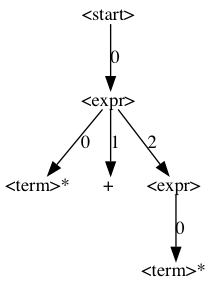

In [374]:
%top Da(Ft2)

In [375]:
%top Gs(faulty2_grammar)

<start +F2> ::=
|    <expr +F2>
<expr +F2> ::=
|    <term +F2>
|    <term +F2> ' + ' <expr>
|    <term +F2> ' - ' <expr>
|    <term> ' + ' <expr +F2>
|    <term> ' + ' <expr L2_2>
|    <term> ' - ' <expr +F2>
<term +F2> ::=
|    <factor +F2>
|    <factor +F2> ' * ' <term>
|    <factor +F2> ' / ' <term>
|    <factor> ' * ' <term +F2>
|    <factor> ' / ' <term +F2>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr L2_2> ::=
|    <term>
<factor +F2> ::=
|    '(' <expr +F2> ')'
|    '+' <factor +F2>
|    '-' <factor +F2>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
10 39


In [376]:
%%top
negfaulty2_fuzzer = LimitFuzzer(negfaulty2_grammar)
negfaulty2_parser = Parser(negfaulty2_grammar, canonical=True, start_symbol=negfaulty2_start)

In [377]:
%%top
for i in range(10):
    s = negfaulty2_fuzzer.fuzz(key=negfaulty2_start)
    print(s)
    assert negfaulty2_parser.can_parse(s)
    assert not faulty2_parser.can_parse(s)

9
8.7 * (+-(6) * (5) + 6.0 / +3 * 7 * 9.5 - -0 / 6.8 / 5 + 1.4 - 2.9 - 9.5) * -5 - -+-(4 - 6 + 4 - 5.1) * +-29.977 * -(3.7 * 9 - 3 - 1.8) / 9 - +(8 + 8 / 4.6 - 3 - 6.5) / (+7.0 / 7 + 6 / 0.9 + 7 + 0 - 8) / 67 * 31 * +9 + 284.465 * 33 / 50.1 * 8.4 + (8.8 / 0.7) * 6.7 / 0.9 * 2 * 8 + +4.2 + 4 - 5.5
4.633 / 71092 * 21.7 / 75 / 095.29 * +0.9 * -8.5 + ((1 / 8) - -(6)) + +(+0.9 * 4 * 3.0) + 30.6497 * 15 + 6.6 / +3.6 / 7 + (3.0 + 7 - 9.4) / 2.9 / 1.8 / 8.6 - -1.6 * 7 / 7.5 + 0.8 - 6 - 3.0
683 - 7 - ((3 - 6) / -6.6 * 0.2 + -7 / 9 + 9.3 / 6.9 - 3.7 - 3.1) / 445.1 / 14.73 / 77.4 * -5.9 / 7 * 0.4 + 6400 + -2.01 + 6.98 / +8 / 8.1 + 7.5 + 8 * 6.6 - 5.4 + 5.0 - 5.0
-9487 / 5 * ((8 + 8 - 7.0) / 9.4 * 5.2 * 3) / 40.55
324.0
-(1.160) / (5 / +(2.0) * -4 / 0.0 / 4) * +-(0.1)
816 / -5 / 886.4 * +9.3 * -4 * (8.3 - 4) - +9
+92.075 / 539857 / -52
+-7 * 6.8 * -3.5 - (045.1 * 89.37 / (6) - 3)


In [378]:
%%top
negfaulty3_grammar, negfaulty3_start = negate_grammar(and1_grammar, and1_start, EXPR_GRAMMAR, EXPR_START)

In [379]:
%%top
Gs(negfaulty3_grammar)
negfaulty3_start

<start or(neg(+F1),neg(+F2))> ::=
|    <expr or(neg(+F1),neg(+F2))>
<expr or(neg(+F1),neg(+F2))> ::=
|    <term and(neg(+F1),neg(+F2))> ' + ' <expr or(and(neg(+F1),neg(+F2)),and(neg(+F1),neg(+F2),neg(L2_2)),and(neg(+F2),neg(L2_2)))>
|    <term and(neg(+F1),neg(+F2))> ' + ' <expr or(and(neg(+F1),neg(+F2)),and(neg(+F1),neg(L2_2)),and(neg(+F2),neg(L2_2)),neg(+F1))>
|    <term and(neg(+F1),neg(+F2))> ' + ' <expr or(and(neg(+F1),neg(+F2),neg(L2_2)),and(neg(+F1),neg(L2_2)),and(neg(+F2),neg(L2_2)))>
|    <term and(neg(+F1),neg(+F2))> ' - ' <expr or(neg(+F1),neg(+F2))>
|    <term or(and(neg(+F1),neg(+F2)),neg(+F1))> ' + ' <expr or(and(neg(+F1),neg(+F2)),and(neg(+F1),neg(+F2),neg(L2_2)))>
|    <term or(and(neg(+F1),neg(+F2)),neg(+F1))> ' + ' <expr or(and(neg(+F1),neg(+F2)),and(neg(+F1),neg(+F2),neg(L2_2)),and(neg(+F1),neg(L2_2)),neg(+F1))>
|    <term or(and(neg(+F1),neg(+F2)),neg(+F1))> ' + ' <expr or(and(neg(+F1),neg(+F2),neg(L2_2)),and(neg(+F1),neg(L2_2)))>
|    <term or(and(neg(+F1),neg(+F2)

'<start or(neg(+F1),neg(+F2))>'

In [380]:
%%top
negfaulty3_fuzzer = LimitFuzzer(negfaulty3_grammar)
negfaulty3_parser = Parser(negfaulty3_grammar, canonical=True, start_symbol=negfaulty3_start)

In [381]:
%top is_cfg_empty(negfaulty3_grammar, negfaulty3_start)

False

In [382]:
%top assert negfaulty3_parser.can_parse('1')

In [383]:
%%top
for i in range(10):
    # this is negate and(faulty1, faulty2) == or(neg(faulty1), neg(faulty2))
    s = negfaulty3_fuzzer.fuzz(key=negfaulty3_start)
    print(s)
    assert negfaulty3_parser.can_parse(s)
    assert negfaulty1_parser.can_parse(s) or negfaulty2_parser.can_parse(s)
    assert not (faulty1_parser.can_parse(s) and faulty2_parser.can_parse(s))

9513.189 / 4.122
-(+6 / (7 + 4 + 3 - 5.3)) / +7.016 / --+1 * ---(8.8) / 1 - 40 + -4787.2 - -+8
(++7 * -+9.7 / 0 + +--9 * +7.6 * (3) / 3.5 * 2 - (6 + 1 - 4.3)) + (8 * 93 / 8 * 0 + +(1.6) / -5.4 + 9.6 - 5.2 * 9 - 4.2) * 5.5 * 798 - -3 / +8
+4232.5 + 5.17 - 62055 * -+(9.5 - 5) + -(5.3) / -4.79 + (5 * 6 - 7.1) + (2 + 1 + 8 - 5) * 3.6 / 0.6 + 2.7 + 4.8 * 8.3 + 8 + 7 - 2.8
(3 / 23 - +9.9 / +9 * -7.9 / 7.2 * 1.3 - (6.7 - 2) / (1) * 5.8 * 4.0 - -9.7 * 3 * 0) - +(++9 + +3 + 7 * 3 + 2 + 6.5 - 6) - 0.41 * ((0.0) * 5 / 4.7 - 9 + 8 - 2.6) + -(2 * 4 - 3.6 - 4) - -69 - -6 / -5 * 3
((-5.2 + 9.1 - 2)) / -((9) - 8 * 0) / 87 + 2.28 / 529 / (9.6 * 5.1 * 0.2) / 3 * 4 * (8) + +-(9 / 7.3 + 2.9 + 3 + 5 + 0 - 5.7) * 6.64 * 1.500 + 2 / -(8 + 4.3 - 5) * (1 + 0.0 - 4) * -2.8 - 9 / 1.75 + --8 / -2 + 7 / 6 + 3.3 / 5.3 + 0.7 - 7
(+88.31 * 5.8 / 77 * 0 * 0.7 / 3 - 4.47 / (0 + 3 + 9 - 3) * 7 - (2 - 0) * (8.8)) / (+--0.0) + (-81) - -(0 + 3.0 + 7.7 + 8.5 + 0 + 3.5 - 1) / +2.5 + (+4.9 * 0 / 9.8 + 6.8 / 5 + 4.5 + 8.8 - 8)

Tricks if undefined refinements remain: The references will be `and(,neg(...))` format, which means they are actually `neg(...)`. So, find `...` in the refined, and then go for a second round with that as the start key.

## Difference

Need to identify and remove duplicate keys. Note that our `partial orders` are still primitive. We now have the machinery to do it right.

In [384]:
EXCEPTION_HAPPENED

[]

In [385]:
def difference_grammars(grammarA, startA, grammarB, startB):
    if is_base_key(startB):
        return {'<start>': []}, '<start>' # empty
    base_g = normalize_grammar(grammarA)
    base_s = normalize(startA) 
    negB_g, negB_s, refs = negate_grammar_(grammarB, startB, base_g, base_s)
    negB_g = complete(negB_g, negB_s)
    AminusB_g, AminusB_s, refs = and_grammars_(grammarA, startA, negB_g, negB_s)
    AminusB_g = complete(AminusB_g, AminusB_s)
    return AminusB_g, AminusB_s

In [386]:
identify_partial_orders(or1_grammar)

{'<start>': ('<start or(+F1,+F2)>', []),
 '<expr>': ('<expr>',
  [('<expr or(+F1,+F2)>', [('<expr or(+F1,+F2,L2_2)>', [])])]),
 '<term>': ('<term>', [('<term or(+F1,+F2)>', [])]),
 '<factor>': ('<factor>', [('<factor or(+F1,+F2)>', [])]),
 '<integer>': ('<integer>', []),
 '<digit>': ('<digit>', [])}

Identifying partial orders is simple once you have the machinary for `and` and `neg`. To find if a given nonterminal `A` is more refined than `B`, do `A-B`. This should be empty.

In [387]:
def is_keyA_more_refined_than_keyB(keyA, keyB, porder, grammar):
    # essential idea of comparing two keys is this:
    # One key is smaller than the other if for any given rule in the first,
    # there exist another rule that is larger than that in the second key.
    # a rule is smaller than another if all tokens in that rule is either equal
    # (matching) or smaller than
    # the corresponding token in the other.
    
    A_B_g, A_B_s = difference_grammars(grammar, keyA, grammar, keyB)
    if is_cfg_empty(A_B_g, A_B_s): #A is smaller, so A-B should be empty.
        return True
    else:
        return False

In [388]:
def insert_into_porder(my_key, porder, grammar):
    def update_tree(my_key, tree, grammar):
        if tree is None: return True, (my_key, [])
        k, children = tree
        if is_base_key(my_key):
            if not is_base_key(k):
                return True, (my_key, [tree])
            else:
                return False, tree
 
        v = is_keyA_more_refined_than_keyB(my_key, k, porder, grammar)
        if is_base_key(k): v = True
        # if v is unknown...
        if v: # we should go into the children
            if not children:
                #print('>', 0)
                return True, (k, [(my_key, [])])
            new_children = []
            updated = False
            for c in children:
                u, c_ = update_tree(my_key, c, grammar)
                if u: updated = True
                new_children.append(c_)
            #print('>', 1)
            return updated, (k, new_children)
        else:
            v = is_keyA_more_refined_than_keyB(k, my_key, porder, grammar)
            if v:
                #this should be the parent of tree
                #print('>', 2)
                return True, (my_key, [tree])
            else:
                # add as a sibling -- but only if we have evidence.
                if v is not None:
                    #print('>', 3)
                    return True, (k, children + [(my_key, [])])
                else:
                    return False, tree
    key = normalize(my_key)
    updated, v = update_tree(my_key, porder.get(key, None), grammar)
    if updated:
        porder[key] = v
    return updated

In [389]:
#%%top
#identify_partial_orders(or1_grammar)

In [390]:
%%top
Gs(or1_grammar)
or1_start

<start or(+F1,+F2)> ::=
|    <expr or(+F1,+F2)>
<expr or(+F1,+F2)> ::=
|    <term or(+F1,+F2)>
|    <term or(+F1,+F2)> ' + ' <expr>
|    <term or(+F1,+F2)> ' - ' <expr>
|    <term> ' + ' <expr or(+F1,+F2,L2_2)>
|    <term> ' - ' <expr or(+F1,+F2)>
<term or(+F1,+F2)> ::=
|    <factor or(+F1,+F2)>
|    <factor or(+F1,+F2)> ' * ' <term>
|    <factor or(+F1,+F2)> ' / ' <term>
|    <factor> ' * ' <term or(+F1,+F2)>
|    <factor> ' / ' <term or(+F1,+F2)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr or(+F1,+F2,L2_2)> ::=
|    <term or(+F1,+F2)>
|    <term or(+F1,+F2)> ' + ' <expr>
|    <term or(+F1,+F2)> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+F1,+F2,L2_2)>
|    <term> ' - ' <expr or(+F1,+F2)>
<factor or(+F1,+F2)> ::=
|    '(' <expr or(+F1,+F2,L1_1)> ')'
|    '+' <factor or(+F1,+F2)>
|    '-' <factor or(+F1,+F2)>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    

'<start or(+F1,+F2)>'

In [391]:
%%top
Gs(and1_grammar)
and1_start

<start and(+F1,+F2)> ::=
|    <expr and(+F1,+F2)>
<expr and(+F1,+F2)> ::=
|    <term +F1> ' + ' <expr +F2>
|    <term +F1> ' + ' <expr L2_2>
|    <term +F1> ' - ' <expr +F2>
|    <term +F2> ' + ' <expr +F1>
|    <term +F2> ' - ' <expr +F1>
|    <term and(+F1,+F2)>
|    <term and(+F1,+F2)> ' + ' <expr>
|    <term and(+F1,+F2)> ' - ' <expr>
|    <term> ' + ' <expr and(+F1,+F2)>
|    <term> ' + ' <expr and(+F1,L2_2)>
|    <term> ' - ' <expr and(+F1,+F2)>
<term +F1> ::=
|    <factor +F1>
|    <factor +F1> ' * ' <term>
|    <factor +F1> ' / ' <term>
|    <factor> ' * ' <term +F1>
|    <factor> ' / ' <term +F1>
<expr +F2> ::=
|    <term +F2>
|    <term +F2> ' + ' <expr>
|    <term +F2> ' - ' <expr>
|    <term> ' + ' <expr +F2>
|    <term> ' + ' <expr L2_2>
|    <term> ' - ' <expr +F2>
<expr L2_2> ::=
|    <term>
<term +F2> ::=
|    <factor +F2>
|    <factor +F2> ' * ' <term>
|    <factor +F2> ' / ' <term>
|    <factor> ' * ' <term +F2>
|    <factor> ' / ' <term +F2>
<expr +F1> ::=
|    <term

'<start and(+F1,+F2)>'

In [392]:
EXCEPTION_HAPPENED

[]

## Exactly one fault grammar (complete)

In [393]:
def exactly_one_fault_grammar_(grammar, start_symbol, fault_node, f_idx, log=False):
    def L_prefix(i): return str(i)
    def F_prefix(i): return str(i)
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    assert key_f in grammar
    # First, get the pattern grammar

    fsym = to_fkey_prefix(key_f, prefix_f, FKey.exactly)
    atleast_fsym = to_fkey_prefix(key_f, prefix_f, FKey.atleast)
    noreaching_fsym = negate_key(atleast_fsym)
    
    pattern_g, pattern_s  = faulty_node_to_pattern_grammar(fault_node, prefix_l)
    npattern_g, npattern_s, refs  = negated_pattern_grammar(pattern_g, pattern_s, atleast_fsym, grammar, log)
    reachable_keys = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    exactly_g = keep_exactly_one_fault_at_grammar(grammar, key_f, prefix_f, reachable_keys)
    
    noreach_g = remove_all_instances_of_fault_from_grammar(grammar, key_f, prefix_f, reachable_keys)
    negation_connect = npattern_g[npattern_s] # get the negated pattern rule
    noreach_g[noreaching_fsym] = negation_connect
    
    for key in refs: assert key in noreach_g, key
    # now, the faulty key is an alternative to the original.
    # We have to take care of one thing though. The `fkey` in the linear grammar should
    # be replaced with fsym, but the definitions kept. This is because we want to preserve
    # the rule patterns. We do not want normal expansions to go through since it may mean
    # no fault inserted. However, we want self recursion to happen.
    pattern_rule = pattern_g[pattern_s][0]
    
    neg_pattern_rules, nrefs_ = negate_a_rule(pattern_rule)
    combined_grammar = {**grammar, **pattern_g, **npattern_g, **exactly_g, **noreach_g}

    reachable_pattern_rules = [r for r in combined_grammar[fsym] if normalized_rule_match(r, pattern_rule)]
    conjoined, crefs_ = conjoin_ruleset(reachable_pattern_rules, neg_pattern_rules)
    
    new_rules = ([r for r in combined_grammar[fsym]
                 if not normalized_rule_match(r, pattern_rule)]
                 + conjoined
                 + pattern_g[pattern_s])

    #combined_grammar[fsym].extend(new_rules)
    combined_grammar[fsym] = new_rules
    return combined_grammar, to_fkey_prefix(start_symbol, F_prefix(f_idx), FKey.exactly)

# Experiments

In [394]:
EXCEPTION_HAPPENED

[]

## Fault A (exactly 1)

In [395]:
#%%top
exprA_input = '((1))'
exprA_tree = list(expr_parser.parse(exprA_input))[0]

In [396]:
%top tree_to_str(exprA_tree)

'((1))'

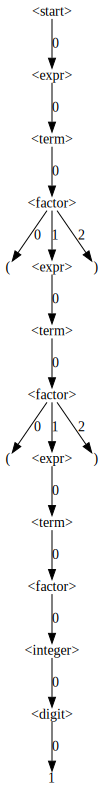

In [397]:
%top display_tree(exprA_tree)

In [398]:
#%%top
abs_path_A = [0,0,0,1,0,0,1]

In [399]:
%top Ns(exprA_tree, [abs_path_A])

<expr> 1


In [400]:
#%%top
FtA = mark_abstract_nodes(exprA_tree, [abs_path_A])

In [401]:
%top Ta(FtA)

'((<expr>))'

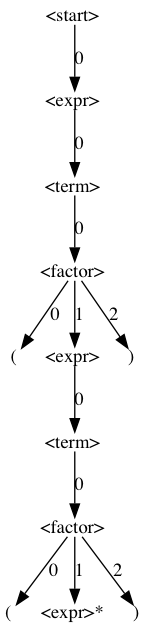

In [402]:
%top Da(FtA)

In [403]:
#%%top
FpA = find_charecterizing_node(FtA)
faultA_grammar, faultA_start = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpA, 'A')

In [404]:
%%top
Gs(faultA_grammar)
faultA_start

<start +FA> ::=
|    <expr +FA>
<expr +FA> ::=
|    <term +FA>
|    <term +FA> ' + ' <expr>
|    <term +FA> ' - ' <expr>
|    <term> ' + ' <expr +FA>
|    <term> ' - ' <expr +FA>
<term +FA> ::=
|    <factor +FA>
|    <factor +FA> ' * ' <term>
|    <factor +FA> ' / ' <term>
|    <factor> ' * ' <term +FA>
|    <factor> ' / ' <term +FA>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor +FA> ::=
|    '(' <expr +FA> ')'
|    '(' <expr LA_1> ')'
|    '+' <factor +FA>
|    '-' <factor +FA>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<expr LA_1> ::=
|    <term LA_1>
<term LA_1> ::=
|    <factor LA_2>
<factor LA_2> ::=
|    '(' <expr> ')'
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
12 41


'<start +FA>'

In [405]:
#%%top
faultA_fuzzer = LimitFuzzer(faultA_grammar)
faultA_parser = Parser(faultA_grammar, canonical=True, start_symbol=faultA_start)

In [406]:
%%top
for i in range(10):
    s = faultA_fuzzer.fuzz(key=faultA_start)
    print(s)
    assert faultA_parser.can_parse(s)

((-0.2 + 0.1 + 2.3 + 6.3)) + 0585 * +1024 + 10.3 / ((5) / 0.4 * 7.1 + 0.2 / 6.2) - (1 / 1 * 5 + 1 * 9) / 1.8 - 880.5
+-(80 + -1.3 - 8.0 / 7 + 2 - 3) * (0.7 / (6) + (6 + 1.0) + (0) / 1 / 8 - 0 - 4.4 - 1.0) / (9 / -2.5 + (3.0) * 8.9 * 7.0 - 3 * ((2)) * 1 - 1.9)
(--68 * 814 * -(0) / (0) / 5 / 4 - 86.3 / (1.6 + 4) * 3 * 2 - +(8) / 5 / 9 + 9.6 * 0.3 / 6.9 - 6.7 + 9 - 5) * -((6.4)) / (--7 - 3.2 + 7.9 * 9 - 2 - 2) / 37 - 3
810.36 / ((6.5 / 6 + 1.8 - 2.0) * (7 - 1) * -1.0 + -(6) - -9 * 1 * 3.1) / 4 - +(40.3 - (8.0) + 2.4 * 2.9 + 3.6 - 5.1) * -3 / -82 + (90 * -9.5 - (9.9) * ((8.9))) * 9 * 80 * +2 / 1.7 - 069.8 / ++5
+++(9.0 + 7 / 1 + 3.9 - ((9.2)) / 7.0 - 8) + ++97.0
--+((2)) / 5 * 380 - 939.1
-((7 + 4.4 - 2) - 4.45) / -(-(6.4) / +3.0) / (6.1 / +4 + +8 / ((4.2)) * 7.7) * +(5 * 3.7) / 8.51
-+(-(((3.6)) / 3.9 + 1) / 3.0) / (--9 / 3.76 - 4.58 * 1 / 0.8 * 5 + (3) / 1.6 * 8 - 6 / 4.5 - 3 + 5) * (72.48 / 7.3) * (4.0 * 1.3 / 4.6) / -(6) + -3 / -(5.7 * 9 - 4 * 7 + 1.0 + 4)
(+(((8.4))) * (7 * 7) / 0.54 

In [407]:
%top assert not faultA_parser.can_parse('1')

### neg(A)

In [408]:
#%%top
neg_A_grammar, neg_A_start = negate_grammar(faultA_grammar, faultA_start, EXPR_GRAMMAR, EXPR_START)

In [409]:
%%top
Gs(neg_A_grammar)
neg_A_start

<start neg(+FA)> ::=
|    <expr neg(+FA)>
<expr neg(+FA)> ::=
|    <term neg(+FA)>
|    <term neg(+FA)> ' + ' <expr neg(+FA)>
|    <term neg(+FA)> ' - ' <expr neg(+FA)>
<term neg(+FA)> ::=
|    <factor neg(+FA)>
|    <factor neg(+FA)> ' * ' <term neg(+FA)>
|    <factor neg(+FA)> ' / ' <term neg(+FA)>
<factor neg(+FA)> ::=
|    '(' <expr and(neg(+FA),neg(LA_1))> ')'
|    '+' <factor neg(+FA)>
|    '-' <factor neg(+FA)>
|    <integer>
|    <integer> '.' <integer>
<expr and(neg(+FA),neg(LA_1))> ::=
|    <term and(neg(+FA),neg(LA_1))>
|    <term neg(+FA)> ' + ' <expr neg(+FA)>
|    <term neg(+FA)> ' - ' <expr neg(+FA)>
<integer> ::=
|    <digit>
|    <digit> <integer>
<term and(neg(+FA),neg(LA_1))> ::=
|    <factor and(neg(+FA),neg(LA_2))>
|    <factor neg(+FA)> ' * ' <term neg(+FA)>
|    <factor neg(+FA)> ' / ' <term neg(+FA)>
<factor and(neg(+FA),neg(LA_2))> ::=
|    '+' <factor neg(+FA)>
|    '-' <factor neg(+FA)>
|    <integer>
|    <integer> '.' <integer>
<digit> ::=
|    '0'
|    '1'

'<start neg(+FA)>'

In [410]:
neg_A_fuzzer = LimitFuzzer(neg_A_grammar)
neg_A_parser = Parser(neg_A_grammar, canonical=True, start_symbol=neg_A_start)

`neg(A)` is the exact opposite in refinement of `A` which is exactly one fault. So it should produce either no fault or more than one fault.

In [411]:
%%top
assert neg_A_parser.can_parse('1')

In [412]:
%%top
assert not neg_A_parser.can_parse('((1))')

In [413]:
#%%top
#assert neg_A_parser.can_parse('((1)) + ((2))')

In [414]:
%%top
xp = {**neg_A_grammar, **{'<x>': [['<expr LA_1>']]}}

In [415]:
%%top
np = Parser(xp, canonical=True, start_symbol='<x>')

In [416]:
#%%top
#assert np.can_parse('(2)')

In [417]:
%%top
for i in range(10): # takes too long to generate
    s = neg_A_fuzzer.fuzz(key=neg_A_start)
    print(s)
    print('neg_faultA')
    assert neg_A_parser.can_parse(s)
    print('not faultA')
    assert not faultA_parser.can_parse(s)

((0 * 3 * 1.9 - 7.7) / +32 / ++5.8 / (0) + 3 + 0 + (3) * 5.8) / 1 * +5.45 + 40.46 / 8.0 / (7.8 / 7 / 6.8 + 3) * +7 * (3 + 1) - 0.3 / (+3.7 / 6.6 * 0) / (1 / 5.8 - 0.1) / 78.3 - --5.05 * --8.4 * 44 / +2
neg_faultA
not faultA
+-(-2 + 7 * 9 * 7 - 8.2) * (376.17 - 5 / +8 * 3 - 1.7 * 1.8 * 1) - 9.900 * 10.80 + -+-(1.0 - 0.0) * 1 * 4.5 * +(9.3) - (3.6 - 3.2 / 6 - 9.8 + 0.6) / +++6 / 92.67
neg_faultA
not faultA
(-(1 - 9) * (7.8) / 2.4 / -7.1 * 1 * 5.0 - (4.8 * 5.7 - 3 - 7) / 3.75 * (2) * 3.7 / 8) - (1.5 + 2.01 / 0.9 * 2)
neg_faultA
not faultA
((2 / 6 + 0) / 84 - +-3 * 9 / 2.0 / 6.0 / 8)
neg_faultA
not faultA
((-2.2 + 5.6 / 6.6 + 3.7) / -(5 + 9) / (9 - 6.5) + +9 + 64 - -8.5 * 6.7 + 7.3 + 6) / 7 * (0 / (8) / 5.7) * 5 / 56.6 / --2 + 5.90
neg_faultA
not faultA
(+-(0.0 + 4) / 9.1 * -+1.9 / +7.2 / 4.2 * 2) / (--(8.4) / (4.8 + 5.1) - +-9 / 8 + 9.8 * 4 / 2) * +0 * 4 / 086 * -+0.9 * (7) * 6.6 / 8 + (1 * (2 + 8))
neg_faultA
not faultA
--+767 * 489 * +6.2 * --++6.4 + 60.1 + +-++8 * 4 * (6 * 5.8 + 6) * (

## Fault B

In [418]:
EXCEPTION_HAPPENED

[]

In [419]:
exprB_input = '0 + 0'
exprB_tree = list(expr_parser.parse(exprB_input))[0]
tree_to_str(exprB_tree)

'0 + 0'

In [420]:
abs_path_B_a = [0,0]
abs_path_B_b = [0,2,0]

In [421]:
%%top
Ns(exprB_tree, [abs_path_B_a, abs_path_B_b])

<term> 0
<term> 0


In [422]:
FtB = mark_abstract_nodes(exprB_tree, [abs_path_B_a, abs_path_B_b])

In [423]:
%%top
Ta(FtB)

'<term> + <term>'

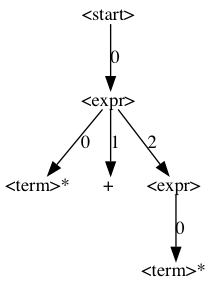

In [424]:
Da(FtB)

In [425]:
FpB = find_charecterizing_node(FtB)
faultB_grammar, faultB_start  = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpB, 'B')

In [426]:
%%top
Gs(faultB_grammar)
faultB_start

<start +FB> ::=
|    <expr +FB>
<expr +FB> ::=
|    <term +FB>
|    <term +FB> ' + ' <expr>
|    <term +FB> ' - ' <expr>
|    <term> ' + ' <expr +FB>
|    <term> ' + ' <expr LB_2>
|    <term> ' - ' <expr +FB>
<term +FB> ::=
|    <factor +FB>
|    <factor +FB> ' * ' <term>
|    <factor +FB> ' / ' <term>
|    <factor> ' * ' <term +FB>
|    <factor> ' / ' <term +FB>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr LB_2> ::=
|    <term>
<factor +FB> ::=
|    '(' <expr +FB> ')'
|    '+' <factor +FB>
|    '-' <factor +FB>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
10 39


'<start +FB>'

In [427]:
faultB_fuzzer = LimitFuzzer(faultB_grammar)
faultB_parser = Parser(faultB_grammar, canonical=True, start_symbol=faultB_start)

In [428]:
%%top
for i in range(1):
    s = faultB_fuzzer.fuzz(key=faultB_start)
    print(s)
    assert faultB_parser.can_parse(s)

73 / (+++8 / 98.8 + (8.1) * (6) - 8 * 6.8 / 9 - 8) + ++-53.5 + (-+6 / (2) / 4 * 4 - 6.6 * 2.0 * 0.7) * -770 * -(7 + 0.3)


In [429]:
%%top
assert not faultB_parser.can_parse('1 - 2')

### neg(B)

In [430]:
#%%top
neg_B_grammar, neg_B_start = negate_grammar(faultB_grammar, faultB_start, EXPR_GRAMMAR, EXPR_START)

In [431]:
%%top
Gs(neg_B_grammar)
neg_B_start

<start neg(+FB)> ::=
|    <expr neg(+FB)>
<expr neg(+FB)> ::=
|    <term neg(+FB)>
|    <term neg(+FB)> ' + ' <expr and(neg(+FB),neg(LB_2))>
|    <term neg(+FB)> ' - ' <expr neg(+FB)>
<term neg(+FB)> ::=
|    <factor neg(+FB)>
|    <factor neg(+FB)> ' * ' <term neg(+FB)>
|    <factor neg(+FB)> ' / ' <term neg(+FB)>
<expr and(neg(+FB),neg(LB_2))> ::=
|    <term neg(+FB)> ' + ' <expr and(neg(+FB),neg(LB_2))>
|    <term neg(+FB)> ' - ' <expr neg(+FB)>
<factor neg(+FB)> ::=
|    '(' <expr neg(+FB)> ')'
|    '+' <factor neg(+FB)>
|    '-' <factor neg(+FB)>
|    <integer>
|    <integer> '.' <integer>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
7 26


'<start neg(+FB)>'

In [432]:
neg_B_fuzzer = LimitFuzzer(neg_B_grammar)
neg_B_parser = Parser(neg_B_grammar, canonical=True, start_symbol=neg_B_start)

`neg(A)` is the exact opposite in refinement of `A` which is exactly one fault. So it should produce either no fault or more than one fault.

In [433]:
%%top
assert neg_B_parser.can_parse('1')

In [434]:
%%top
assert neg_B_parser.can_parse('((1))')

In [435]:
%%top
assert not neg_B_parser.can_parse('((1)) + ((2))')

In [436]:
%%top
assert neg_B_parser.can_parse('1 - 2')

In [437]:
%%top
assert not neg_B_parser.can_parse('1 + 2')

In [438]:
%%top
for i in range(10):
    s = neg_B_fuzzer.fuzz(key=neg_B_start)
    print(s)
    assert neg_B_parser.can_parse(s)
    assert not faultB_parser.can_parse(s)

-1 * 543.7 / -17 / -69.352 / (2 * 8 + 3.5 - 2.4)
+(1.1 + -5 / (6.9) * 2.8 * 4 + 0 + 2 * 6 + 9.2 + 8 - 0.8) / +-31.3 / ((5.1 + 3 - 5) * +2.4 / 9.9 / 1.9 - 5 + 3 * 6 - 7 - 3) * 810 * 8 * 05 * 6.8 / 3 * 0
-+(2 / 3.9 / 9 * 7.8 - 3.8 / 3.2 / 2.6 - 2) / 638.5 - (+-7 / 99 + +(8) / (2.2) - (3) * 5) / (-+2 / 1 * 5.9 * 5.1 + (6.4) + 4.6 / 6 - 1) - -356.7 / +0 * -77 / -+0 / (8.4)
+-+62 * -+(-2.1 / 6 / 8.4 + 4.7 + 2.9 + 7.0 - 9.7) / (-3 - (4) / 5.1 / 5.9 + 0.3 / 0.8 + 9.2 + 6.9 - 9.7) * +987.992 + 4109.3 * 8.4 / 62.2 / (5 / 4 - 8.9) * 00 * -7.8 / 1.2 / 4.3 - -(8 - 1 / 8.2) * -+2.8 / -(2 - 4) - 7954 * 178.9 * 20 * +5.8 + +01 * -(0) / 5 / 4.8 / 6.1 - 9 * (3) / 9.3 * 1.5
30.8 / 80.60
3 * --0.0 * (+-1.1 / +5 / 4 / 3) / ((7) * 4.4 - 6 / 7.8) - 9.4 / -(8 / 6.8 * 6.9) * (1 * 5.9 * 0.3 - 4 * 2.8 - 2) / -(0.8 + 0.8 - 6) - 64 / 81.04 / 65.4 - +(3.0 / 2) + (4 * 1.9 - 5) / --9 * 4.1 + (2 - 9) - 7 / 1 - 1.9 * 1 - 1.9 - 8
-11 / 3.06386 * +(3 * 9.2 * 5) * +7.44 * 4 * 88.3 - (--9.0 * 6.0 / -8.9 * 8.3 * 5 - 76 / (

## Fault C

In [439]:
EXCEPTION_HAPPENED

[]

In [440]:
exprC_input = '1 / 0'
exprC_tree = list(expr_parser.parse(exprC_input))[0]
tree_to_str(exprC_tree)

'1 / 0'

In [441]:
abs_path_C = [0,0, 0]

In [442]:
%%top
Ns(exprC_tree, [abs_path_C])

<factor> 1


In [443]:
FtC = mark_abstract_nodes(exprC_tree, [abs_path_C])

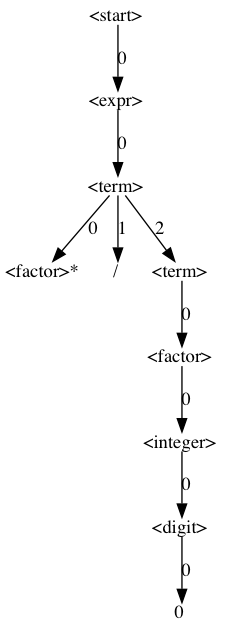

In [444]:
%%top
Da(FtC)

In [445]:
FpC = find_charecterizing_node(FtC)
faultC_grammar, faultC_start = atleast_one_fault_grammar(EXPR_GRAMMAR, EXPR_START, FpC, 'C')

In [446]:
%%top
Gs(faultC_grammar)
faultC_start

<start +FC> ::=
|    <expr +FC>
<expr +FC> ::=
|    <term +FC>
|    <term +FC> ' + ' <expr>
|    <term +FC> ' - ' <expr>
|    <term> ' + ' <expr +FC>
|    <term> ' - ' <expr +FC>
<term +FC> ::=
|    <factor +FC>
|    <factor +FC> ' * ' <term>
|    <factor +FC> ' / ' <term>
|    <factor> ' * ' <term +FC>
|    <factor> ' / ' <term +FC>
|    <factor> ' / ' <term LC_2>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor +FC> ::=
|    '(' <expr +FC> ')'
|    '+' <factor +FC>
|    '-' <factor +FC>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<term LC_2> ::=
|    <factor LC_1>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<factor LC_1> ::=
|    <integer LC_1>
<integer LC_1> ::=
|    <digit LC_1>
<digit LC_1> ::=
|  

'<start +FC>'

In [447]:
faultC_fuzzer = LimitFuzzer(faultC_grammar)
faultC_parser = Parser(faultC_grammar, canonical=True, start_symbol=faultC_start)

In [448]:
%%top
for i in range(10):
    s = faultC_fuzzer.fuzz(key=faultC_start)
    print(s)
    assert faultC_parser.can_parse(s)

((+9 - 5.2 - 7 + 2.1) * (7.2 / 2 + 9) + 467 / 9.2 * 9.9 - 33 * -5 + (1.7 / 0) * 5 * 1.3 + 3.6 * 5.1 - 9.4 - 1) * 353922 * 76926 * 0 * (7 * 7.6) / +-8.0
33.2 * --(+8.0 * 3.5) - +(-(3.2 / 0) + (2) / 3.7 - 3 + 2 - 8.5)
+684 / 0 - -0 * 0.63 / ++-6 * -(9.3 + 4)
90.4665 + 87 / 0
(2812 / -(3) * (6.9) - 49.6 + 7.4 / 2 * 2.9) + 857.9 / -5.84 - -(-8.8 * 1 + 3.3 / 9 - 1) / 0 - --(1) * +6 / (2.9) / +0.7 * 4 / 4.0
+(-3.41 * +4.6 + +7.8 / +4 / 2.7 * 0.8) / 0 + 02.27 / +(2.9 + 7) + +((9) * 5 * 4.4) * +(6.8 / 5.3) / 503 - +-02 / 0 * 0 - 96 * 79 * +9.2 * 3.6 / 8.6 + 8.27 / 4 * 2.3 * 8
(-+++0.0 + 5 - 05 * 5 * 1.6 / 8.0 - 9 * 7.7 * 4) * (0 / -(6.4) / +7 * 6.9 / 3 - 76.8 + 5.1 / 8.6 / 9) / (0 / 4) / 90.2 + +3.74060 * +1.4 * --+(8.8 / 0) + -945 + 56 + 769.1 - 4.4 / 6.4 / 0 + -4.9 * 1 * 9
+(-89 * --1.3 - 67.3 / +(6 / 0) * 4.9 - (8) / 6 * 1 - 9.4 - 0.8) - (8.5 + (0) * +5.7 / 6)
1 / 8.6 / 0 + +50527 + 1.4 / 47 * -(1 - 0) * +(8.6) * 2.2 * 4.7 / 5 + ((8) * 0.8 / 9 - 5 / 0.5) / (5.4 - 4 + 6) * -5.7 * (8) / 7.3 *

In [449]:
%%top
assert not faultC_parser.can_parse('1 - 2')

### neg(C)

In [450]:
#%%top
neg_C_grammar, neg_C_start = negate_grammar(faultC_grammar, faultC_start, EXPR_GRAMMAR, EXPR_START)

In [451]:
%%top
Gs(neg_C_grammar)
neg_C_start

<start neg(+FC)> ::=
|    <expr neg(+FC)>
<expr neg(+FC)> ::=
|    <term neg(+FC)>
|    <term neg(+FC)> ' + ' <expr neg(+FC)>
|    <term neg(+FC)> ' - ' <expr neg(+FC)>
<term neg(+FC)> ::=
|    <factor neg(+FC)>
|    <factor neg(+FC)> ' * ' <term neg(+FC)>
|    <factor neg(+FC)> ' / ' <term and(neg(+FC),neg(LC_2))>
<factor neg(+FC)> ::=
|    '(' <expr neg(+FC)> ')'
|    '+' <factor neg(+FC)>
|    '-' <factor neg(+FC)>
|    <integer>
|    <integer> '.' <integer>
<term and(neg(+FC),neg(LC_2))> ::=
|    <factor and(neg(+FC),neg(LC_1))>
|    <factor neg(+FC)> ' * ' <term neg(+FC)>
|    <factor neg(+FC)> ' / ' <term and(neg(+FC),neg(LC_2))>
<integer> ::=
|    <digit>
|    <digit> <integer>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<factor and(neg(+FC),neg(LC_1))> ::=
|    '(' <expr neg(+FC)> ')'
|    '+' <factor neg(+FC)>
|    '-' <factor neg(+FC)>
|    <integer neg(LC_1)>
|    <integer> '.' <integer>
<integer neg(LC_1)> ::=
|    <

'<start neg(+FC)>'

In [452]:
neg_C_fuzzer = LimitFuzzer(neg_C_grammar)
neg_C_parser = Parser(neg_C_grammar, canonical=True, start_symbol=neg_C_start)

`neg(A)` is the exact opposite in refinement of `A` which is exactly one fault. So it should produce either no fault or more than one fault.

In [453]:
%%top
assert neg_C_parser.can_parse('1')

In [454]:
%%top
assert neg_C_parser.can_parse('((1))')

In [455]:
%%top
assert not neg_C_parser.can_parse('((1)) / 0')

In [456]:
%%top
assert neg_C_parser.can_parse('1 - 2')

In [457]:
%%top
assert not neg_C_parser.can_parse('1 / 0')

## Conjunction

In [458]:
EXCEPTION_HAPPENED

[]

### A & B

In [459]:
AandB_grammar, AandB_start = and_grammars(faultA_grammar, faultA_start, faultB_grammar, faultB_start)

In [460]:
%%top
Gs(AandB_grammar)
AandB_start

<start and(+FA,+FB)> ::=
|    <expr and(+FA,+FB)>
<expr and(+FA,+FB)> ::=
|    <term +FA> ' + ' <expr +FB>
|    <term +FA> ' + ' <expr LB_2>
|    <term +FA> ' - ' <expr +FB>
|    <term +FB> ' + ' <expr +FA>
|    <term +FB> ' - ' <expr +FA>
|    <term and(+FA,+FB)>
|    <term and(+FA,+FB)> ' + ' <expr>
|    <term and(+FA,+FB)> ' - ' <expr>
|    <term> ' + ' <expr and(+FA,+FB)>
|    <term> ' + ' <expr and(+FA,LB_2)>
|    <term> ' - ' <expr and(+FA,+FB)>
<term +FA> ::=
|    <factor +FA>
|    <factor +FA> ' * ' <term>
|    <factor +FA> ' / ' <term>
|    <factor> ' * ' <term +FA>
|    <factor> ' / ' <term +FA>
<expr +FB> ::=
|    <term +FB>
|    <term +FB> ' + ' <expr>
|    <term +FB> ' - ' <expr>
|    <term> ' + ' <expr +FB>
|    <term> ' + ' <expr LB_2>
|    <term> ' - ' <expr +FB>
<expr LB_2> ::=
|    <term>
<term +FB> ::=
|    <factor +FB>
|    <factor +FB> ' * ' <term>
|    <factor +FB> ' / ' <term>
|    <factor> ' * ' <term +FB>
|    <factor> ' / ' <term +FB>
<expr +FA> ::=
|    <term

'<start and(+FA,+FB)>'

In [461]:
AandB_fuzzer = LimitFuzzer(AandB_grammar)
AandB_parser = Parser(AandB_grammar, canonical=True, start_symbol=AandB_start)

In [462]:
%%top
for i in range(10):
    s = AandB_fuzzer.fuzz(key=AandB_start)
    print(s)
    print('A&B')
    assert AandB_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('B')
    assert faultB_parser.can_parse(s)

((7.9 / 6 / 0.9 + 0 * 8 - 5.0 - 4.0) / 463.9 + (6.9 / 8) * 01 / (5.0) * 0.9 + 4 * 5.8 + 5.6 / 8 * 8.1 - 4) * +-24.48 / 7.0 / 42 + 7 * (--2.2 - -0.6 / 9.7 / 0 - ((4)) * 1.8 - 5.3 + 1)
A&B
A
B
7060.44 * +-7.6 * +(-7 * 1.3 - 2.6) / ((3.4) / 1.0 + 0.5 / 0.4 - 7.0 - 6.7) / ++7 * (3.0 - 4.3) / +7.9 / 6.0 - +229.0 / +((2.7)) / 4 + 06.1
A&B
A
B
-++-(6 / 4.6 - 0.1 - 6) + +++(5.6) - (26 * -4 / 5.4 / 2.5 - +0.5 + 8 / 0) - 8 * +--(0.9 + 1) / ((5.5)) * +2.4 * 3.4 / 1.5 - (5 * 4.0 - 5.3 + 9) + 16.12 / 7.9 - (3) * 5.2
A&B
A
B
+53693 / 4 / -0.4096 / 7512 * -0.7 / (9.1) * +0.2 - 627 * ((5) * (7) + 7.6 - 8 + 5.5 / (5 + 8.1) * 3.8 - 2) / 83.9 / (9 * 4 - 0 + 2.2) - (+(0) * (1) / 2.1 * 8.5 + 0.8 / 5 * 7 - 4.1 / ((8)) - 2) - 5 + 978 / +(8.5) / 9.6 * 5 * 3.2 + 1.6 / 3 * 7.6
A&B
A
B
8.6 - ++((1 + 9.1) - 2) / +527 + (+2) / -(4 + 9 - ((9)) * 2.3 - 9.1) * +1.26
A&B
A
B
(((2 + 3.6) / 7 - 2 * 6.5 + 3 - 9.0)) / ((2.6 + 4) / 69) - +(+(((2)) * 9) * 8.0 / 3 + +1 * 8.0 / 5 - 1.7 * 7.9 + 2 - 0.4) - 2 / 8 / (8 / 8 - 7 + 

### A & C

In [463]:
AandC_grammar, AandC_start = and_grammars(faultA_grammar, faultA_start, faultC_grammar, faultC_start)

In [464]:
%%top
Gs(AandC_grammar)
AandC_start

<start and(+FA,+FC)> ::=
|    <expr and(+FA,+FC)>
<expr and(+FA,+FC)> ::=
|    <term +FA> ' + ' <expr +FC>
|    <term +FA> ' - ' <expr +FC>
|    <term +FC> ' + ' <expr +FA>
|    <term +FC> ' - ' <expr +FA>
|    <term and(+FA,+FC)>
|    <term and(+FA,+FC)> ' + ' <expr>
|    <term and(+FA,+FC)> ' - ' <expr>
|    <term> ' + ' <expr and(+FA,+FC)>
|    <term> ' - ' <expr and(+FA,+FC)>
<term +FA> ::=
|    <factor +FA>
|    <factor +FA> ' * ' <term>
|    <factor +FA> ' / ' <term>
|    <factor> ' * ' <term +FA>
|    <factor> ' / ' <term +FA>
<expr +FC> ::=
|    <term +FC>
|    <term +FC> ' + ' <expr>
|    <term +FC> ' - ' <expr>
|    <term> ' + ' <expr +FC>
|    <term> ' - ' <expr +FC>
<term +FC> ::=
|    <factor +FC>
|    <factor +FC> ' * ' <term>
|    <factor +FC> ' / ' <term>
|    <factor> ' * ' <term +FC>
|    <factor> ' / ' <term +FC>
|    <factor> ' / ' <term LC_2>
<expr +FA> ::=
|    <term +FA>
|    <term +FA> ' + ' <expr>
|    <term +FA> ' - ' <expr>
|    <term> ' + ' <expr +FA>
|    <

'<start and(+FA,+FC)>'

In [465]:
AandC_fuzzer = LimitFuzzer(AandC_grammar)
AandC_parser = Parser(AandC_grammar, canonical=True, start_symbol=AandC_start)

In [466]:
%%top
for i in range(10):
    s = AandC_fuzzer.fuzz(key=AandC_start)
    print(s)
    print('A&C')
    assert AandC_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('C')
    assert faultC_parser.can_parse(s)

++++(6.8 * 9.1 + 8 / 0 + 6) * (-(1 - 9) / +5.6 * (2.6) * 5 / 1) / -(7.9 * 5 / 9 + 0 * 2 + 9.0) + -+-((3)) / +-99.35 * (7 / 6 - 2 / 3.2) / (1 * 8 + 5 - 3) * 0.1 / +6 - +66.06 + ++(6 + 8.0) / 03.5 / (4.1 - 9.3) / 4.8 - --(7.8) - -+0 / -9.8 * 4.7 / 0 + +0.9 / 1.8 + 3.6 + 2.6 + 1
A&C
A
C
(7 * (0 / 8 + 1.2) * 29 / 1.7 / 3 / 2.5) / ((1 * 7 - 7)) / (+(5.0) / -5 + (6.5) - 0.8 + 0.6) - -((4 - 9) / +1 * (5 / 0 - 8.7) / 0 + 4.7 + 3 * 1 + 2 - 6.8) / +8.5 * ++-2 / (1.4 * 3) / -3.9 + 3 * 5 / -+9.4 * --3 - +940 - 968.62 / +(3) / -8 * 6 * 6 - -+2.1 - 4.9 * 5 * 5
A&C
A
C
-(+29.1 / -(1.6 / 0 + 4) * (5) * 0.8 * 9.3) * +50.67 * ((7 - 5) * +7.3 / 6 + 3 - 2 / 9.1) - -+(7.2 / 4 / ((2)) - 3 / 0 - 6 - 5.6) / 0.2 / 7.5
A&C
A
C
++-(-7.7 / ((5))) / 37784 / -++-5 * 5 / -+-(2.7 / 0) / +8.6 - (+(3) * +1) / (-+9.1 / +8 / 7 / 7.1 + -0 + 3.5 + 5) / (-0) * --7.6 * (8.1) / (6) / 4.4 / 2 - ++210 * 26.64 * +-0 * +-6 + 5.9 / -4.82 + 5 + 5.5 / -4 * 8.6
A&C
A
C
--(+6.2 + -6 - 0 / 0 + 1 - 2.3 / 0 - 2) / 11069 + -07 * +(-7.2 + 

### B & C

In [467]:
BandC_grammar, BandC_start = and_grammars(faultB_grammar, faultB_start, faultC_grammar, faultC_start)

In [468]:
%%top
Gs(BandC_grammar)
BandC_start

<start and(+FB,+FC)> ::=
|    <expr and(+FB,+FC)>
<expr and(+FB,+FC)> ::=
|    <term +FB> ' + ' <expr +FC>
|    <term +FB> ' - ' <expr +FC>
|    <term +FC> ' + ' <expr +FB>
|    <term +FC> ' + ' <expr LB_2>
|    <term +FC> ' - ' <expr +FB>
|    <term and(+FB,+FC)>
|    <term and(+FB,+FC)> ' + ' <expr>
|    <term and(+FB,+FC)> ' - ' <expr>
|    <term> ' + ' <expr and(+FB,+FC)>
|    <term> ' + ' <expr and(+FC,LB_2)>
|    <term> ' - ' <expr and(+FB,+FC)>
<term +FB> ::=
|    <factor +FB>
|    <factor +FB> ' * ' <term>
|    <factor +FB> ' / ' <term>
|    <factor> ' * ' <term +FB>
|    <factor> ' / ' <term +FB>
<expr +FC> ::=
|    <term +FC>
|    <term +FC> ' + ' <expr>
|    <term +FC> ' - ' <expr>
|    <term> ' + ' <expr +FC>
|    <term> ' - ' <expr +FC>
<term +FC> ::=
|    <factor +FC>
|    <factor +FC> ' * ' <term>
|    <factor +FC> ' / ' <term>
|    <factor> ' * ' <term +FC>
|    <factor> ' / ' <term +FC>
|    <factor> ' / ' <term LC_2>
<expr +FB> ::=
|    <term +FB>
|    <term +FB> ' + 

'<start and(+FB,+FC)>'

In [469]:
BandC_fuzzer = LimitFuzzer(BandC_grammar)
BandC_parser = Parser(BandC_grammar, canonical=True, start_symbol=BandC_start)

In [470]:
%%top
for i in range(10):
    s = BandC_fuzzer.fuzz(key=BandC_start)
    print(s)
    print('B&C')
    assert BandC_parser.can_parse(s)
    print('B')
    assert faultB_parser.can_parse(s)
    print('C')
    assert faultC_parser.can_parse(s)

+(-(6.0) * -2 * -6.2 / 7 / 6.4) - (+-9.7 * +2.4 - ++7 / 0 + -3.9 * 2) * (+-8.2 / 0 / 8 - 7 * 3.9 / 4 - 5 * 1.9) / -+77 + 42.53 * 8.8
B&C
B
C
+++(-3.1 / 0 + 5) + 8 * 8 / 9 * 07 / 5 + -(-9 / 7 / (5 + 5) / 6.4) * +-(3) / -(5.6 - 8.1) * +(5.2) / (5.0) / 9 / 1.4 - -(3 + 4 + 0.5) * -89 + +7 + 4
B&C
B
C
09773.5 - 7.6 + 1.7 * -+-+(0.4 / 0 + 2) + +4
B&C
B
C
-(+-3 / +9 / -2.1) / (+++(9.0 + 2) * 45.40 * -6 * 1 * 2.6 + -1.7 / +2 / 6.3 * 2 + 1 * 8 / 5.2 + 0.4) + 54978.8 / -62 + ((1 - 1) + +8.5 - 3.6 / 0 + 6.1 - 8.8 / 0 - 0.5) / 4417 - -+-+9.8 * ---8.6 * +6 * 5 * 9 * 3.7 + --3.5 / --2 * +1 / 6.3 / 2.7
B&C
B
C
(-50.425 + (6.6 * (7.4 + 5.7) - 4 - 3.1) / 5.6 * -8 / 7.1 * 0 + 2 * 0.0 / 5.2 + (4.5) + 8.7 * 3.0 + 1.1 + 4) + 88 * 8 * --(3 / 0 + 0.0) * (2.6 / 7)
B&C
B
C
-(((8 / 0 + 4) * 3) / -6 * -3.9 * 2.5 / 9 - (4.8) / +0 * 3 * 3 + -6.8 / 0.4 * 9) * +++(1.5 * 8 - 8 + 2 + 7)
B&C
B
C
7.19 / 9 * 8 - (71 / (7 + 7 + 1) / 4.2 / 5) + -+--+(3 / 0 - 7.3) * 46.65 * ++-4 - 68.1087 / -++2.1 / 9 + -78.0 - 6 * -6 * 4 /

## Disjunction

In [471]:
EXCEPTION_HAPPENED

[]

### A | B

In [472]:
AorB_grammar, AorB_start = or_grammars(faultA_grammar, faultA_start, faultB_grammar, faultB_start)

In [473]:
%%top
Gs(AorB_grammar)
AorB_start

<start or(+FA,+FB)> ::=
|    <expr or(+FA,+FB)>
<expr or(+FA,+FB)> ::=
|    <term or(+FA,+FB)>
|    <term or(+FA,+FB)> ' + ' <expr>
|    <term or(+FA,+FB)> ' - ' <expr>
|    <term> ' + ' <expr or(+FA,+FB,LB_2)>
|    <term> ' - ' <expr or(+FA,+FB)>
<term or(+FA,+FB)> ::=
|    <factor or(+FA,+FB)>
|    <factor or(+FA,+FB)> ' * ' <term>
|    <factor or(+FA,+FB)> ' / ' <term>
|    <factor> ' * ' <term or(+FA,+FB)>
|    <factor> ' / ' <term or(+FA,+FB)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr or(+FA,+FB,LB_2)> ::=
|    <term or(+FA,+FB)>
|    <term or(+FA,+FB)> ' + ' <expr>
|    <term or(+FA,+FB)> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+FA,+FB,LB_2)>
|    <term> ' - ' <expr or(+FA,+FB)>
<factor or(+FA,+FB)> ::=
|    '(' <expr or(+FA,+FB,LA_1)> ')'
|    '+' <factor or(+FA,+FB)>
|    '-' <factor or(+FA,+FB)>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    

'<start or(+FA,+FB)>'

In [474]:
AorB_fuzzer = LimitFuzzer(AorB_grammar)
AorB_parser = Parser(AorB_grammar, canonical=True, start_symbol=AorB_start)

In [475]:
%%top
for i in range(10):
    s = AorB_fuzzer.fuzz(key=AorB_start)
    print(s)
    print('A|B')
    assert AorB_parser.can_parse(s)
    assert faultA_parser.can_parse(s) or faultB_parser.can_parse(s)

(((4.3) + 3 / 8 - 6 - 9.8) * +0 + (5.5 / 2) * (6.3) - ++2.1 * -9.4 / 3 / 7.8 - (5) / 4.3 * 9.0 + 3.6 * 1) + +3 * -++((4.0)) * +0 / 8 / 5 - 76 * 0078 / (9.9 / 8 + 8 - 4)
A|B
(-(0.5 / 2.3 - 2.1 - 2.0) - ++-5 + -5 * (7.5)) - 0 / (95.6 / -(6 + 3) / 8 - +0 / 4.8 * 7 - 5 * 4.1 - 9) * +460.7 * 3 * -9 + 37.633 - -(6.2) - +77.6 + 2.7 / 6.5 * 7 - +8 - 2
A|B
2 * -78.2 - ---6 * +((1 + 4.9) * 2 * 9.0 - 8.9 / 5 + 7.5) / ++++4 - 8.6 / (+2.0 / 7.1 / 5.2 + 3 / 8.0 - 3.1) * -+(5.3) * ++0.1 * 8.1 / 7.0 + +9 / +--2.8 + --+0.7 * 3 + 0 / 9 / 5
A|B
--+-++(8 + 0) * (9.9 * (9.9 - 2) * +3 * 1.3 - (5.8 + 1.4) * +8.7 * 2.3 * 5 - (3.6) + 9.2 * 2.1) / +2.0 + (-(5) * --9 * 3 / 6.7 * 5 - -(0.0) * (4) * 4.3 * 8.7 - -6.4) / (1 * +3 - 1) / -(3.7 + 3) + --8
A|B
(+78 * 964 + (3 * 0.7 + 0.8 + 1.8) / 0) * (--0 + (3 - 3.5) * +9 - 2.0 / 6.6 * 6 - 1.4 - 6.0) / 90.8806 / -+++1 / +++9 * --3 - 9 * +-+--(7.5 + 9.6) * +-46 / -24.6 / -4 * +7 / 5 * 4 - ---(3 - 5)
A|B
--((2.3 - 8) / 0 / 7 / 4 + +9.8 * 7 / 0.9 + 1 * 7 - 0) / +9.11 + +4

### A | C

In [476]:
AorC_grammar, AorC_start = or_grammars(faultA_grammar, faultA_start, faultC_grammar, faultC_start)

In [477]:
%%top
Gs(AorC_grammar)
AorC_start

<start or(+FA,+FC)> ::=
|    <expr or(+FA,+FC)>
<expr or(+FA,+FC)> ::=
|    <term or(+FA,+FC)>
|    <term or(+FA,+FC)> ' + ' <expr>
|    <term or(+FA,+FC)> ' - ' <expr>
|    <term> ' + ' <expr or(+FA,+FC)>
|    <term> ' - ' <expr or(+FA,+FC)>
<term or(+FA,+FC)> ::=
|    <factor or(+FA,+FC)>
|    <factor or(+FA,+FC)> ' * ' <term>
|    <factor or(+FA,+FC)> ' / ' <term>
|    <factor> ' * ' <term or(+FA,+FC)>
|    <factor> ' / ' <term or(+FA,+FC,LC_2)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<factor or(+FA,+FC)> ::=
|    '(' <expr or(+FA,+FC,LA_1)> ')'
|    '+' <factor or(+FA,+FC)>
|    '-' <factor or(+FA,+FC)>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    '-' <factor>
|    <integer>
|    <integer> '.' <integer>
<term or(+FA,+FC,LC_2)> ::=
|    <factor or(+FA,+FC)> ' * ' <term>
|    <factor or(+FA,+FC)> ' / ' <term>
|    <factor or(+FA,+FC,LC_1)>
|    <factor> ' * ' <te

'<start or(+FA,+FC)>'

In [478]:
AorC_fuzzer = LimitFuzzer(AorC_grammar)
AorC_parser = Parser(AorC_grammar, canonical=True, start_symbol=AorC_start)

In [479]:
%%top
for i in range(10):
    s = AorC_fuzzer.fuzz(key=AorC_start)
    print(s)
    print('A|C')
    assert AorC_parser.can_parse(s)
    assert faultA_parser.can_parse(s) or faultC_parser.can_parse(s)

+88.2 - ---((8 / 0 - 3.1) * 2.4 - 5 + 8.8) / ((8 - 7.8) * +5.2 - 4 * 8.9 / 6 + 0 / 8 - 9 + 3)
A|C
1.3 * (93.677 * 26.9 * (6.4) / 0 / 1.0 - +7 / 1 / 9 / 2.4 + (2) + 6.4 * 9.2 + 8 - 0) / 89.7 / 3 - --+(0.4 * 1 / 0 + 0.9 + 8) / (+6 / (5.9) / 4.9 / 6.0 - (1) * 3 / 0 - 3 - 2.8) * 85.133 * ++(8) + 1.21 * +1.7 * -96
A|C
5 * (--9.5 / (8.4 + 9.6 / 0 + 7) * 3 * 4 / 1 - -2.9 / 5) + -+51.2 * (1) * -(0 - 6.1) + 16 / 1.6 / --9 * 3.1 - +9 * 9 / (2 + 8) / (0.7) + 8 * (8.2) * (1.1) * 0 / 6.2 + +1
A|C
(-396.40 / 0 - 696 * ++(3 / 0) * 1 / 9 + -(6) + -0.4 - 8.7 / 1.5 - 6.3 - 7.5) + (354 * -5.3) - 02 - (2.6 / 2.6) - 2 * -+8 * 1 * 1 * 3.6
A|C
(-++-6.9 - +00 * (9.2 + 6) * -9.1 + (4) - 7 * 5 + 2.7 * 7.4 + 5.9) / (--7 * -9 + (6 + 5.7) / -(8 / 0 - 7) * 1 + 4.5 * 6.4 + 9.6 / 0.4) + ((0 * 3.4) * (7.0 - 4.2) * -1 / 9) - ++8.20 * +-+6.2 / (3.5 / 9 + 9) / (3.8 - 4.0) + --(2) - 04 / -+7.4 * -8.9 + 4 - -4 / 5.0 / 4 + 8.1 / 2
A|C
++(-+(2 / 0 - 5.5) * (1) * 9.4 / 7.9 - 6 / 2.5) * (55) + 76 * (4.22 / 6 * 8) / (2.1)
A|C
(

### B | C

In [480]:
BorC_grammar, BorC_start = or_grammars(faultB_grammar, faultB_start, faultC_grammar, faultC_start)

In [481]:
%%top
Gs(BorC_grammar)
BorC_start

<start or(+FB,+FC)> ::=
|    <expr or(+FB,+FC)>
<expr or(+FB,+FC)> ::=
|    <term or(+FB,+FC)>
|    <term or(+FB,+FC)> ' + ' <expr>
|    <term or(+FB,+FC)> ' - ' <expr>
|    <term> ' + ' <expr or(+FB,+FC,LB_2)>
|    <term> ' - ' <expr or(+FB,+FC)>
<term or(+FB,+FC)> ::=
|    <factor or(+FB,+FC)>
|    <factor or(+FB,+FC)> ' * ' <term>
|    <factor or(+FB,+FC)> ' / ' <term>
|    <factor> ' * ' <term or(+FB,+FC)>
|    <factor> ' / ' <term or(+FB,+FC,LC_2)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr or(+FB,+FC,LB_2)> ::=
|    <term or(+FB,+FC)>
|    <term or(+FB,+FC)> ' + ' <expr>
|    <term or(+FB,+FC)> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+FB,+FC,LB_2)>
|    <term> ' - ' <expr or(+FB,+FC)>
<factor or(+FB,+FC)> ::=
|    '(' <expr or(+FB,+FC)> ')'
|    '+' <factor or(+FB,+FC)>
|    '-' <factor or(+FB,+FC)>
<factor> ::=
|    '(' <expr> ')'
|    '+' <factor>
|    

'<start or(+FB,+FC)>'

In [482]:
BorC_fuzzer = LimitFuzzer(BorC_grammar)
BorC_parser = Parser(BorC_grammar, canonical=True, start_symbol=BorC_start)

In [483]:
%%top
for i in range(10):
    s = BorC_fuzzer.fuzz(key=BorC_start)
    print(s)
    print('B|C')
    assert BorC_parser.can_parse(s)
    assert faultB_parser.can_parse(s) or faultC_parser.can_parse(s)

+(-0.4 / -(8) * +5.3) / (+6.59 * -2.7 * +3 * 5 * 1.2) / -307 / (-5.1 * 8 / 0 + 5) / 0.9 / (5.2 + 0) * +2.3 / 9 + --+8 - +(+7.5 / 5.4 * 4.6) / -(6 / 9.1) - 4 * (3.5 + 5) / 4
B|C
--+(0 * 3.7 * 4 - 3.1 + 4.4 / 0 - 0) + (-75.5 / +(3.1) + 54 / -2 - +8 / 5 / 5 - 7.6 * 2.7 + 1.5 + 6) - (4) / --7.96 / -6 * 93 / +0.6 + 48 - 67.0
B|C
+7 * +-+((4.4 + 8) / 0.9 + 1 + 0) / (+5.0 / 2.6 + 4 * 2.5) / -6 / 58 * 63.39 / +9.8 / 4 * 1.9 + +637 - (-(4.4) - +9) * -(6.3 - 9 - 2.1) * 2 - 85.1800 + 719.669 / (5.5) * 1.4 + 6.4 / 0.6 * 1 / 5
B|C
-(621 / 69.64 / 3 - --4.0 * 1 * 6.6 * 1.7) * +-+((5 / 0) / 4 - 1 - 1)
B|C
+936 - 7.8 + (-(0 + 8.0) * 4) - ++++5 + -++8.9 / --9 / 6.5 * 2 - 34.2
B|C
+(05 * 52 * -4.5 - ++3 * -7 + -2 * 3.9) * +57.8
B|C
(-+9.3 - 7.177 * 08 / +(8.3 / 0) * 2 * 3.5) - --6971 * 9.0 / +84.96 * -+8.4 + +387 / 9.5 / 6.27 * 9.8 - (0 * 4.0 / 6.7) - +-6.4 / 0.8 - 54.0 - 0 + 5.7 + 2.8
B|C
(3.09 / 45 * 30.96 * 5.6 * 4 * 9.8 - --2.1 + +-(9 / 0) / -0.8 * 2 - -6.4 * 5.2 / 1 - 1.4 * 8) * 6 / 2085.55 / (1.1 

## Negation

In [484]:
EXCEPTION_HAPPENED

[]

### A - B

In [485]:
AminusB_grammar, AminusB_start = and_grammars(faultA_grammar, faultA_start, neg_B_grammar, neg_B_start)

In [486]:
%%top
Gs(AminusB_grammar)
AminusB_start

<start and(+FA,neg(+FB))> ::=
|    <expr and(+FA,neg(+FB))>
<expr and(+FA,neg(+FB))> ::=
|    <term and(+FA,neg(+FB))>
|    <term and(+FA,neg(+FB))> ' + ' <expr and(neg(+FB),neg(LB_2))>
|    <term and(+FA,neg(+FB))> ' - ' <expr neg(+FB)>
|    <term neg(+FB)> ' + ' <expr and(+FA,neg(+FB),neg(LB_2))>
|    <term neg(+FB)> ' - ' <expr and(+FA,neg(+FB))>
<term and(+FA,neg(+FB))> ::=
|    <factor and(+FA,neg(+FB))>
|    <factor and(+FA,neg(+FB))> ' * ' <term neg(+FB)>
|    <factor and(+FA,neg(+FB))> ' / ' <term neg(+FB)>
|    <factor neg(+FB)> ' * ' <term and(+FA,neg(+FB))>
|    <factor neg(+FB)> ' / ' <term and(+FA,neg(+FB))>
<expr and(neg(+FB),neg(LB_2))> ::=
|    <term neg(+FB)> ' + ' <expr and(neg(+FB),neg(LB_2))>
|    <term neg(+FB)> ' - ' <expr neg(+FB)>
<expr neg(+FB)> ::=
|    <term neg(+FB)>
|    <term neg(+FB)> ' + ' <expr and(neg(+FB),neg(LB_2))>
|    <term neg(+FB)> ' - ' <expr neg(+FB)>
<term neg(+FB)> ::=
|    <factor neg(+FB)>
|    <factor neg(+FB)> ' * ' <term neg(+FB)>
|    

'<start and(+FA,neg(+FB))>'

In [487]:
AminusB_fuzzer = LimitFuzzer(AminusB_grammar)
AminusB_parser = Parser(AminusB_grammar, canonical=True, start_symbol=AminusB_start)

In [488]:
%%top
for i in range(10):
    s = AminusB_fuzzer.fuzz(key=AminusB_start)
    print(s)
    print('A-B')
    assert AminusB_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('B')
    assert not faultB_parser.can_parse(s)

(-90 - +48 * 56 * -5.5 - ++1.1 + +3.2 * 7.5 * 0 + 1.6 * 4 - 4) / (7.62 - +5.8 / 5.5 * 0 + 7.5 / 6 - 8) * 12 / --+8.9 / -(6) - 82.5 / +729 + (((4.8)) / (9) / 8.9 / 4 - (5.0) / 9.1 / 9.4 - 6 + 0 + 5 - 6.7) - 18.648 - (6.5 * 5 + 3 + 4.4 - 0.3) * (5.1 + 2.7 - 4) * 8.6 / 4 / 8
A-B
A
B
(955 / (0.2 / 8.2 - 4 + 0 - 5.6) - ((0.1)) - (0) * 4.8 + 1.6 / 6 - 9.9 + 5 + 7 - 7) / +-4129 * 7 / 51 / 888 / -+9 - 0627 + +5.9 / -3.16 - -++6.3 - +09.68 - 0 * -2.9 / 3.7 * 9 + 7 / 8.6 + 2 / 0 + 6.1 + 6 - 2
A-B
A
B
42 / (++6.3 * (4.9) + +(4.1) / 8 / 7 * 5.2 + 6 + 8.5 / 9 + 7 + 4 - 3.1) + --+(8.0 / ((3)) - 1.7 + 9.7 - 0.5) / 3.3 * 06.250 + -4 * 3.8 * -++7.5 + (2 / 7 - 8.1 - 3 - 6) / 6.34 - 0.153 / 33.35 / -3 * 2 / 0
A-B
A
B
-((0.6)) / -(36.34 + 1.4 * 8 * 5.4 + 8.4 * 3 + 2 - 4.0) / 68.1 + 1.98 * ((2.2) * 4 - (2)) + 0 * ++--8 / -3 * 45 / +6.2 * 2 / 9 + (-9 * 0.1 + 5.3 * 5.3 + 4.1 + 1.0 - 6) - 3.3 * (5 - 0) / +6.2 / 5.1 * 0 - 6.15 * +0 * 6 * 0
A-B
A
B
((9 - 6.7 / 9 + 9.2 + 3.3 - 8.7)) - --(+4 + 6.4 / 9.3 + 3 - 4.5

### A - C

In [489]:
AminusC_grammar, AminusC_start = and_grammars(faultA_grammar, faultA_start, neg_C_grammar, neg_C_start)

In [490]:
%%top
Gs(AminusC_grammar)
AminusC_start

<start and(+FA,neg(+FC))> ::=
|    <expr and(+FA,neg(+FC))>
<expr and(+FA,neg(+FC))> ::=
|    <term and(+FA,neg(+FC))>
|    <term and(+FA,neg(+FC))> ' + ' <expr neg(+FC)>
|    <term and(+FA,neg(+FC))> ' - ' <expr neg(+FC)>
|    <term neg(+FC)> ' + ' <expr and(+FA,neg(+FC))>
|    <term neg(+FC)> ' - ' <expr and(+FA,neg(+FC))>
<term and(+FA,neg(+FC))> ::=
|    <factor and(+FA,neg(+FC))>
|    <factor and(+FA,neg(+FC))> ' * ' <term neg(+FC)>
|    <factor and(+FA,neg(+FC))> ' / ' <term and(neg(+FC),neg(LC_2))>
|    <factor neg(+FC)> ' * ' <term and(+FA,neg(+FC))>
|    <factor neg(+FC)> ' / ' <term and(+FA,neg(+FC),neg(LC_2))>
<expr neg(+FC)> ::=
|    <term neg(+FC)>
|    <term neg(+FC)> ' + ' <expr neg(+FC)>
|    <term neg(+FC)> ' - ' <expr neg(+FC)>
<term neg(+FC)> ::=
|    <factor neg(+FC)>
|    <factor neg(+FC)> ' * ' <term neg(+FC)>
|    <factor neg(+FC)> ' / ' <term and(neg(+FC),neg(LC_2))>
<factor and(+FA,neg(+FC))> ::=
|    '(' <expr and(+FA,neg(+FC))> ')'
|    '(' <expr and(LA_1,neg

'<start and(+FA,neg(+FC))>'

In [491]:
AminusC_fuzzer = LimitFuzzer(AminusC_grammar)
AminusC_parser = Parser(AminusC_grammar, canonical=True, start_symbol=AminusC_start)

In [492]:
%%top
for i in range(10):
    s = AminusC_fuzzer.fuzz(key=AminusC_start)
    print(s)
    print('A-C')
    assert AminusC_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('C')
    assert not faultC_parser.can_parse(s)

((+6.1 / 0 * 0.6)) / (93.9 / (1 + 3.1) * 6.8 * 8.7 * 6) * +-+(8) * (3.3 * 5 / 3 + 0 - 0 + 5)
A-C
A
C
74 * 34 / -1 * +-+-1.2 + +((3.9) / 3) / ((((5.9)) / 8.6 + 8) * +7.4 + 4 + 8.3 * 7.9 - 4 - 4) / 9 + 06790
A-C
A
C
--8.108 * -+-+1.97 * 8 - +(-((8)) / 1.5 / 2.0 * 6.5 - 6 * 3 * 9 - 2 * 7.9) / (7.39) / -+-+6
A-C
A
C
-(7 * +2.7 - ((7.3)) / (3)) * 0 + +--387.213 / -+058 * 0 - 43 / 987.6862 * -(7 + 5) + -(1.7 * 3 + 6.1 - 4) / -2 / 85.8 / 9 * 5.0
A-C
A
C
+1 / (+(4.4 - 8) / 3.02) + --4 * +-+(((4.7)) + 3.6) * (-7.7 / 5.3 * 3 + 2.6 / 8 - 2.4 + 3.6) * -(3 + 0) * 31.3 / 4.8 - -((1)) * 0.8 - +(0.2 / 4 - 8.5) / +25.17 / -1 - 32 * 2 * -6 + +-0 + (7) / 9.8 * 0 - 8.1 / 9.7 - 2.0 + 3.2
A-C
A
C
(65 / -++8 / --1) * ++0 + ((8) * (1 - ((2)) + 3.7) / 2 / 7.5 * 1 - 6.8 * 7 * 7.5 + 1 * 5.9 + 1.0 / 9.4 - 3 + 8.2) + 19.04
A-C
A
C
287.9 / (45 + (7)) / 5.68 - ((3.5 / 5.0 + 6.7 - ((4)) / 1) / 62 / +9 / 8 * 3.9 + (3) / 1 / 8) * ++(9.5 / 2 + 5) * +284 / 8 / (5.1 + 0.6) + +7 / +458.616 + 945
A-C
A
C
-((1.6)) * 0198 / +

### B - C

In [493]:
BminusC_grammar, BminusC_start = and_grammars(faultB_grammar, faultB_start, neg_C_grammar, neg_C_start)

In [494]:
%%top
Gs(BminusC_grammar)
BminusC_start

<start and(+FB,neg(+FC))> ::=
|    <expr and(+FB,neg(+FC))>
<expr and(+FB,neg(+FC))> ::=
|    <term and(+FB,neg(+FC))>
|    <term and(+FB,neg(+FC))> ' + ' <expr neg(+FC)>
|    <term and(+FB,neg(+FC))> ' - ' <expr neg(+FC)>
|    <term neg(+FC)> ' + ' <expr and(+FB,neg(+FC))>
|    <term neg(+FC)> ' + ' <expr and(LB_2,neg(+FC))>
|    <term neg(+FC)> ' - ' <expr and(+FB,neg(+FC))>
<term and(+FB,neg(+FC))> ::=
|    <factor and(+FB,neg(+FC))>
|    <factor and(+FB,neg(+FC))> ' * ' <term neg(+FC)>
|    <factor and(+FB,neg(+FC))> ' / ' <term and(neg(+FC),neg(LC_2))>
|    <factor neg(+FC)> ' * ' <term and(+FB,neg(+FC))>
|    <factor neg(+FC)> ' / ' <term and(+FB,neg(+FC),neg(LC_2))>
<expr neg(+FC)> ::=
|    <term neg(+FC)>
|    <term neg(+FC)> ' + ' <expr neg(+FC)>
|    <term neg(+FC)> ' - ' <expr neg(+FC)>
<term neg(+FC)> ::=
|    <factor neg(+FC)>
|    <factor neg(+FC)> ' * ' <term neg(+FC)>
|    <factor neg(+FC)> ' / ' <term and(neg(+FC),neg(LC_2))>
<expr and(LB_2,neg(+FC))> ::=
|    <term ne

'<start and(+FB,neg(+FC))>'

In [495]:
BminusC_fuzzer = LimitFuzzer(BminusC_grammar)
BminusC_parser = Parser(BminusC_grammar, canonical=True, start_symbol=BminusC_start)

In [496]:
%%top
for i in range(10):
    s = BminusC_fuzzer.fuzz(key=BminusC_start)
    print(s)
    print('B-C')
    assert BminusC_parser.can_parse(s)
    print('B')
    assert faultB_parser.can_parse(s)
    print('C')
    assert not faultC_parser.can_parse(s)

---+++(4 + 0) * -5 / -((7) / 5.9 * 1.5) / ((6.1) * 9 + 9.4 * 3 - 5 + 4) / 0.8 - --0.826 - --7.3 * 453.489 * (8 - 4.0)
B-C
B
C
-+-(1 / 8 / 2.9 * (4 + 7.6) / 3) * 0.9 / (+-9.7) - 7 + +-+(1 + 9) + 0.0 * 97.831 * 00 / (5) / 4.0 / 8 + +-(9.3) / 6.4 / -6
B-C
B
C
+(+6.7 + -(3.4) / -5.2 / 6 + -4.0 / 5.1 / 1 + 9 / 6) * 437 / ++169.47 / 1.08 - +(+6.8 / -6 / 4 + (6) / 3.3 * 6.9 + 5.6 * 3 - 0 + 6) + ((1 + 9.8) * (0) * 0.1 * 8) * 3.4 / (3.3 * 7.1) / ++5.2 / -3.1
B-C
B
C
(4 / (2) + 29 * 22 - -+6 * -0) / +(5.3 - (9.0) / 3.3 / 6.6) / -6 / 1 / -5 * (6) / 6 + 0 * 8 / +-(3 + 1.9) + -((9) / 3.4 * 8 + 8 * 9) / 88.37 - (+1.8 - 0.6 / 5 - 9.3 + 7.3) * -(0 - 2) - 99.7 + 2 / +2 + -1.4 / 0.2 / 7 - 6 / 5 - 0.2 - 0 + 7
B-C
B
C
((1 + 2.3 * 8) + 5 * ++5 + 5.8 * -0.0 * 1 / 2 - +3 * 3 * 4.4 + 6 * 0.0 + 3.9) / (493.61 + 15.82 - 6.2 / 6.7 / 0.6 - 7 / 6.3) + +-3.2 * (--9.8 / +3.1 * 5 * 6) / +8 / (6.1 + 5) / 32.82 / 0.3
B-C
B
C
+3811.9329 * 1.92 / 6 / (6 * 6 / 4.8 - 2.0 / 6 + 5 + 0) * (7.4 / 7 + 7.1) / 5.9 / 3 * 9.7 * 1 +

## More

In [497]:
EXCEPTION_HAPPENED

[]

### A & B & C

In [498]:
AandBandC_grammar, AandBandC_start = and_grammars(AandB_grammar, AandB_start, faultC_grammar, faultC_start)

In [499]:
%%top
Gs(AandBandC_grammar)
AandBandC_start

<start and(+FA,+FB,+FC)> ::=
|    <expr and(+FA,+FB,+FC)>
<expr and(+FA,+FB,+FC)> ::=
|    <term +FA> ' + ' <expr and(+FB,+FC)>
|    <term +FA> ' + ' <expr and(+FC,LB_2)>
|    <term +FA> ' - ' <expr and(+FB,+FC)>
|    <term +FB> ' + ' <expr and(+FA,+FC)>
|    <term +FB> ' - ' <expr and(+FA,+FC)>
|    <term +FC> ' + ' <expr and(+FA,+FB)>
|    <term +FC> ' + ' <expr and(+FA,LB_2)>
|    <term +FC> ' - ' <expr and(+FA,+FB)>
|    <term and(+FA,+FB)> ' + ' <expr +FC>
|    <term and(+FA,+FB)> ' - ' <expr +FC>
|    <term and(+FA,+FB,+FC)>
|    <term and(+FA,+FB,+FC)> ' + ' <expr>
|    <term and(+FA,+FB,+FC)> ' - ' <expr>
|    <term and(+FA,+FC)> ' + ' <expr +FB>
|    <term and(+FA,+FC)> ' + ' <expr LB_2>
|    <term and(+FA,+FC)> ' - ' <expr +FB>
|    <term and(+FB,+FC)> ' + ' <expr +FA>
|    <term and(+FB,+FC)> ' - ' <expr +FA>
|    <term> ' + ' <expr and(+FA,+FB,+FC)>
|    <term> ' + ' <expr and(+FA,+FC,LB_2)>
|    <term> ' - ' <expr and(+FA,+FB,+FC)>
<term +FA> ::=
|    <factor +FA>
|    <fa

'<start and(+FA,+FB,+FC)>'

In [500]:
AandBandC_fuzzer = LimitFuzzer(AandBandC_grammar)
AandBandC_parser = Parser(AandBandC_grammar, canonical=True, start_symbol=AandBandC_start)

In [501]:
%%top
for i in range(10):
    s = AandBandC_fuzzer.fuzz(key=AandBandC_start)
    print(s)
    print('A&B&C')
    assert AandBandC_parser.can_parse(s)
    print('A&B')
    assert AandB_parser.can_parse(s)
    print('A&C')
    assert AandC_parser.can_parse(s)
    print('B&C')
    assert BandC_parser.can_parse(s)
    print('A')
    assert faultA_parser.can_parse(s)
    print('B')
    assert faultB_parser.can_parse(s)
    print('C')
    assert faultC_parser.can_parse(s)

76.75 * 06.317 + ((5 / 2) + 4.8 * 4.1 * 2.1 + (3.4) / 7.8 - 2.7 / 0 - 4) / +(((1.0)) * 0.4 * 4) / +50
A&B&C
A&B
A&C
B&C
A
B
C
(++80.93 * -+(9) / (9 - 6)) + (((3.5)) - (6) + 1.3 / 1.8 / 9.8) * 16 / 0
A&B&C
A&B
A&C
B&C
A
B
C
07025 * (642.87 * +2.2 / -(3 / 0) * 8) - 0 / 1.555 * 738.80 * ((2.9)) + 7 / +6.339 / (0.9 * 1 - 1 + 0) * 7 - +-+(9.7 + 3) / +1.52 / 00.8
A&B&C
A&B
A&C
B&C
A
B
C
((5.3)) * --+-++(9.1 / 0 - 2) - +-(4.7 - (9.5 + 2.5) / 8 + 2.2) + +-+8 / 0.8 / +++2 / 6 / 0.6
A&B&C
A&B
A&C
B&C
A
B
C
92 * -(3 / 0 + -2.1) * (+(3 + 6.9) * -5 / 7.9 / 1) * 1636 + 8 - ((3 + 2)) / +3.4 * -((7.1)) * --0 * -7.6 * 1.4 - 0.2 + ++(4.1)
A&B&C
A&B
A&C
B&C
A
B
C
((-6 - 1.7 * 2.7 - 2.6 - 6)) / 31.22 * -+192 / +(4.3 * 3 + 2.5) / +86 / +0 / 9 + 86.6 * +(9 * (4 / 0) * 7)
A&B&C
A&B
A&C
B&C
A
B
C
(2.2 * 21.0 - -(6.6 - 1.9) - (1.0 + 9) * 5 * 6 * 9 + +(3 / 0) * 5 / 7 - 4.8 - 5 - 1.5) / +((((2)) + 6.4) * 4 * 4 / 4 + 0.7 * 1 + 7.9 / 0 - 4) / (-2 * (2) + -5.8) + ((0.0 - 5.3)) / (+7 * -8.1 + 0.1 * 0 * 9.5 + 8 - 6.1

### A | B | C

In [502]:
for k in faultA_grammar.keys():
    print(k)
    for r in faultA_grammar[k]:
        print('   ',r)

<start +FA>
    ['<expr +FA>']
<expr +FA>
    ['<term +FA>']
    ['<term +FA>', ' + ', '<expr>']
    ['<term +FA>', ' - ', '<expr>']
    ['<term>', ' + ', '<expr +FA>']
    ['<term>', ' - ', '<expr +FA>']
<term +FA>
    ['<factor +FA>']
    ['<factor +FA>', ' * ', '<term>']
    ['<factor +FA>', ' / ', '<term>']
    ['<factor>', ' * ', '<term +FA>']
    ['<factor>', ' / ', '<term +FA>']
<expr>
    ['<term>']
    ['<term>', ' + ', '<expr>']
    ['<term>', ' - ', '<expr>']
<term>
    ['<factor>']
    ['<factor>', ' * ', '<term>']
    ['<factor>', ' / ', '<term>']
<factor +FA>
    ['(', '<expr +FA>', ')']
    ['(', '<expr LA_1>', ')']
    ['+', '<factor +FA>']
    ['-', '<factor +FA>']
<factor>
    ['(', '<expr>', ')']
    ['+', '<factor>']
    ['-', '<factor>']
    ['<integer>']
    ['<integer>', '.', '<integer>']
<expr LA_1>
    ['<term LA_1>']
<term LA_1>
    ['<factor LA_2>']
<factor LA_2>
    ['(', '<expr>', ')']
<integer>
    ['<digit>']
    ['<digit>', '<integer>']
<digit>
    ['0']

In [503]:
for k in faultB_grammar.keys():
    print(k)
    for r in faultB_grammar[k]:
        print('   ',r)

<start +FB>
    ['<expr +FB>']
<expr +FB>
    ['<term +FB>']
    ['<term +FB>', ' + ', '<expr>']
    ['<term +FB>', ' - ', '<expr>']
    ['<term>', ' + ', '<expr +FB>']
    ['<term>', ' + ', '<expr LB_2>']
    ['<term>', ' - ', '<expr +FB>']
<term +FB>
    ['<factor +FB>']
    ['<factor +FB>', ' * ', '<term>']
    ['<factor +FB>', ' / ', '<term>']
    ['<factor>', ' * ', '<term +FB>']
    ['<factor>', ' / ', '<term +FB>']
<expr>
    ['<term>']
    ['<term>', ' + ', '<expr>']
    ['<term>', ' - ', '<expr>']
<term>
    ['<factor>']
    ['<factor>', ' * ', '<term>']
    ['<factor>', ' / ', '<term>']
<expr LB_2>
    ['<term>']
<factor +FB>
    ['(', '<expr +FB>', ')']
    ['+', '<factor +FB>']
    ['-', '<factor +FB>']
<factor>
    ['(', '<expr>', ')']
    ['+', '<factor>']
    ['-', '<factor>']
    ['<integer>']
    ['<integer>', '.', '<integer>']
<integer>
    ['<digit>']
    ['<digit>', '<integer>']
<digit>
    ['0']
    ['1']
    ['2']
    ['3']
    ['4']
    ['5']
    ['6']
    ['7']


In [504]:
for k in AorB_grammar.keys():
    print(k)
    for r in AorB_grammar[k]:
        print('   ',r)

<start or(+FA,+FB)>
    ['<expr or(+FA,+FB)>']
<expr or(+FA,+FB)>
    ['<term or(+FA,+FB)>']
    ['<term or(+FA,+FB)>', ' + ', '<expr>']
    ['<term or(+FA,+FB)>', ' - ', '<expr>']
    ['<term>', ' + ', '<expr or(+FA,+FB,LB_2)>']
    ['<term>', ' - ', '<expr or(+FA,+FB)>']
<term or(+FA,+FB)>
    ['<factor or(+FA,+FB)>']
    ['<factor or(+FA,+FB)>', ' * ', '<term>']
    ['<factor or(+FA,+FB)>', ' / ', '<term>']
    ['<factor>', ' * ', '<term or(+FA,+FB)>']
    ['<factor>', ' / ', '<term or(+FA,+FB)>']
<expr>
    ['<term>']
    ['<term>', ' + ', '<expr>']
    ['<term>', ' - ', '<expr>']
<term>
    ['<factor>']
    ['<factor>', ' * ', '<term>']
    ['<factor>', ' / ', '<term>']
<expr or(+FA,+FB,LB_2)>
    ['<term or(+FA,+FB)>']
    ['<term or(+FA,+FB)>', ' + ', '<expr>']
    ['<term or(+FA,+FB)>', ' - ', '<expr>']
    ['<term>']
    ['<term>', ' + ', '<expr or(+FA,+FB,LB_2)>']
    ['<term>', ' - ', '<expr or(+FA,+FB)>']
<factor or(+FA,+FB)>
    ['(', '<expr or(+FA,+FB,LA_1)>', ')']
    ['

In [505]:
'<expr .FB>' in AorB_grammar, '<expr neg(.FB)>' in AorB_grammar, '<expr .FA>' in AorB_grammar,'<expr or(.FA,.FB)>' in AorB_grammar,

(False, False, False, False)

Why do we require adding the faultB_grammar? the problem is that `AorB_grammar` no longer includes `<expr .FB>` because we folded it into `<expr or(.FA,.FB)>`. So, one would need to retrieve it from the same key be anding it with `<expr neg(.FB)>`. That is, one might actually have to solve the given boolean equation (1) to find how to retrieve the original value (and one may need to do it at a highr equation levels). As of now, we do not do deconstruction of larger keys. For now, we assume that we have access to original faults, as we always start with the original parse trees.

_(1)_
Abdl Gawad et al. 2010 _Solution of systems of Boolean equations via the integer domain_ shows how to solve a boolean equation system by transforming it into integer domain. Their translation is as follows:
* `B1 | B2 == I1 * I2`
* `B1 + B2 == I1 + I2 - I1 * I2`
* `neg(B1) == 1 - I1`

Once we have the conversion to the integer domain, we can use the `sympy` to solve for individual fault equivalents, and transform the result back.

In [506]:
AorBorC_grammar, AorBorC_start = or_grammars({**faultA_grammar, **faultB_grammar, **AorB_grammar}, AorB_start, faultC_grammar, faultC_start)

In [507]:
%%top
Gs(AorBorC_grammar)
AorBorC_start

<start or(+FA,+FB,+FC)> ::=
|    <expr or(+FA,+FB,+FC)>
<expr or(+FA,+FB,+FC)> ::=
|    <term or(+FA,+FB,+FC)>
|    <term or(+FA,+FB,+FC)> ' + ' <expr>
|    <term or(+FA,+FB,+FC)> ' - ' <expr>
|    <term> ' + ' <expr or(+FA,+FB,+FC,LB_2)>
|    <term> ' - ' <expr or(+FA,+FB,+FC)>
<term or(+FA,+FB,+FC)> ::=
|    <factor or(+FA,+FB,+FC)>
|    <factor or(+FA,+FB,+FC)> ' * ' <term>
|    <factor or(+FA,+FB,+FC)> ' / ' <term>
|    <factor> ' * ' <term or(+FA,+FB,+FC)>
|    <factor> ' / ' <term or(+FA,+FB,+FC,LC_2)>
<expr> ::=
|    <term>
|    <term> ' + ' <expr>
|    <term> ' - ' <expr>
<term> ::=
|    <factor>
|    <factor> ' * ' <term>
|    <factor> ' / ' <term>
<expr or(+FA,+FB,+FC,LB_2)> ::=
|    <term or(+FA,+FB,+FC)>
|    <term or(+FA,+FB,+FC)> ' + ' <expr>
|    <term or(+FA,+FB,+FC)> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+FA,+FB,+FC,LB_2)>
|    <term> ' - ' <expr or(+FA,+FB,+FC)>
<factor or(+FA,+FB,+FC)> ::=
|    '(' <expr or(+FA,+FB,+FC,LA_1)> ')'
|    '+' <factor or(+FA

'<start or(+FA,+FB,+FC)>'

In [508]:
AorBorC_fuzzer = LimitFuzzer(AorBorC_grammar)
AorBorC_parser = Parser(AorBorC_grammar, canonical=True, start_symbol=AorBorC_start)

In [509]:
%%top
for i in range(10):
    s = AorBorC_fuzzer.fuzz(key=AorBorC_start)
    print(s)
    print('A|B|C')
    assert AorBorC_parser.can_parse(s)
    print('A|B')
    assert AorB_parser.can_parse(s) or faultC_parser.can_parse(s)
    print('A|C')
    assert AorC_parser.can_parse(s) or faultB_parser.can_parse(s)
    print('B|C')
    assert BorC_parser.can_parse(s) or faultA_parser.can_parse(s)
    print('*')
    assert faultA_parser.can_parse(s) or  faultB_parser.can_parse(s) or  faultC_parser.can_parse(s)

+((8.4 * 4.7 - 8.5 - 1) / 85.6 / +(6.5 / 0 + 2.2) / 1.5 - ++0.4) - +2.30871 - 9 + 3654.5 - --9.9 - (0 + 7.1) / 9.4 - +8.6 * 9 * 5 + 0 * 4
A|B|C
A|B
A|C
B|C
*
-5 * (-44.25 * +2.5 / -6 / 8.7 * 0) * (72.36 * (1.2) - +8.5 * 6.5 * 3) * -(5) * (4 * 6.8 + 1 - 9) / +(0 / 0) / -6.8 * 5.9 / 5 - -305 * (+-5 * +9 - +2 * 9.8) / 1325 / 31 / 24.1
A|B|C
A|B
A|C
B|C
*
+(92 * ++(7.9 / 0)) * 48.8 * 2.978
A|B|C
A|B
A|C
B|C
*
3.6885555 / 85.0 * 05.08 / (4 * 1 * 3 - 9 * 7.0) / -4 * 44.9 * 5.5 / 7 - 6 * +5039.35 / -(0 - 5.7 + 6.7) + 9 / 6055 / 2.4 / 34 / -2.7
A|B|C
A|B
A|C
B|C
*
(0680.736 - 0 / (7) + ++0 * 1.0) - 6.1 / -((4 / 0 + 5) * 0 / 9 + 3.1 / 9.3 - 9.5) / 686.81 - 2 / 6 / (5 / 3) * 4.9 - --32 - (3.0 / 2) + -3 / +1.7 / 9 * 0
A|B|C
A|B
A|C
B|C
*
+(-78.0 / --3.2 / +4) * 8.4 + 5451.6 * ++-(8.6 - 1.1 / 0 - 8) * (7 * 1.9 / 0 + 0 * 6) / -81.8 * (1) / (4) * 3.2 * 4 + +8.6 / 6 - -0.0 * (6 * 6.3) / (2.3) * 2 / 1.1 / 5.8 + 4.6 + 7.1 - +6.6 + 0 * 4 - 7.6
A|B|C
A|B
A|C
B|C
*
-(+-+3.6 * (4) / (4) * 3 / 6.1 - (5.4 / 

### A & B | C

In [510]:
AandBorC_grammar, AandBorC_start = or_grammars(AandB_grammar, AandB_start, faultC_grammar, faultC_start)

In [511]:
%%top
Gs(AandBorC_grammar)
AandBorC_start

<start or(+FC,and(+FA,+FB))> ::=
|    <expr or(+FC,and(+FA,+FB))>
<expr or(+FC,and(+FA,+FB))> ::=
|    <term +FA> ' + ' <expr or(+FB,LB_2)>
|    <term +FA> ' - ' <expr +FB>
|    <term +FB> ' + ' <expr +FA>
|    <term +FB> ' - ' <expr +FA>
|    <term or(+FC,and(+FA,+FB))>
|    <term or(+FC,and(+FA,+FB))> ' + ' <expr>
|    <term or(+FC,and(+FA,+FB))> ' - ' <expr>
|    <term> ' + ' <expr or(+FC,and(+FA,+FB),and(+FA,LB_2))>
|    <term> ' - ' <expr or(+FC,and(+FA,+FB))>
<term +FA> ::=
|    <factor +FA>
|    <factor +FA> ' * ' <term>
|    <factor +FA> ' / ' <term>
|    <factor> ' * ' <term +FA>
|    <factor> ' / ' <term +FA>
<expr or(+FB,LB_2)> ::=
|    <term +FB>
|    <term +FB> ' + ' <expr>
|    <term +FB> ' - ' <expr>
|    <term>
|    <term> ' + ' <expr or(+FB,LB_2)>
|    <term> ' - ' <expr +FB>
<expr +FB> ::=
|    <term +FB>
|    <term +FB> ' + ' <expr>
|    <term +FB> ' - ' <expr>
|    <term> ' + ' <expr or(+FB,LB_2)>
|    <term> ' - ' <expr +FB>
<term +FB> ::=
|    <factor +FB>
|    <f

'<start or(+FC,and(+FA,+FB))>'

In [512]:
AandBorC_fuzzer = LimitFuzzer(AandBorC_grammar)
AandBorC_parser = Parser(AandBorC_grammar, canonical=True, start_symbol=AandBorC_start)

In [513]:
%%top
for i in range(10):
    s = AandBorC_fuzzer.fuzz(key=AandBorC_start)
    print(s)
    print('A&B|C')
    assert AandBorC_parser.can_parse(s)
    print('A&B')
    assert AandB_parser.can_parse(s) or faultC_parser.can_parse(s)

((0.9 * 5.5 * 0 + ((3)) * 8 - 3 + 8.1) - (8.8 + 0 - 4)) / 0.5067 / (++6 + 2 * 2) + +(3 / 0.5 * 7 + -6 / 5.5) * 2
A&B|C
A&B
+((7.6 - -(3.2 + 5) / 7 - 7.1) * 3 + +4.1 - (8) / 8.8 / 2) + +-(-4.7 / 5 + 5.5 / ((9)) * 9.6 - 2) + +349.3 / 0
A&B|C
A&B
(+(0.7 * 3.3 + ((2.0)) / 2.2 - 0) + (9.8 / 1.7) * ++4.9) / +-(-2.0 / 4.2 / 6.4 + +(5 + 8) + 7.8 - 2) + (+6.41 / 39 + ++4.8 * +1.3 / 1 * 2 - -9.6 * 1.0 * 5.3 - 4.7 / 3) + +(-0 + 1.0) - 17
A&B|C
A&B
((4 - 3.7 / 3) * 9.345 / -5 - -(3.1 + ((4.4)) * 4 + 8) * -+0.3 * (8.5)) * -+(-6.3) * +-((4.0 + 8.4) * 4.1 - 4) * +-+1.4 - 9 - +(+8.2 * 7 / 4.2 - 6.0 + 4.8 - 9.3) - -(4) * 4.680 / +(1) + 29.495 * 1.22
A&B|C
A&B
(-++--+(1 + 2) * 73 * -+7.9 * 7.2 / 3.8 * 2.7) * 724 * -(2 - 4.0 / 4 + 8) * (1 - 5.6 * 2.4 + 7.8) * (7 / 0 + 0.0 + 8) / -(6.3) * 5 - 39859.3 / ++-22 - +-6 * 3.5 - 5 / +(4.6) * 64 / 7.2 * 3.4 / 3.0 - (4 / 5 + 1) / ++6.6 / -6.6 + 07.08 / (2) / 2.0 / 5 + -7 / 2 / ((1.6)) / 8.2
A&B|C
A&B
-+-((1.8) * 0.1 + 8.6 / 5.1 / 6 * 3.9 * 7 / +-(6.4 + 8)) * 82.38

In [514]:
EXCEPTION_HAPPENED

[]

## JSON

In [515]:
json_grammar = {
   '<json>': [['<element>']],
   '<element>': [['<value>']],
   '<value>': [
    ['<object>'],
    ['<array>'],
    ['<string>'],
    ['<number>'],
    ["true"],
    ["false"],
    ["null"]
    ],    
    '<object>': [
        ['{}'],
        ['{', '<members>','}']
    ],    
    '<members>': [
        ['<member>'],
        ['<member>',',','<members>']
    ],    
    '<member>': [
        ['<string>',':','<element>']
    ],    
    '<array>': [
        ['[]'],
        ['[', '<elements>',']']
    ],    
    '<elements>':[
        ['<element>'],
        ['<element>',',','<elements>']
    ],    
    '<string>': [['"', '<characters>','"']],
    '<characters>':[
        [],   
        ['<character>','<characters>']],
    '<character>': [[a] for a in string.ascii_letters],
    '<number>': [['<integer>', '<fraction>', '<exponent>']],
    '<integer>': [
       ['<digit>'] ,
       ['<onenine>','<digits>'] 
    ],    
    '<digits>': [
        ['<digit>'],
        ['<digit>','<digits>']
    ],    
    '<digit>': [
        ['0'],
        ['<onenine>']
    ],    
    '<onenine>': [[str(i)] for i in string.digits],
    '<fraction>':[
        [],   
        ['.', '<digits>']
    ],    
    '<exponent>':[
        [],   
        ['E','<sign>','<digits>'],
        ['e','<sign>','<digits>']
    ],    
    '<sign>': [
        [],   
        ['+'],
        ['-'] 
    ]
}

In [516]:
JSON_GRAMMAR = {
   '<json>': [['<element>']],
   '<element>': [
    ['<object>'],
    ['<array>'],
    ['<string>'],
    ['<number>'],
    ["true"],
    ["false"],
    ["null"]
    ],    
    '<object>': [
        ['{', '<members>','}'],
        ['{}']
    ],    
    '<members>': [
        ['<member>'],
        ['<member>',',','<members>']
    ],    
    '<member>': [
        ['<string>',':','<element>']
    ],    
    '<array>': [
        ['[', '<elements>',']'],
        ['[]']
    ],    
    '<elements>':[
        ['<element>'],
        ['<element>',',','<elements>']
    ],    
    '<string>': [['"', '<characters>','"']],
    '<characters>':[
        [],   
        ['<character>','<characters>']],
    '<character>': [[a] for a in string.ascii_letters[0:3]],
    '<number>': [['<digits>']],
    '<digits>': [
        ['<digit>'],
        ['<digit>','<digits>']
    ],    
    '<digit>': [[str(i)] for i in string.digits]
}
JSON_START = '<json>'

In [517]:
json_fuzzer = LimitFuzzer(JSON_GRAMMAR)

In [518]:
json_fuzzer.fuzz(JSON_START)

'null'

In [519]:
json_parser = Parser(JSON_GRAMMAR, start_symbol=JSON_START, canonical=True)

In [520]:
JSON_GRAMMAR

{'<json>': [['<element>']],
 '<element>': [['<object>'],
  ['<array>'],
  ['<string>'],
  ['<number>'],
  ['true'],
  ['false'],
  ['null']],
 '<object>': [['{', '<members>', '}'], ['{}']],
 '<members>': [['<member>'], ['<member>', ',', '<members>']],
 '<member>': [['<string>', ':', '<element>']],
 '<array>': [['[', '<elements>', ']'], ['[]']],
 '<elements>': [['<element>'], ['<element>', ',', '<elements>']],
 '<string>': [['"', '<characters>', '"']],
 '<characters>': [[], ['<character>', '<characters>']],
 '<character>': [['a'], ['b'], ['c']],
 '<number>': [['<digits>']],
 '<digits>': [['<digit>'], ['<digit>', '<digits>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [521]:
g_to_latex(JSON_GRAMMAR)

<json> ::= <element>

<element> ::= <object>
\alt <array>
\alt <string>
\alt <number>
\alt `true'
\alt `false'
\alt `null'

<object> ::= `{' <members> `}'
\alt `{}'

<members> ::= <member>
\alt <member> `,' <members>

<member> ::= <string> `:' <element>

<array> ::= `[' <elements> `]'
\alt `[]'

<elements> ::= <element>
\alt <element> `,' <elements>

<string> ::= `"' <characters> `"'

<characters> ::= $\epsilon$
\alt <character> <characters>

<character> ::= `a'
\alt `b'
\alt `c'

<number> ::= <digits>

<digits> ::= <digit>
\alt <digit> <digits>

<digit> ::= `0'
\alt `1'
\alt `2'
\alt `3'
\alt `4'
\alt `5'
\alt `6'
\alt `7'
\alt `8'
\alt `9'



In [522]:
def latex_abs_node(node):
    name, children,*rest = node
    if not is_nt(name):
        return '\\textit{%s}' % name
    if is_node_abstract(node):
        return '\\absnonterm{%s}' % name[1:-1]
    if not children:
        return '[.\\nonterm{%s} %s ]' % (name[1:-1], '$\\epsilon$')
    else:
        return '[.\\nonterm{%s} %s ]' % (name[1:-1], ' '.join(latex_abs_node(t) for t in children))

In [523]:
def latex_abs_tree(tree):
    print("""
%%\\resizebox{.99\\columnwidth}{.050\\totalheight}{
\\Tree%s
%%}
    """ % latex_abs_node(tree))

### Key value is null

In [524]:
s_null = '{"abc":null}'
v = list(json_parser.parse(s_null))[0]

In [525]:
v

('<json>',
 [('<element>',
   [('<object>',
     [('{', []),
      ('<members>',
       [('<member>',
         [('<string>',
           [('"', []),
            ('<characters>',
             [('<character>', [('a', [])]),
              ('<characters>',
               [('<character>', [('b', [])]),
                ('<characters>',
                 [('<character>', [('c', [])]), ('<characters>', [])])])]),
            ('"', [])]),
          (':', []),
          ('<element>', [('null', [])])])]),
      ('}', [])])])])

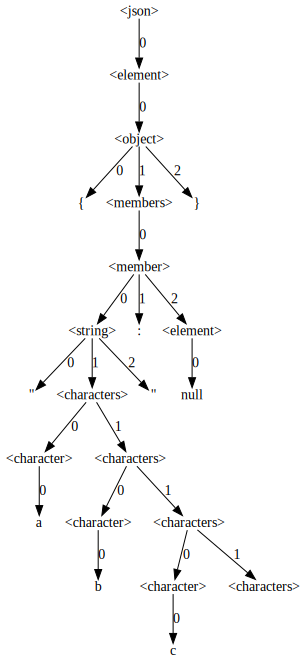

In [526]:
display_tree(v)

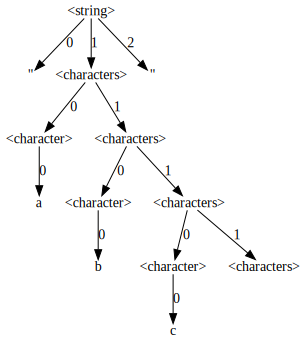

In [527]:
string_node_path = [0,0,1,0,0]
display_tree(find_node(v, string_node_path))

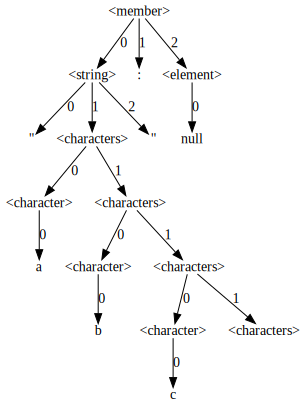

In [528]:
display_tree(find_node(v, [0,0,1, 0]))

In [529]:
F_kv_null = mark_abstract_nodes(v, [string_node_path])
Ta(F_kv_null)

'{<string>:null}'

In [530]:
nn = find_node(F_kv_null, [0,0,1,0])

In [531]:
Ta(nn)

'<string>:null'

In [532]:
Fkvn = nn # find_charecterizing_node(F_kv_null)

In [533]:
Fkvn

('<member>',
 [('<string>',
   [('"', [], {'abstract': False}),
    ('<characters>',
     [('<character>', [('a', [], {'abstract': False})], {'abstract': False}),
      ('<characters>',
       [('<character>', [('b', [], {'abstract': False})], {'abstract': False}),
        ('<characters>',
         [('<character>',
           [('c', [], {'abstract': False})],
           {'abstract': False}),
          ('<characters>', [], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    ('"', [], {'abstract': False})],
   {'abstract': True}),
  (':', [], {'abstract': False}),
  ('<element>', [('null', [], {'abstract': False})], {'abstract': False})],
 {'abstract': False})

In [534]:
latex_abs_tree(Fkvn)


%\resizebox{.99\columnwidth}{.050\totalheight}{
\Tree[.\nonterm{member} \absnonterm{string} \textit{:} [.\nonterm{element} \textit{null} ] ]
%}
    


In [535]:
Gs(faulty_node_to_pattern_grammar(Fkvn, 'KVN')[0])

<member LKVN_1> ::=
|    <string> ':' <element LKVN_1>
<element LKVN_1> ::=
|    'null'
2 2


In [536]:
reachable_json = reachable_dict(JSON_GRAMMAR);

for k in reachable_json:
    if '<member>' in reachable_json[k]:
        print(k)

<json>
<element>
<object>
<members>
<member>
<array>
<elements>


In [537]:
%%top
for k in JSON_GRAMMAR:
    print(k)
    for rule in JSON_GRAMMAR[k]:
        v = get_reachable_positions(rule, '<member>', reachable_json)
        print('\t', rule, v)

<json>
	 ['<element>'] [0]
<element>
	 ['<object>'] [0]
	 ['<array>'] [0]
	 ['<string>'] []
	 ['<number>'] []
	 ['true'] []
	 ['false'] []
	 ['null'] []
<object>
	 ['{', '<members>', '}'] [1]
	 ['{}'] []
<members>
	 ['<member>'] [0]
	 ['<member>', ',', '<members>'] [0, 2]
<member>
	 ['<string>', ':', '<element>'] [2]
<array>
	 ['[', '<elements>', ']'] [1]
	 ['[]'] []
<elements>
	 ['<element>'] [0]
	 ['<element>', ',', '<elements>'] [0, 2]
<string>
	 ['"', '<characters>', '"'] []
<characters>
	 [] []
	 ['<character>', '<characters>'] []
<character>
	 ['a'] []
	 ['b'] []
	 ['c'] []
<number>
	 ['<digits>'] []
<digits>
	 ['<digit>'] []
	 ['<digit>', '<digits>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


In [538]:
%%top
g = {}
for key in JSON_GRAMMAR:
    fk, rules = insert_atleast_one_fault_into_key(JSON_GRAMMAR, key, '<members>', 'KVN', reachable_json)
    g[fk] = rules
g_to_latex(g)

<json +FKVN> ::= <element +FKVN>

<element +FKVN> ::= <object +FKVN>
\alt <array +FKVN>

<object +FKVN> ::= `{' <members +FKVN> `}'

<members +FKVN> ::= <member +FKVN>
\alt <member +FKVN> `,' <members>
\alt <member> `,' <members +FKVN>

<member +FKVN> ::= <string> `:' <element +FKVN>

<array +FKVN> ::= `[' <elements +FKVN> `]'

<elements +FKVN> ::= <element +FKVN>
\alt <element +FKVN> `,' <elements>
\alt <element> `,' <elements +FKVN>

<string +FKVN> ::= 

<characters +FKVN> ::= 

<character +FKVN> ::= 

<number +FKVN> ::= 

<digits +FKVN> ::= 

<digit +FKVN> ::= 



In [539]:
Fkvn_grammar_, Fkvn_start = atleast_one_fault_grammar(JSON_GRAMMAR, JSON_START, Fkvn, 'KVN')

In [540]:
Gs(Fkvn_grammar_)
Fkvn_start

<json +FKVN> ::=
|    <element +FKVN>
<element +FKVN> ::=
|    <array +FKVN>
|    <object +FKVN>
<array +FKVN> ::=
|    '[' <elements +FKVN> ']'
<object +FKVN> ::=
|    '{' <members +FKVN> '}'
<elements +FKVN> ::=
|    <element +FKVN>
|    <element +FKVN> ',' <elements>
|    <element> ',' <elements +FKVN>
<elements> ::=
|    <element>
|    <element> ',' <elements>
<element> ::=
|    <array>
|    <number>
|    <object>
|    <string>
|    'false'
|    'null'
|    'true'
<array> ::=
|    '[' <elements> ']'
|    '[]'
<number> ::=
|    <digits>
<object> ::=
|    '{' <members> '}'
|    '{}'
<string> ::=
|    '"' <characters> '"'
<digits> ::=
|    <digit>
|    <digit> <digits>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<members> ::=
|    <member>
|    <member> ',' <members>
<member> ::=
|    <string> ':' <element>
<characters> ::=
|    
|    <character> <characters>
<character> ::=
|    'a'
|    'b'
|    'c'
<members +FKVN> ::=
|    <

'<json +FKVN>'

In [541]:
g_to_latex(Fkvn_grammar_)

<json +FKVN> ::= <element +FKVN>

<element +FKVN> ::= <array +FKVN>
\alt <object +FKVN>

<array +FKVN> ::= `[' <elements +FKVN> `]'

<object +FKVN> ::= `{' <members +FKVN> `}'

<elements +FKVN> ::= <element +FKVN>
\alt <element +FKVN> `,' <elements>
\alt <element> `,' <elements +FKVN>

<elements> ::= <element>
\alt <element> `,' <elements>

<element> ::= <array>
\alt <number>
\alt <object>
\alt <string>
\alt `false'
\alt `null'
\alt `true'

<array> ::= `[' <elements> `]'
\alt `[]'

<number> ::= <digits>

<object> ::= `{' <members> `}'
\alt `{}'

<string> ::= `"' <characters> `"'

<digits> ::= <digit>
\alt <digit> <digits>

<digit> ::= `0'
\alt `1'
\alt `2'
\alt `3'
\alt `4'
\alt `5'
\alt `6'
\alt `7'
\alt `8'
\alt `9'

<members> ::= <member>
\alt <member> `,' <members>

<member> ::= <string> `:' <element>

<characters> ::= $\epsilon$
\alt <character> <characters>

<character> ::= `a'
\alt `b'
\alt `c'

<members +FKVN> ::= <member +FKVN>
\alt <member +FKVN> `,' <members>
\alt <member> `

In [542]:
Fkvn_parser = Parser(Fkvn_grammar_, canonical=True, start_symbol=Fkvn_start)

In [543]:
assert Fkvn_parser.can_parse('{"":1,"":null}')

In [544]:
assert Fkvn_parser.can_parse('{"":null,"a":[]}')

In [545]:
FNkvn_grammar, FNkvn_start = negate_grammar(Fkvn_grammar_, Fkvn_start, JSON_GRAMMAR, JSON_START)

In [546]:
Gs(FNkvn_grammar)
FNkvn_start

<json neg(+FKVN)> ::=
|    <element neg(+FKVN)>
<element neg(+FKVN)> ::=
|    <array neg(+FKVN)>
|    <number>
|    <object neg(+FKVN)>
|    <string>
|    'false'
|    'null'
|    'true'
<array neg(+FKVN)> ::=
|    '[' <elements neg(+FKVN)> ']'
|    '[]'
<number> ::=
|    <digits>
<object neg(+FKVN)> ::=
|    '{' <members neg(+FKVN)> '}'
|    '{}'
<string> ::=
|    '"' <characters> '"'
<elements neg(+FKVN)> ::=
|    <element neg(+FKVN)>
|    <element neg(+FKVN)> ',' <elements neg(+FKVN)>
<digits> ::=
|    <digit>
|    <digit> <digits>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<members neg(+FKVN)> ::=
|    <member neg(+FKVN)>
|    <member neg(+FKVN)> ',' <members neg(+FKVN)>
<member neg(+FKVN)> ::=
|    <string> ':' <element and(neg(+FKVN),neg(LKVN_1))>
<element and(neg(+FKVN),neg(LKVN_1))> ::=
|    <array neg(+FKVN)>
|    <number>
|    <object neg(+FKVN)>
|    <string>
|    'false'
|    'true'
<characters> ::=
|    
|    <char

'<json neg(+FKVN)>'

In [547]:
FNkvn_parser = Parser(FNkvn_grammar, start_symbol=FNkvn_start, canonical=True)

In [548]:
assert not FNkvn_parser.can_parse(s_null)

In [549]:
FNkvn_fuzzer = LimitFuzzer(FNkvn_grammar)

In [550]:
for i in range(10):
    v = FNkvn_fuzzer.fuzz(FNkvn_start)
    print(v)

[]
{}
false
6
[true]
""
""
null
true
{}


In [551]:
assert not FNkvn_parser.can_parse('{"":1,"":null}')

In [552]:
g_to_latex(FNkvn_grammar)

<json neg(+FKVN)> ::= <element neg(+FKVN)>

<element neg(+FKVN)> ::= <array neg(+FKVN)>
\alt <number>
\alt <object neg(+FKVN)>
\alt <string>
\alt `false'
\alt `null'
\alt `true'

<array neg(+FKVN)> ::= `[' <elements neg(+FKVN)> `]'
\alt `[]'

<number> ::= <digits>

<object neg(+FKVN)> ::= `{' <members neg(+FKVN)> `}'
\alt `{}'

<string> ::= `"' <characters> `"'

<elements neg(+FKVN)> ::= <element neg(+FKVN)>
\alt <element neg(+FKVN)> `,' <elements neg(+FKVN)>

<digits> ::= <digit>
\alt <digit> <digits>

<digit> ::= `0'
\alt `1'
\alt `2'
\alt `3'
\alt `4'
\alt `5'
\alt `6'
\alt `7'
\alt `8'
\alt `9'

<members neg(+FKVN)> ::= <member neg(+FKVN)>
\alt <member neg(+FKVN)> `,' <members neg(+FKVN)>

<member neg(+FKVN)> ::= <string> `:' <element and(neg(+FKVN),neg(LKVN_1))>

<element and(neg(+FKVN),neg(LKVN_1))> ::= <array neg(+FKVN)>
\alt <number>
\alt <object neg(+FKVN)>
\alt <string>
\alt `false'
\alt `true'

<characters> ::= $\epsilon$
\alt <character> <characters>

<character> ::= `a'
\a

### The key of an object is empty

In [553]:
k_empty = '{"":1}'
v = list(json_parser.parse(k_empty))[0]

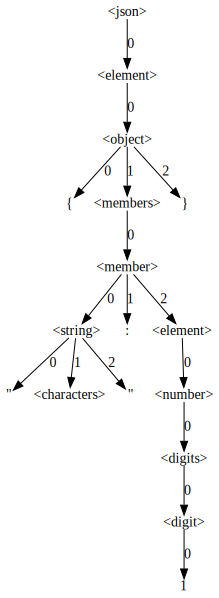

In [554]:
display_tree(v)

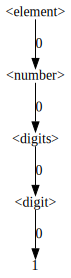

In [555]:
string_node_path2 = [0,0,1,0,2]
display_tree(find_node(v, string_node_path2))

In [556]:
F_k_empty = mark_abstract_nodes(v, [string_node_path2])
Ta(F_k_empty)

'{"":<element>}'

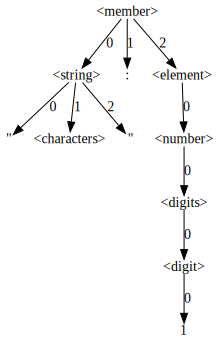

In [557]:
mm = find_node(F_k_empty, [0,0,1,0]);display_tree(mm)

In [558]:
Fke = mm # find_charecterizing_node(F_k_empty)

In [559]:
Ta(Fke)

'"":<element>'

In [560]:
latex_abs_tree(Fke)


%\resizebox{.99\columnwidth}{.050\totalheight}{
\Tree[.\nonterm{member} [.\nonterm{string} \textit{"} [.\nonterm{characters} $\epsilon$ ] \textit{"} ] \textit{:} \absnonterm{element} ]
%}
    


In [561]:
Fke

('<member>',
 [('<string>',
   [('"', [], {'abstract': False}),
    ('<characters>', [], {'abstract': False}),
    ('"', [], {'abstract': False})],
   {'abstract': False}),
  (':', [], {'abstract': False}),
  ('<element>',
   [('<number>',
     [('<digits>',
       [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

In [562]:
Fke_grammar, Fke_start = atleast_one_fault_grammar(JSON_GRAMMAR, JSON_START, Fke, 'EK')

In [563]:
Gs(Fke_grammar)
Fke_start

<json +FEK> ::=
|    <element +FEK>
<element +FEK> ::=
|    <array +FEK>
|    <object +FEK>
<array +FEK> ::=
|    '[' <elements +FEK> ']'
<object +FEK> ::=
|    '{' <members +FEK> '}'
<elements +FEK> ::=
|    <element +FEK>
|    <element +FEK> ',' <elements>
|    <element> ',' <elements +FEK>
<elements> ::=
|    <element>
|    <element> ',' <elements>
<element> ::=
|    <array>
|    <number>
|    <object>
|    <string>
|    'false'
|    'null'
|    'true'
<array> ::=
|    '[' <elements> ']'
|    '[]'
<number> ::=
|    <digits>
<object> ::=
|    '{' <members> '}'
|    '{}'
<string> ::=
|    '"' <characters> '"'
<digits> ::=
|    <digit>
|    <digit> <digits>
<digit> ::=
|    '0'
|    '1'
|    '2'
|    '3'
|    '4'
|    '5'
|    '6'
|    '7'
|    '8'
|    '9'
<members> ::=
|    <member>
|    <member> ',' <members>
<member> ::=
|    <string> ':' <element>
<characters> ::=
|    
|    <character> <characters>
<character> ::=
|    'a'
|    'b'
|    'c'
<members +FEK> ::=
|    <member +FEK>
|

'<json +FEK>'

Now combining both

In [564]:
g,s = and_grammars(Fke_grammar, Fke_start, FNkvn_grammar, FNkvn_start)

In [565]:
Gs(g)

<json and(+FEK,neg(+FKVN))> ::=
|    <element and(+FEK,neg(+FKVN))>
<element and(+FEK,neg(+FKVN))> ::=
|    <array and(+FEK,neg(+FKVN))>
|    <object and(+FEK,neg(+FKVN))>
<array and(+FEK,neg(+FKVN))> ::=
|    '[' <elements and(+FEK,neg(+FKVN))> ']'
<object and(+FEK,neg(+FKVN))> ::=
|    '{' <members and(+FEK,neg(+FKVN))> '}'
<elements and(+FEK,neg(+FKVN))> ::=
|    <element and(+FEK,neg(+FKVN))>
|    <element and(+FEK,neg(+FKVN))> ',' <elements neg(+FKVN)>
|    <element neg(+FKVN)> ',' <elements and(+FEK,neg(+FKVN))>
<elements neg(+FKVN)> ::=
|    <element neg(+FKVN)>
|    <element neg(+FKVN)> ',' <elements neg(+FKVN)>
<element neg(+FKVN)> ::=
|    <array neg(+FKVN)>
|    <number>
|    <object neg(+FKVN)>
|    <string>
|    'false'
|    'null'
|    'true'
<array neg(+FKVN)> ::=
|    '[' <elements neg(+FKVN)> ']'
|    '[]'
<number> ::=
|    <digits>
<object neg(+FKVN)> ::=
|    '{' <members neg(+FKVN)> '}'
|    '{}'
<string> ::=
|    '"' <characters> '"'
<digits> ::=
|    <digit>
|    

In [566]:
g_to_latex(g)

<json and(+FEK,neg(+FKVN))> ::= <element and(+FEK,neg(+FKVN))>

<element and(+FEK,neg(+FKVN))> ::= <array and(+FEK,neg(+FKVN))>
\alt <object and(+FEK,neg(+FKVN))>

<array and(+FEK,neg(+FKVN))> ::= `[' <elements and(+FEK,neg(+FKVN))> `]'

<object and(+FEK,neg(+FKVN))> ::= `{' <members and(+FEK,neg(+FKVN))> `}'

<elements and(+FEK,neg(+FKVN))> ::= <element and(+FEK,neg(+FKVN))>
\alt <element and(+FEK,neg(+FKVN))> `,' <elements neg(+FKVN)>
\alt <element neg(+FKVN)> `,' <elements and(+FEK,neg(+FKVN))>

<elements neg(+FKVN)> ::= <element neg(+FKVN)>
\alt <element neg(+FKVN)> `,' <elements neg(+FKVN)>

<element neg(+FKVN)> ::= <array neg(+FKVN)>
\alt <number>
\alt <object neg(+FKVN)>
\alt <string>
\alt `false'
\alt `null'
\alt `true'

<array neg(+FKVN)> ::= `[' <elements neg(+FKVN)> `]'
\alt `[]'

<number> ::= <digits>

<object neg(+FKVN)> ::= `{' <members neg(+FKVN)> `}'
\alt `{}'

<string> ::= `"' <characters> `"'

<digits> ::= <digit>
\alt <digit> <digits>

<digit> ::= `0'
\alt `1'
\alt `

In [567]:
g_fuzzer = LimitFuzzer(g)

At least one empty key, and no `null` as the value of a key (but `null` can exist anywhere else.)

In [568]:
collect = set()
for i in range(1000):
    v = g_fuzzer.fuzz(s)
    if v not in collect:
        collect.add(v)
        print(v)

[62035,"",[[{"":false},null]]]
[{"":[{"":true},false],"":false,"":true,"":false},"a",""]
[[[false,{"":true}],false],null]
[[[{"":false}]],"bbc"]
[7,true,{"":true,"":false},"",""]
[[[{"":false},true],[]]]
{"ab":{"":false},"":true,"bc":true,"":[{"":true},null]}
{"":{"":7,"":{"":true},"":false,"":true}}
{"":true}
{"":[{},[],false,true],"a":{"":true,"":false},"a":{"":false},"":"","":true}
[[{"":true,"":true}]]
[false,{"":false,"":{"":true}}]
[{"c":"","":false}]
[{"":[{"":true},true],"":3,"":true},false]
[true,{"":{"":true},"":true,"":true},{"":false}]
{"c":false,"":false,"c":[]}
{"":[[{"":false}]]}
[{"":false},{"":[]}]
{"":3}
{"":"bcb","a":[{"":true}],"":8,"":""}
{"a":false,"":{"":true,"":false,"":false}}
[{"":{},"":1,"":{"":false},"":true}]
{"aba":[null,null,true,{"":false}],"aa":[]}
{"ca":{"":[{"":false}]},"ab":[0],"":{},"b":true,"":5}
[false,[[null],[{"":false}]]]
[[{"":true,"":true},{}]]
[8,{"":{},"":false},{"":true,"":false,"":true},false]
{"c":[{"":false}]}
[{"":[{"":true}]}]
{"b":[{

{"bbca":{"":[{"":true}]}}
{"acca":["",false,null,false],"":[[{"":true}]],"":[true,false],"":true,"":""}
{"":"","ac":true}
[false,[[{"":true},false]]]
[false,{"":"","":false}]
{"":false,"a":[{"":true}]}
{"c":{"":{},"":true},"":true}
{"c":"","":true}
[false,4,["",{"":false},null],[null]]
[[[null,{"":true},false]]]
[{"b":true,"":{},"":{"":true}},[]]
{"cca":{"":"","":{"":false},"":false,"":true},"":{},"a":false}
{"":{},"":550}
{"":{"":"","":{"":true}},"":25,"":{"":true}}
[["",[{"":false},false]]]
[{"":[{"":false},null]}]
{"aab":{"":{"":false},"":true}}
{"cbbc":"","a":[[{"":true},true]]}
{"":false,"":[{}]}
[{"":{"":false}},true,false]
[{"":false,"":true,"":true,"":true}]
[5,7,[[{"":true},false]]]
{"aa":{"":{},"":true,"":false,"":true},"cac":[],"b":true}
{"ba":{"":{"":true},"":false},"":6,"bc":false}
{"":[],"":true}
[{"a":[{"":true},null],"":{},"":false,"":true,"":false}]
{"bcc":[{"":false},6],"":{"":false,"":true,"":false}}
[null,{"":true,"":true},932,false,""]
[{"c":[],"":1}]
[{"":false}]


{"":503,"c":{}}
[[[true,true],{"":false},[],null]]
[[true],{"":[],"":{"":false}}]
[[null,null,{"":false},null]]
{"":[[null]]}
{"ab":5,"aa":{},"":"","":true,"":{}}
[{"":true,"":{},"":{"":false},"":false,"":false}]
[{"":false,"":8,"":false},"ac",true]
{"ccc":[[],{},false,false],"":"","":[{"":true}],"c":"","":true,"":false,"":false,"":false}
{"cb":{"":{},"":false,"":true},"ba":{"":false,"":true},"":{},"c":[true],"":{},"":true}
[null,true,[true,false,{"":true}],"",false,7,false]
[[[{"":true},true],false,false,false],[false,0,true,null],[[],false,null],true,"",[]]
{"":{"":8,"":false,"":false},"ab":343}
{"b":false,"":false,"":{},"b":{"":false},"":""}
[[[{"":false},null],true]]
[{},{"":{"":true}},false]
[[],{"":[]},{"":false,"":false,"":true},{"":true,"":true}]
[[[{"":false},true]],true,"ac",{"":true,"":true},{}]
[{"b":[{"":false}],"":7,"":true}]
{"":[{"":false},true,false,false]}
[0,{"":{"":false},"":false,"":true,"":false},0]
[{"":false,"":{},"":true}]
[{},[true,[],{"":true}],{"":true}]
[{"

In [569]:
g_parser = Parser(g, canonical=True, start_symbol=s)

In [570]:
assert g_parser.can_parse('{"":[1]}')

In [571]:
assert not g_parser.can_parse('{null:[1]}')

In [572]:
assert g_parser.can_parse('{"":[]}')

In [573]:
assert g_parser.can_parse('{"":[],"a":[[]]}')

In [574]:
EXCEPTION_HAPPENED

[]

In [575]:
g_to_latex(Fke_grammar )

<json +FEK> ::= <element +FEK>

<element +FEK> ::= <array +FEK>
\alt <object +FEK>

<array +FEK> ::= `[' <elements +FEK> `]'

<object +FEK> ::= `{' <members +FEK> `}'

<elements +FEK> ::= <element +FEK>
\alt <element +FEK> `,' <elements>
\alt <element> `,' <elements +FEK>

<elements> ::= <element>
\alt <element> `,' <elements>

<element> ::= <array>
\alt <number>
\alt <object>
\alt <string>
\alt `false'
\alt `null'
\alt `true'

<array> ::= `[' <elements> `]'
\alt `[]'

<number> ::= <digits>

<object> ::= `{' <members> `}'
\alt `{}'

<string> ::= `"' <characters> `"'

<digits> ::= <digit>
\alt <digit> <digits>

<digit> ::= `0'
\alt `1'
\alt `2'
\alt `3'
\alt `4'
\alt `5'
\alt `6'
\alt `7'
\alt `8'
\alt `9'

<members> ::= <member>
\alt <member> `,' <members>

<member> ::= <string> `:' <element>

<characters> ::= $\epsilon$
\alt <character> <characters>

<character> ::= `a'
\alt `b'
\alt `c'

<members +FEK> ::= <member +FEK>
\alt <member +FEK> `,' <members>
\alt <member> `,' <members +FEK

In [576]:
%%top
g = {}
for key in JSON_GRAMMAR:
    fk, rules = insert_atleast_one_fault_into_key(JSON_GRAMMAR, key, '<member>', 'EK', reachable_json)
    g[fk] = rules
g_to_latex(g)

<json +FEK> ::= <element +FEK>

<element +FEK> ::= <object +FEK>
\alt <array +FEK>

<object +FEK> ::= `{' <members +FEK> `}'

<members +FEK> ::= <member +FEK>
\alt <member +FEK> `,' <members>
\alt <member> `,' <members +FEK>

<member +FEK> ::= <string> `:' <element +FEK>

<array +FEK> ::= `[' <elements +FEK> `]'

<elements +FEK> ::= <element +FEK>
\alt <element +FEK> `,' <elements>
\alt <element> `,' <elements +FEK>

<string +FEK> ::= 

<characters +FEK> ::= 

<character +FEK> ::= 

<number +FEK> ::= 

<digits +FEK> ::= 

<digit +FEK> ::= 



In [577]:
EXCEPTION_HAPPENED

[]